# Exploratory Data Analysis

Exploratory Data Analysis is done in this notebook using the Python code and [Microsoft Data Wrangler](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.datawrangler) plugin.

---


All imports and general definitions used in this notebook.

In [1]:
import helpers
import fiona
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from shapely.geometry import Point
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans
#from sklearn.impute import SimpleImputer
#from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from tpot import TPOTRegressor
from prophet import Prophet

clean_dir = "preprocessed_datasets/"

maps = "zip://" + clean_dir + "TietoaKuntajaosta_2024_10k.zip"
municipality_map = gpd.read_file(maps, layer="SuomenKuntajako_2024_10k")

mappings = helpers.load_dataset(clean_dir + "municipality_and_region_information.csv")

# Datasets, not to be modified - make a copy if needed
vehicle_classes = helpers.load_dataset(clean_dir + "vehicle_class_statistics.csv")
ev_snapshot = helpers.load_dataset(clean_dir + "electric_vehicles_2024-09-30.csv")
socio_whole_country_and_regions = helpers.load_dataset(clean_dir + "socio_whole_country_and_regions.csv")
socio_all_municipalities = helpers.load_dataset(clean_dir + "socio_municipalities.csv")
locations = helpers.load_dataset(clean_dir + "charging_locations.csv")

Analyze the share of EVs in the total number of vehicles.

In [2]:
vehicle_classes

Region   Vehicle class  year  quarter  \
0      Central Finland  Passenger cars  2008        1   
1      Central Finland  Passenger cars  2008        1   
2      Central Finland  Passenger cars  2008        1   
3      Central Finland  Passenger cars  2008        1   
4      Central Finland  Passenger cars  2008        1   
...                ...             ...   ...      ...   
10687          Uusimaa  Passenger cars  2024        2   
10688          Uusimaa  Passenger cars  2024        2   
10689          Uusimaa  Passenger cars  2024        2   
10690          Uusimaa  Passenger cars  2024        2   
10691          Uusimaa  Passenger cars  2024        2   

                     Driving power  Vehicles in traffic  region_id  
0                           Diesel                21511         13  
1                      Electricity                    0         13  
2                Natural gas (CNG)                    5         13  
3                            Other                    8         13  
4                           Petrol               103518         13  
...                            ...                  ...        ...  
10687                       Petrol               485275          1  
10688             Petrol + ethanol                 1125          1  
10689          Petrol/Diesel + CNG                 2863          1  
10690  Petrol/Diesel + electricity                68189          1  
10691                        Total               765277          1  

[10692 rows x 7 columns]

Just a simple bar chart to show the current EV shares per region.

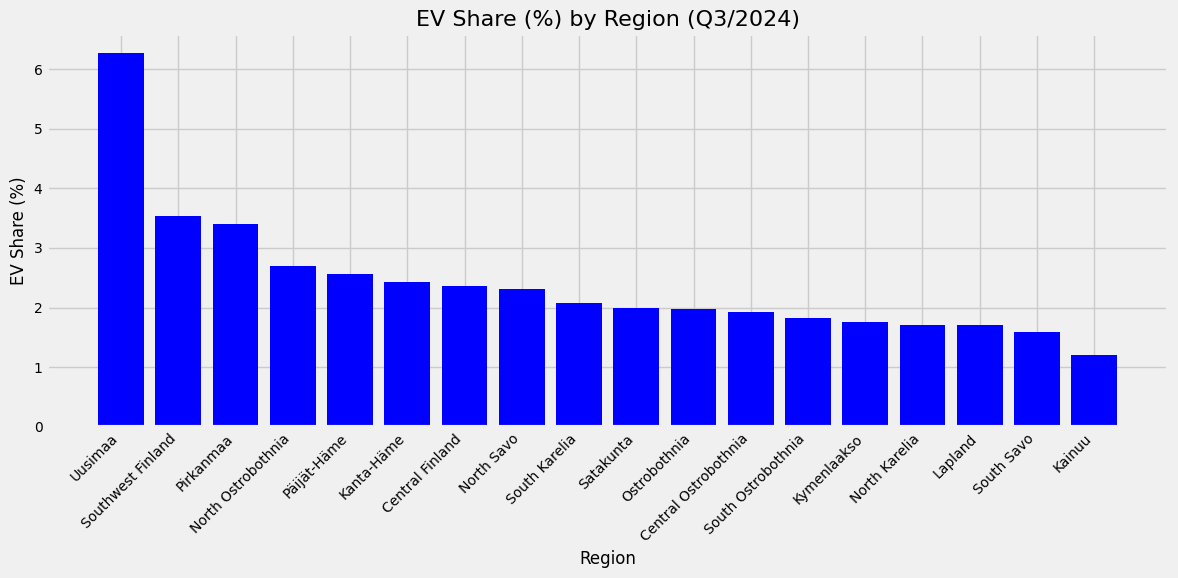

In [3]:
grouped = vehicle_classes[(vehicle_classes["year"] == 2024) & (vehicle_classes["quarter"] == 2)]
grouped = grouped.groupby(["Region", "Driving power"])["Vehicles in traffic"].sum().unstack(fill_value=0)

grouped["EV Share (%)"] = grouped.apply(lambda row: (row["Electricity"] / row["Total"]) * 100 if row["Total"] > 0 else 0, axis=1)

grouped.reset_index(inplace=True)

grouped.sort_values("EV Share (%)", ascending=False, inplace=True)

helpers.draw_bar_chart(
    grouped,
    index="Region",
    values="EV Share (%)",
    title="EV Share (%) by Region (Q3/2024)",
    xlabel="Region",
    ylabel="EV Share (%)",
    color="blue",
    style="fivethirtyeight"
)

Municipalities with the highest EV adoption rates (share of total vehicles):

In [4]:
evs = ev_snapshot.copy()

evs.sort_values("EV Share (%)", ascending=False, inplace=True)
evs.reset_index(drop=True, inplace=True)

evs.head(20)

Municipality                  Make  Total Total  Total Electricity  \
0    Kauniainen  Passenger cars total         4616                497   
1         Espoo  Passenger cars total       131680              12147   
2      Helsinki  Passenger cars total       225008              18762   
3   Kirkkonummi  Passenger cars total        21019               1513   
4        Vantaa  Passenger cars total       115093               7893   
5       Siuntio  Passenger cars total         3840                250   
6      Pirkkala  Passenger cars total        11287                676   
7      Lempäälä  Passenger cars total        14311                815   
8        Paimio  Passenger cars total         7053                395   
9       Kaarina  Passenger cars total        20397               1127   
10        Sipoo  Passenger cars total        13293                732   
11        Masku  Passenger cars total         6125                334   
12     Naantali  Passenger cars total        11709                608   
13   Nurmijärvi  Passenger cars total        25943               1312   
14      Tuusula  Passenger cars total        24613               1215   
15        Lieto  Passenger cars total        12201                601   
16      Muurame  Passenger cars total         5915                290   
17       Porvoo  Passenger cars total        28689               1392   
18        Vihti  Passenger cars total        17058                816   
19        Rusko  Passenger cars total         3958                187   

    Total Petrol/Electricity (plug-in hybrid)  \
0                                         705   
1                                       15885   
2                                       23583   
3                                        1695   
4                                       11052   
5                                         259   
6                                         827   
7                                         906   
8                                         381   
9                                        1574   
10                                        988   
11                                        417   
12                                        962   
13                                       1715   
14                                       1646   
15                                        864   
16                                        348   
17                                       1793   
18                                        978   
19                                        308   

    Total Diesel/Electricity (plug-in hybrid)  Hybrid Share (%)  EV Share (%)  \
0                                          34         16.009532     10.766898   
1                                         485         12.431652      9.224635   
2                                         762         10.819615      8.338370   
3                                          82          8.454256      7.198249   
4                                         406          9.955427      6.857932   
5                                          19          7.239583      6.510417   
6                                          74          7.982635      5.989191   
7                                          60          6.750052      5.694920   
8                                          19          5.671346      5.600454   
9                                          61          8.015885      5.525322   
10                                         49          7.801098      5.506658   
11                                         12          7.004082      5.453061   
12                                         33          8.497737      5.192587   
13                                         90          6.957561      5.057241   
14                                         80          7.012554      4.936416   
15                                         41          7.417425      4.925826   
16                                         27          6.33981

Municipalities with the lowest adoption rates:

In [5]:
evs.tail(20)

Municipality                  Make  Total Total  Total Electricity  \
273    Pielavesi  Passenger cars total         2336                 17   
274        Tervo  Passenger cars total          879                  6   
275        Salla  Passenger cars total         1922                 13   
276       Lieksa  Passenger cars total         5900                 39   
277      Isojoki  Passenger cars total         1247                  8   
278  Taivalkoski  Passenger cars total         2089                 13   
279        Juuka  Passenger cars total         2594                 16   
280   Rautalampi  Passenger cars total         1796                 11   
281    Savukoski  Passenger cars total          527                  3   
282        Posio  Passenger cars total         1765                 10   
283  Suomussalmi  Passenger cars total         4282                 24   
284        Kaavi  Passenger cars total         1622                  9   
285     Puolanka  Passenger cars total         1346                  7   
286        Ranua  Passenger cars total         1940                 10   
287    Kivijärvi  Passenger cars total          600                  3   
288      Kinnula  Passenger cars total          886                  4   
289   Ristijärvi  Passenger cars total          762                  3   
290        Kuhmo  Passenger cars total         4630                 14   
291   Lestijärvi  Passenger cars total          381                  1   
292   Rautavaara  Passenger cars total          897                  0   

     Total Petrol/Electricity (plug-in hybrid)  \
273                                         33   
274                                         13   
275                                         34   
276                                         87   
277                                         16   
278                                         24   
279                                         43   
280                                         32   
281                                         12   
282                                         24   
283                                         51   
284                                         29   
285                                         21   
286                                         14   
287                                          3   
288                                          8   
289                                          7   
290                                         66   
291                                         10   
292                                         11   

     Total Diesel/Electricity (plug-in hybrid)  Hybrid Share (%)  \
273                                          4          1.583904   
274                                          1          1.592719   
275                                          3          1.925078   
276                                          4          1.542373   
277                                          7          1.844427   
278                                          2          1.244615   
279                                          3          1.773323   
280                                          2          1.893096   
281                                          0          2.277040   
282                                          2          1.473088   
283                                          6          1.331154   
284                                          3          1.972873   
285                                          3          1.783061   
286                                          5          0.979381   
287                                          0          0.500000   
288                                          1          1.015801   
289                                          3          1.312336   
290                                          6          1.555076   
291                                          1          2.887139   
292                                   

Notable: There's one municipality with zero EVs. It is close to Kuopio which has a plenty of charging stations. This could be a data error - to be studied further.

Municipalities with the highest plugin-hybrid adoption rates (share of total vehicles):

In [6]:
hybrids = ev_snapshot.copy()

hybrids.sort_values("Hybrid Share (%)", ascending=False, inplace=True)
hybrids.reset_index(drop=True, inplace=True)

hybrids.head(20)

Municipality                  Make  Total Total  Total Electricity  \
0    Kauniainen  Passenger cars total         4616                497   
1         Espoo  Passenger cars total       131680              12147   
2      Helsinki  Passenger cars total       225008              18762   
3        Vantaa  Passenger cars total       115093               7893   
4      Naantali  Passenger cars total        11709                608   
5   Kirkkonummi  Passenger cars total        21019               1513   
6         Rusko  Passenger cars total         3958                187   
7       Kaarina  Passenger cars total        20397               1127   
8      Pirkkala  Passenger cars total        11287                676   
9         Sipoo  Passenger cars total        13293                732   
10       Raisio  Passenger cars total        14814                621   
11    Järvenpää  Passenger cars total        22257                929   
12        Lieto  Passenger cars total        12201                601   
13      Siuntio  Passenger cars total         3840                250   
14       Kerava  Passenger cars total        17198                693   
15      Tuusula  Passenger cars total        24613               1215   
16        Masku  Passenger cars total         6125                334   
17   Nurmijärvi  Passenger cars total        25943               1312   
18        Turku  Passenger cars total        83915               3537   
19     Lempäälä  Passenger cars total        14311                815   

    Total Petrol/Electricity (plug-in hybrid)  \
0                                         705   
1                                       15885   
2                                       23583   
3                                       11052   
4                                         962   
5                                        1695   
6                                         308   
7                                        1574   
8                                         827   
9                                         988   
10                                       1069   
11                                       1583   
12                                        864   
13                                        259   
14                                       1173   
15                                       1646   
16                                        417   
17                                       1715   
18                                       5581   
19                                        906   

    Total Diesel/Electricity (plug-in hybrid)  Hybrid Share (%)  EV Share (%)  \
0                                          34         16.009532     10.766898   
1                                         485         12.431652      9.224635   
2                                         762         10.819615      8.338370   
3                                         406          9.955427      6.857932   
4                                          33          8.497737      5.192587   
5                                          82          8.454256      7.198249   
6                                          13          8.110157      4.724608   
7                                          61          8.015885      5.525322   
8                                          74          7.982635      5.989191   
9                                          49          7.801098      5.506658   
10                                         48          7.540165      4.191981   
11                                         85          7.494271      4.173968   
12                                         41          7.417425      4.925826   
13                                         19          7.239583      6.510417   
14                                         57          7.151994      4.029538   
15                                         80          7.012554      4.936416   
16                                         12          7.00408

Municipalities with the lowest plugin-hybrid adoption rates (share of total vehicles):

In [7]:
hybrids.tail(20)

Municipality                  Make  Total Total  Total Electricity  \
273    Pielavesi  Passenger cars total         2336                 17   
274        Kuhmo  Passenger cars total         4630                 14   
275       Lieksa  Passenger cars total         5900                 39   
276        Posio  Passenger cars total         1765                 10   
277      Pyhäntä  Passenger cars total          828                 20   
278      Paltamo  Passenger cars total         1806                 28   
279    Merijärvi  Passenger cars total          557                  8   
280      Vesanto  Passenger cars total         1156                 10   
281   Rautavaara  Passenger cars total          897                  0   
282  Suomussalmi  Passenger cars total         4282                 24   
283   Pudasjärvi  Passenger cars total         3960                 41   
284   Ristijärvi  Passenger cars total          762                  3   
285  Taivalkoski  Passenger cars total         2089                 13   
286    Enonkoski  Passenger cars total          806                  9   
287    Ilomantsi  Passenger cars total         2766                 29   
288      Kinnula  Passenger cars total          886                  4   
289        Ranua  Passenger cars total         1940                 10   
290        Perho  Passenger cars total         1457                 21   
291     Karijoki  Passenger cars total          770                  8   
292    Kivijärvi  Passenger cars total          600                  3   

     Total Petrol/Electricity (plug-in hybrid)  \
273                                         33   
274                                         66   
275                                         87   
276                                         24   
277                                         11   
278                                         20   
279                                          8   
280                                         12   
281                                         11   
282                                         51   
283                                         49   
284                                          7   
285                                         24   
286                                         10   
287                                         29   
288                                          8   
289                                         14   
290                                         10   
291                                          6   
292                                          3   

     Total Diesel/Electricity (plug-in hybrid)  Hybrid Share (%)  \
273                                          4          1.583904   
274                                          6          1.555076   
275                                          4          1.542373   
276                                          2          1.473088   
277                                          1          1.449275   
278                                          6          1.439646   
279                                          0          1.436266   
280                                          4          1.384083   
281                                          1          1.337793   
282                                          6          1.331154   
283                                          3          1.313131   
284                                          3          1.312336   
285                                          2          1.244615   
286                                          0          1.240695   
287                                          4          1.193059   
288                                          1          1.015801   
289                                          5          0.979381   
290                                          2          0.823610   
291                                          0          0.779221   
292                                   

Biggest differences in the ranks of EVs and plugin-hybrids:

In [8]:
evs = evs.reset_index().rename(columns={"index": "Rank EV"})
evs["Rank EV"] += 1

hybrids = hybrids.reset_index().rename(columns={"index": "Rank Hybrid"})
hybrids["Rank Hybrid"] += 1

combined = evs[["Municipality", "Rank EV"]].merge(
    hybrids[["Municipality", "Rank Hybrid"]],
    on='Municipality',
)

combined["Rank Diff"] = (combined["Rank EV"] - combined["Rank Hybrid"])

combined.sort_values("Rank Diff", ascending=False).head(20)

Municipality  Rank EV  Rank Hybrid  Rank Diff
269        Soini      270          130        140
291   Lestijärvi      292          153        139
257        Inari      258          119        139
217       Oripää      218           92        126
221       Närpiö      222          106        116
242       Multia      243          129        114
247   Mäntyharju      248          138        110
192    Virolahti      193           85        108
209       Säkylä      210          104        106
230    Sodankylä      231          135         96
216   Haapajärvi      217          123         94
225   Harjavalta      226          133         93
267      Keitele      268          176         92
197      Nakkila      198          109         89
185      Varkaus      186           98         88
157      Kouvola      158           70         88
244   Pieksämäki      245          157         88
272      Vieremä      273          186         87
215       Virrat      216          131         85
259      Kuusamo      260          180         80

The regions that rank in top 20 in both EVs and plugin-hybrids:

In [9]:
combined[(combined["Rank EV"] <= 20) & (combined["Rank Hybrid"] <= 20)]

Municipality  Rank EV  Rank Hybrid  Rank Diff
0    Kauniainen        1            1          0
1         Espoo        2            2          0
2      Helsinki        3            3          0
3   Kirkkonummi        4            6         -2
4        Vantaa        5            4          1
5       Siuntio        6           14         -8
6      Pirkkala        7            9         -2
7      Lempäälä        8           20        -12
9       Kaarina       10            8          2
10        Sipoo       11           10          1
11        Masku       12           17         -5
12     Naantali       13            5          8
13   Nurmijärvi       14           18         -4
14      Tuusula       15           16         -1
15        Lieto       16           13          3
19        Rusko       20            7         13

The regions that rank in bottom 20 in both EVs and plugin-hybrids:

In [10]:
total_rows = len(combined)

combined[(combined["Rank EV"] >= total_rows - 20) & (combined["Rank Hybrid"] >= total_rows - 20)]

Municipality  Rank EV  Rank Hybrid  Rank Diff
273    Pielavesi      274          274          0
274        Tervo      275          273          2
276       Lieksa      277          276          1
278  Taivalkoski      279          286         -7
282        Posio      283          277          6
283  Suomussalmi      284          283          1
286        Ranua      287          290         -3
287    Kivijärvi      288          293         -5
288      Kinnula      289          289          0
289   Ristijärvi      290          285          5
290        Kuhmo      291          275         16
292   Rautavaara      293          282         11

Municipalities in which EVs at least as popular as plug-in hybrids:

In [11]:
evs[evs["EV Share (%)"] >= evs["Hybrid Share (%)"]]

Rank EV Municipality                  Make  Total Total  \
22        23      Liminka  Passenger cars total         5039   
25        26        Sauvo  Passenger cars total         1884   
40        41  Siilinjärvi  Passenger cars total        11827   
42        43     Lumijoki  Passenger cars total         1048   
43        44     Toivakka  Passenger cars total         1403   
52        53      Tyrnävä  Passenger cars total         3353   
54        55        Muhos  Passenger cars total         4782   
74        75     Pyhäjoki  Passenger cars total         1750   
86        87      Pyhäntä  Passenger cars total          828   
95        96      Luhanka  Passenger cars total          477   
107      108    Siikajoki  Passenger cars total         2725   
182      183      Paltamo  Passenger cars total         1806   
202      203        Perho  Passenger cars total         1457   
204      205    Merijärvi  Passenger cars total          557   
251      252     Karijoki  Passenger cars total          770   
287      288    Kivijärvi  Passenger cars total          600   

     Total Electricity  Total Petrol/Electricity (plug-in hybrid)  \
22                 227                                        192   
25                  82                                         61   
40                 417                                        379   
42                  36                                         22   
43                  48                                         36   
52                 101                                         65   
54                 143                                        121   
74                  45                                         42   
86                  20                                         11   
95                  11                                          8   
107                 59                                         45   
182                 28                                         20   
202                 21                                         10   
204                  8                                          8   
251                  8                                          6   
287                  3                                          3   

     Total Diesel/Electricity (plug-in hybrid)  Hybrid Share (%)  \
22                                          10          4.008732   
25                                           3          3.397028   
40                                          21          3.382092   
42                                           1          2.194656   
43                                           1          2.637206   
52                                           3          2.028035   
54                                           5          2.634881   
74                                           2          2.514286   
86                                           1          1.449275   
95                                           2          2.096436   
107                                          1          1.688073   
182                                          6          1.439646   
202                                          2          0.823610   
204                                          0          1.436266   
251                                          0          0.779221   
287                                          0          0.500000   

     EV Share (%)  municipality_id  region_id  
22       4.504862              425         17  
25       4.352442              738          2  
40       3.525831              749         11  
42       3.435115              436         17  
43       3.421240              850         13  
52       3.012228              859         17  
54       2.990381              494         17  
74       2.571429              625         17  
86       2.415459              630         17  
95       2.306080              435         13  
107      2.165138              748         17  
182      

Notable: This seems to be an Ostrobothnian phenomenon. Out of 16 entries:

- 8 municipalities from North Ostrobothnia (Region 17)
- 1 municipality from Central Ostrobothnia (Region 16)
- 1 municipality from South Ostrobothnia (Region 14)

In [12]:
#  Markdown output for the blog article

helpers.df_to_markdown(combined.sort_values("Rank Diff", ascending=False).head(20), ["Municipality", "Rank EV", "Rank Hybrid", "Rank Diff"])
print("\n")
helpers.df_to_markdown(combined[(combined["Rank EV"] <= 20) & (combined["Rank Hybrid"] <= 20)], ["Municipality", "Rank EV", "Rank Hybrid", "Rank Diff"])
print("\n")
helpers.df_to_markdown(combined[(combined["Rank EV"] >= total_rows - 20) & (combined["Rank Hybrid"] >= total_rows - 20)], ["Municipality", "Rank EV", "Rank Hybrid", "Rank Diff"])
print("\n")
helpers.df_to_markdown(evs[evs["EV Share (%)"] >= evs["Hybrid Share (%)"]], ["Rank EV", "Municipality", "Hybrid Share (%)", "EV Share (%)"])

| Municipality   |   Rank EV |   Rank Hybrid |   Rank Diff |
|:---------------|----------:|--------------:|------------:|
| Soini          |       270 |           130 |         140 |
| Lestijärvi     |       292 |           153 |         139 |
| Inari          |       258 |           119 |         139 |
| Oripää         |       218 |            92 |         126 |
| Närpiö         |       222 |           106 |         116 |
| Multia         |       243 |           129 |         114 |
| Mäntyharju     |       248 |           138 |         110 |
| Virolahti      |       193 |            85 |         108 |
| Säkylä         |       210 |           104 |         106 |
| Sodankylä      |       231 |           135 |          96 |
| Haapajärvi     |       217 |           123 |          94 |
| Harjavalta     |       226 |           133 |          93 |
| Keitele        |       268 |           176 |          92 |
| Nakkila        |       198 |           109 |          89 |
| Varkaus        |      

<Figure size 1200x600 with 0 Axes>

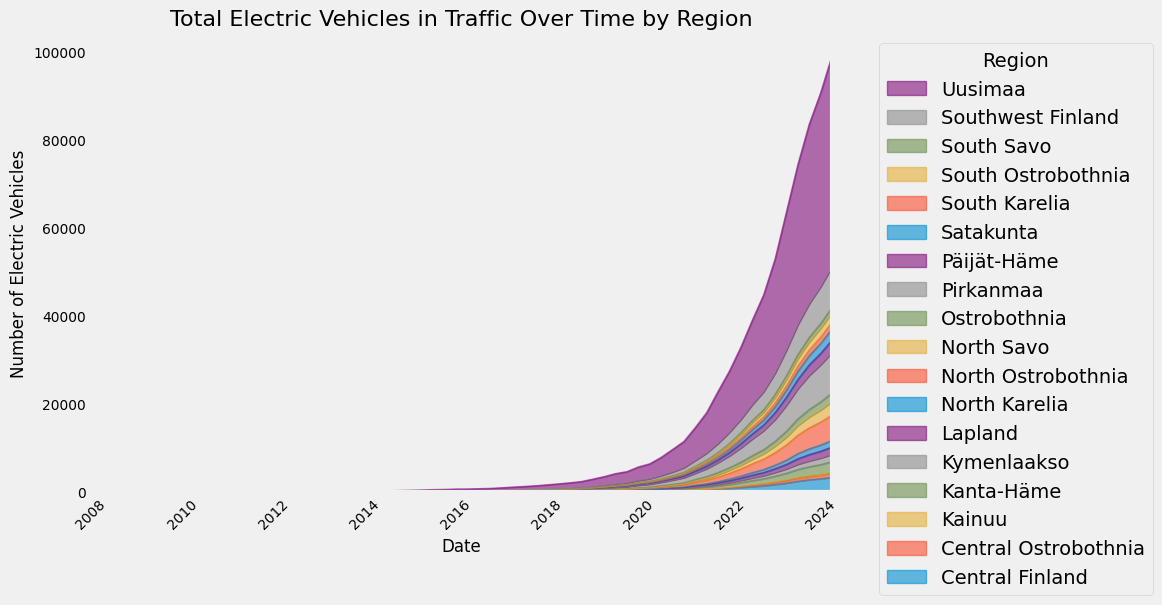

In [13]:
ev_data = vehicle_classes[vehicle_classes["Driving power"] == "Electricity"].copy()

ev_data["Date"] = ev_data.apply(lambda row: helpers.get_last_day_of_quarter(row["year"], row["quarter"]), axis=1)

helpers.draw_stacked_area(
    ev_data,
    index="Date",
    columns="Region",
    values="Vehicles in traffic",
    title="Total Electric Vehicles in Traffic Over Time by Region",
    xlabel="Date",
    ylabel="Number of Electric Vehicles",
    legend_title="Region",
    style="fivethirtyeight"
)

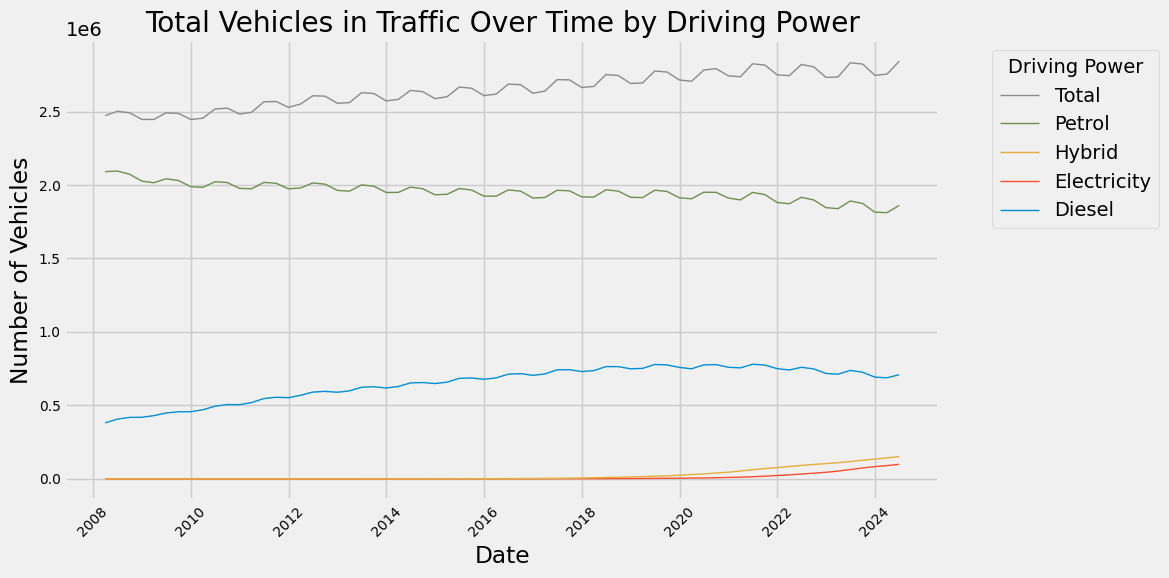

In [14]:
ev_data = vehicle_classes.copy()

ev_data["Date"] = ev_data.apply(lambda row: helpers.get_last_day_of_quarter(row["year"], row["quarter"]), axis=1)

ev_data = ev_data.groupby(["Date", "Driving power"])["Vehicles in traffic"].sum().reset_index()
ev_data = ev_data[ev_data["Driving power"].isin(["Electricity", "Petrol", "Diesel", "Petrol/Diesel + electricity", "Total"])]
ev_data["Driving power"] = ev_data["Driving power"].replace("Petrol/Diesel + electricity", "Hybrid")

helpers.draw_line_chart(
    ev_data,
    index='Date',
    columns='Driving power',
    values='Vehicles in traffic',
    title='Total Vehicles in Traffic Over Time by Driving Power',
    xlabel='Date',
    ylabel='Number of Vehicles',
    legend_title='Driving Power',
    style="fivethirtyeight"
)

There are seasonal effects as can be seen from the lines of the highest values.

_Side quest(ion): What is the cause of this seasonality?_ I assume passenger vehicles are taken out of use during the winter months. 

Although the amount of cars is increasing, the share of petrol has been decreasing steadily since 2008. Diesel has been increasing until 2019-ish and has been slightly declining since then.

Is there seasonality in the EVs and hybrids?

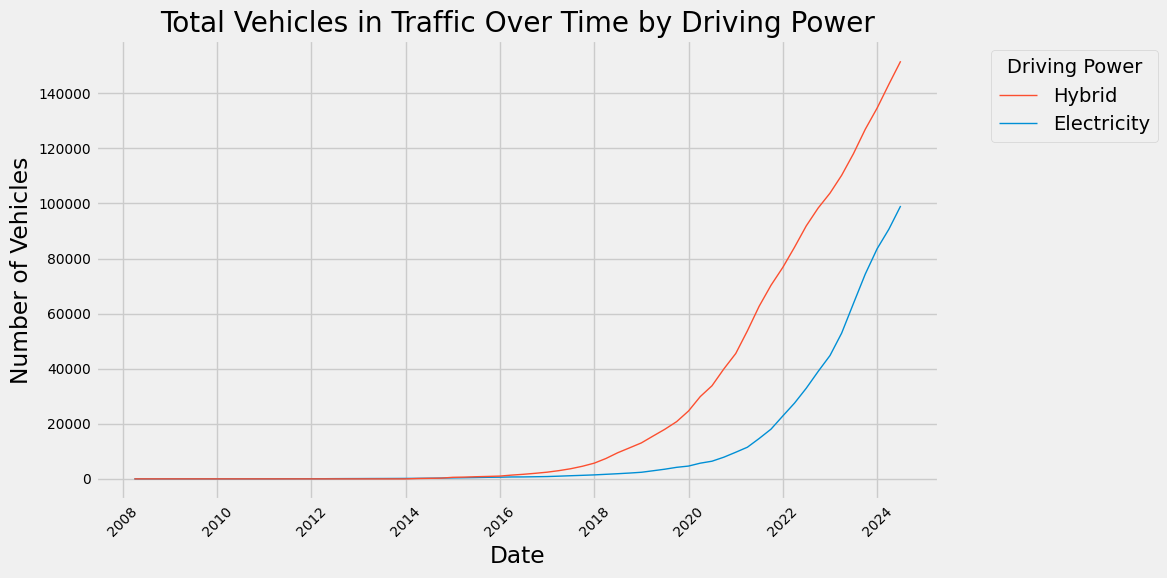

In [15]:
ev_data = ev_data[ev_data["Driving power"].isin(["Electricity", "Hybrid"])]

helpers.draw_line_chart(
    ev_data,
    index='Date',
    columns='Driving power',
    values='Vehicles in traffic',
    title='Total Vehicles in Traffic Over Time by Driving Power',
    xlabel='Date',
    ylabel='Number of Vehicles',
    legend_title='Driving Power',
    style="fivethirtyeight"
)

Yes, there seems to be seasonal effects also in the EVs and hybrids.

“Prediction is very difficult, especially if it's about the future!” -- Niels Bohr

It might not be very useful but it's fun.

Let's forecast the shares of different types of vehicles in the future using Meta's Prophet.

21:41:35 - cmdstanpy - INFO - Chain [1] start processing
21:41:35 - cmdstanpy - INFO - Chain [1] done processing
21:41:35 - cmdstanpy - INFO - Chain [1] start processing
21:41:35 - cmdstanpy - INFO - Chain [1] done processing
21:41:35 - cmdstanpy - INFO - Chain [1] start processing
21:41:35 - cmdstanpy - INFO - Chain [1] done processing
21:41:35 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:37 - cmdstanpy - INFO - Chain [1] done processing
21:41:37 - cmdstanpy - INFO - Chain [1] start processing
21:41:37 - cmdstanpy - INFO - Chain [1]

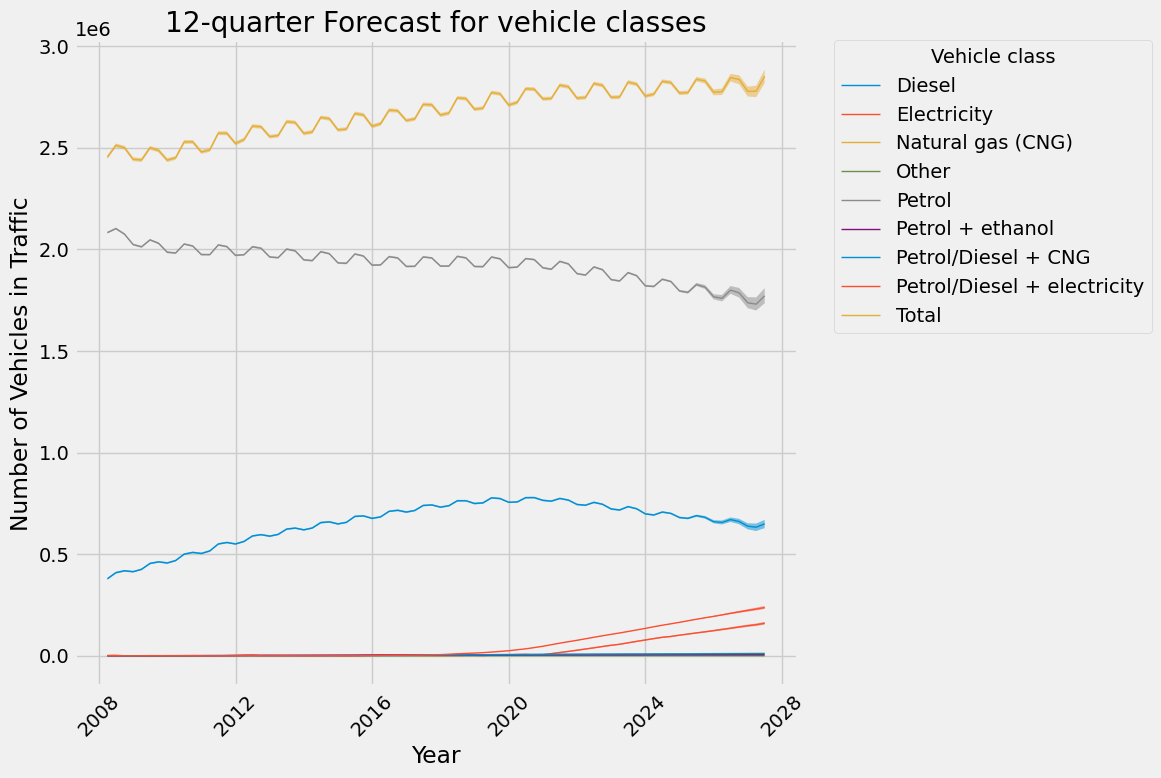

In [16]:
# The prediction period (in quarters)

n = 12

vehicles = vehicle_classes.copy()

# Combine year and quarter into a datetime format
vehicles['Date'] = vehicles.apply(lambda row: helpers.get_last_day_of_quarter(row["year"], row["quarter"]), axis=1)

# Group by Date and Driving power, summing across all regions
grouped_data = vehicles.groupby(['Date', 'Driving power'])['Vehicles in traffic'].sum().reset_index()

# Prepare an empty DataFrame to store all forecasts
all_forecasts = pd.DataFrame()

# Loop through each vehicle class, forecast, and store the results
classes = grouped_data['Driving power'].unique()

for c in classes:
    class_data = grouped_data[grouped_data['Driving power'] == c][['Date', 'Vehicles in traffic']].rename(columns={'Date': 'ds', 'Vehicles in traffic': 'y'})
    
    # Create and fit the Prophet model
    model = Prophet()
    model.fit(class_data)
    
    # Create future dates for the forecast (next 12 quarters)
    future = model.make_future_dataframe(periods=n, freq='QE')
    
    # Generate the forecast
    forecast = model.predict(future)
    
    # Store the forecasted values, vehicle class, and deviation ranges
    forecast['Driving power'] = c
    all_forecasts = pd.concat([all_forecasts, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Driving power']]])

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(12, 8))

    for c in classes:
        class_forecast = all_forecasts[all_forecasts['Driving power'] == c]
        plt.plot(class_forecast['ds'], class_forecast['yhat'], label=c, linewidth=1)
        plt.fill_between(class_forecast['ds'], class_forecast['yhat_lower'], class_forecast['yhat_upper'], alpha=0.5)

    plt.title(f"{n}-quarter Forecast for vehicle classes")
    plt.xlabel("Year")
    plt.ylabel('Number of Vehicles in Traffic')
    plt.legend(title="Vehicle class", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In this scale Prophet basically continues the trend lines which were already visible in the graph.

Maybe we can see something more interesting if we look at lines separately.

21:41:37 - cmdstanpy - INFO - Chain [1] start processing
21:41:37 - cmdstanpy - INFO - Chain [1] done processing


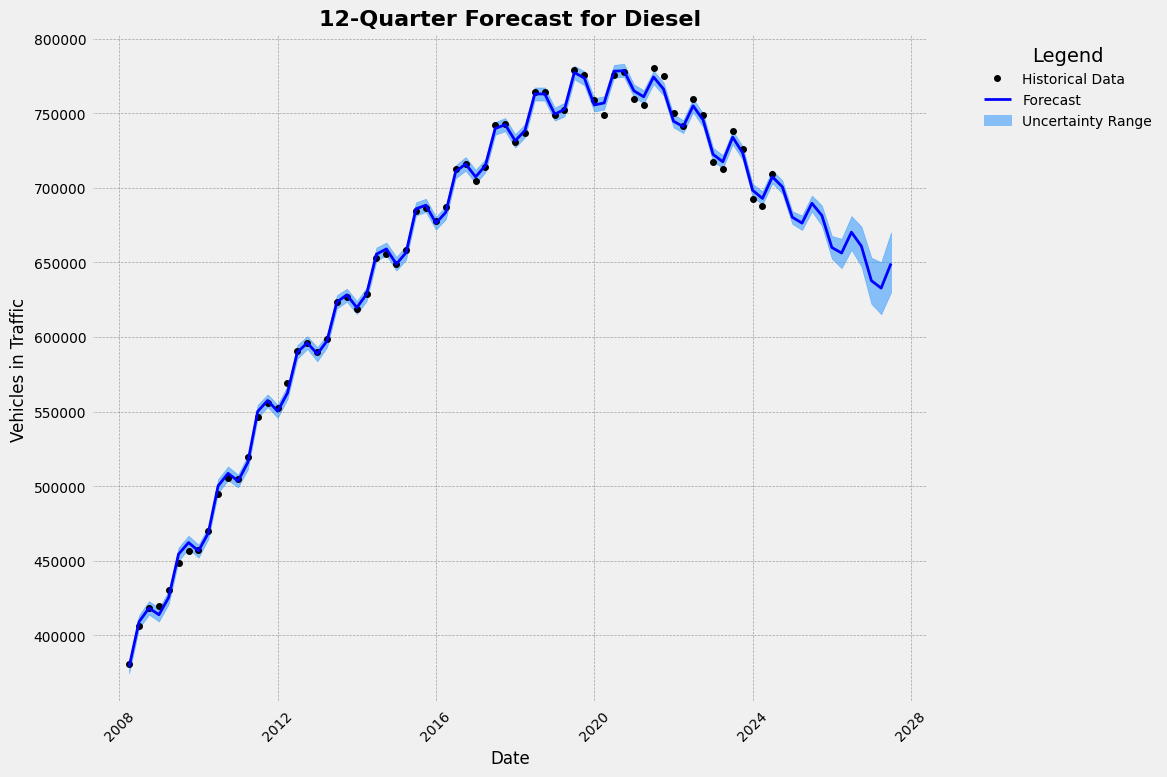

21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing


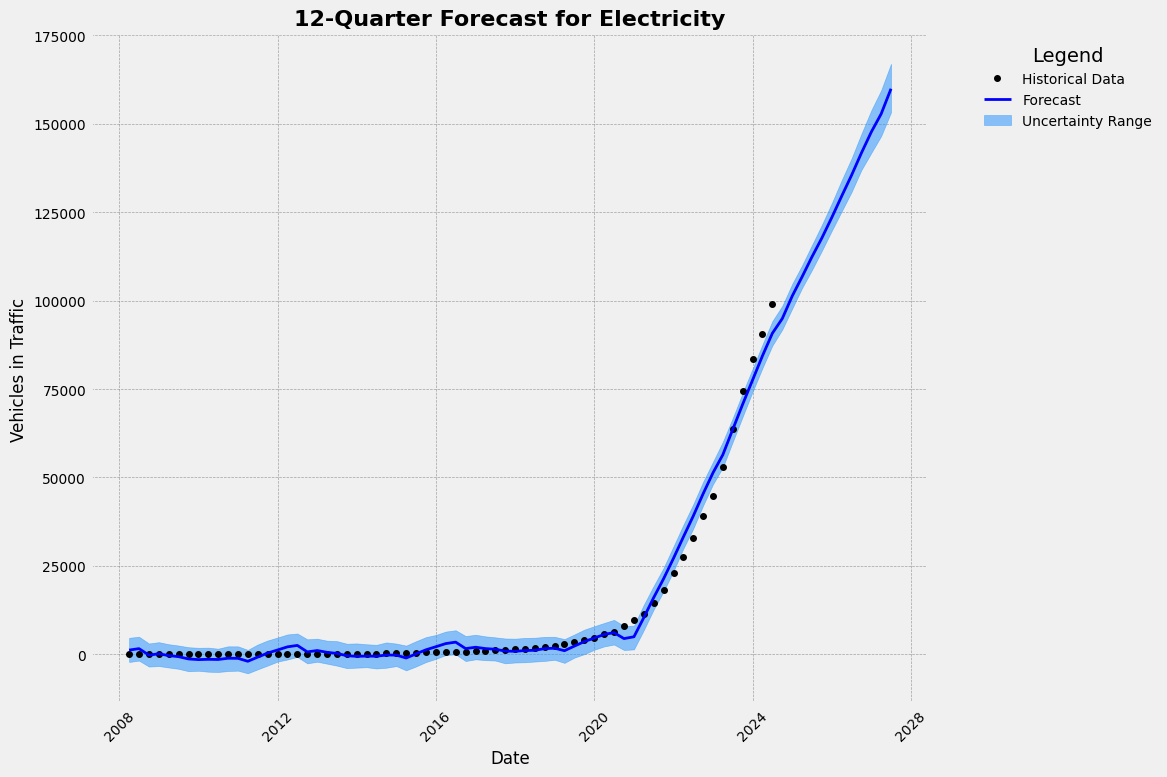

21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing


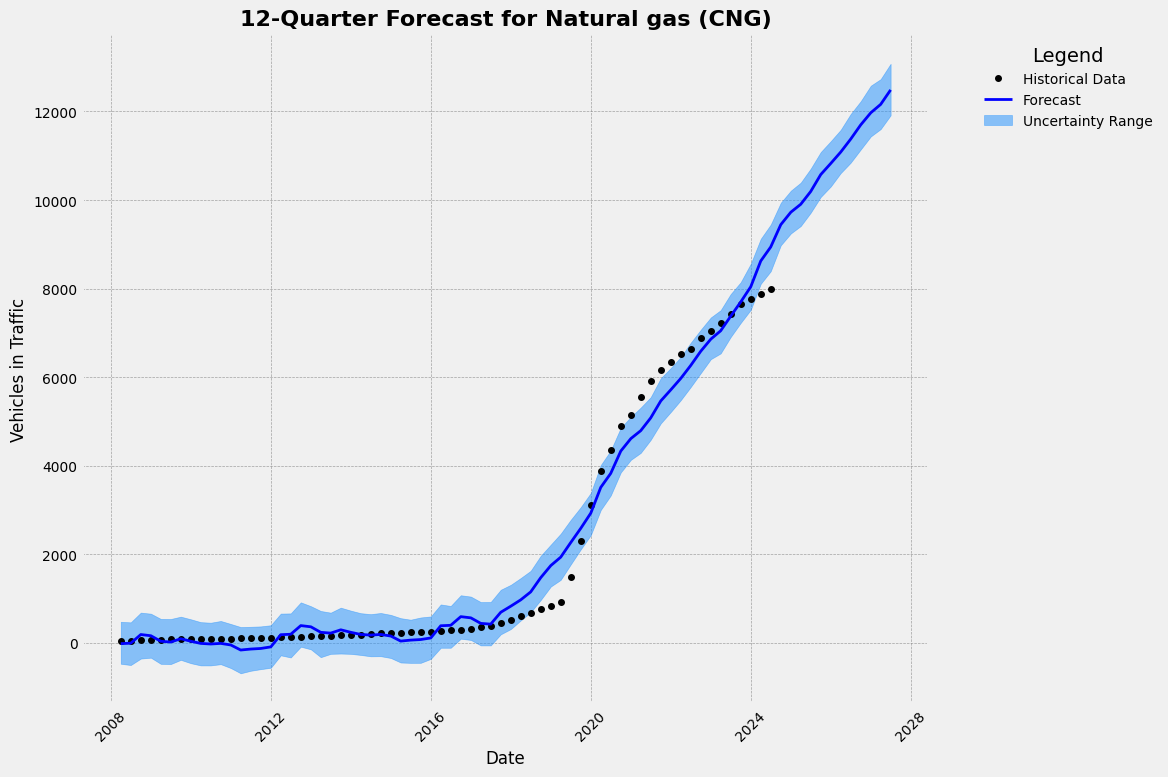

21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing


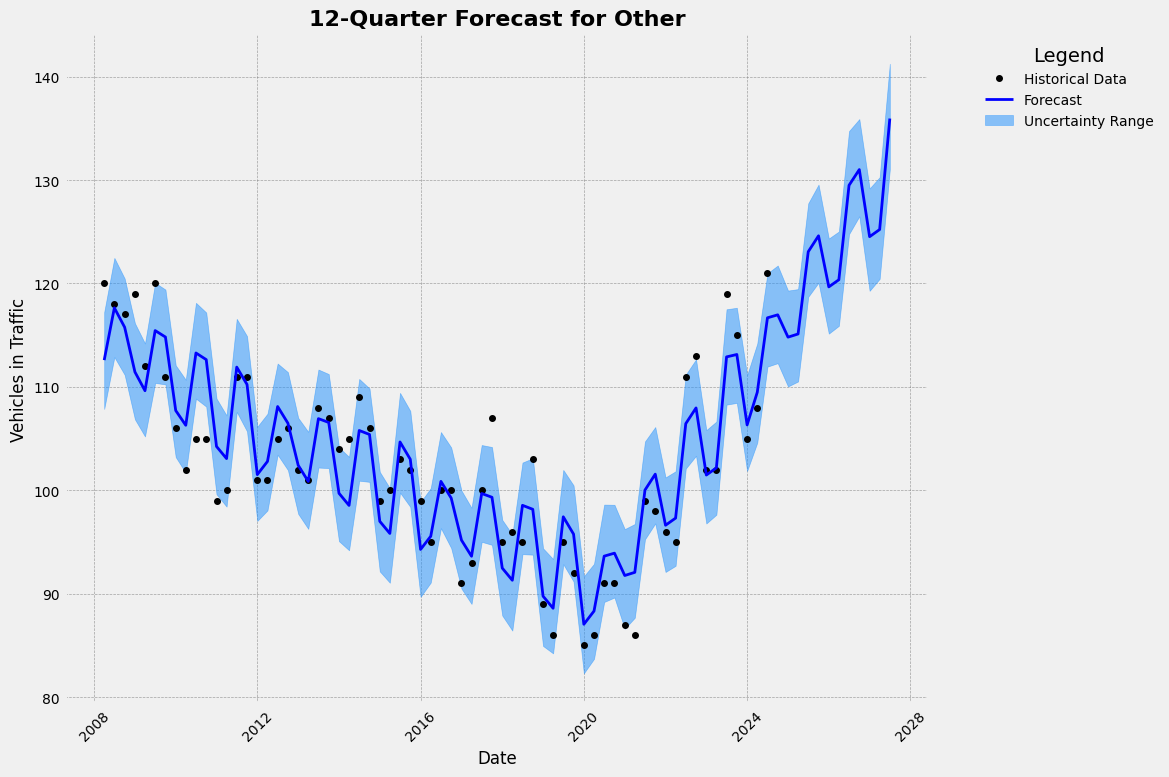

21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing


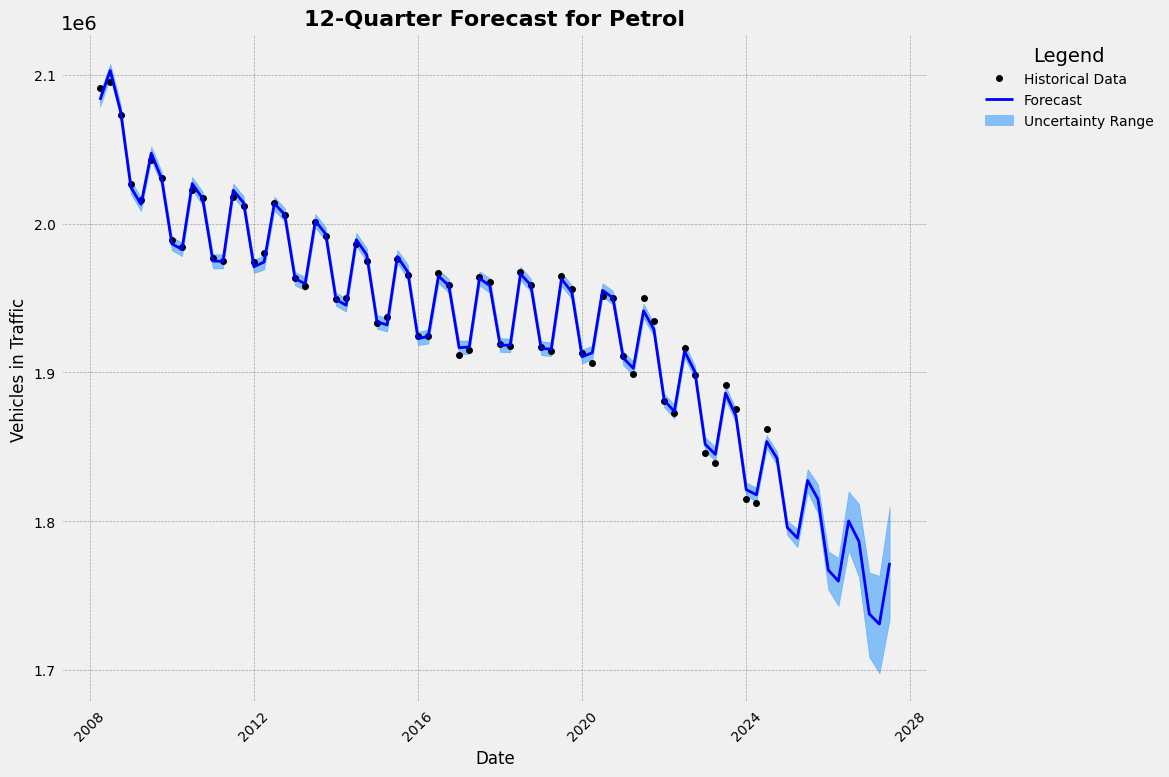

21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing


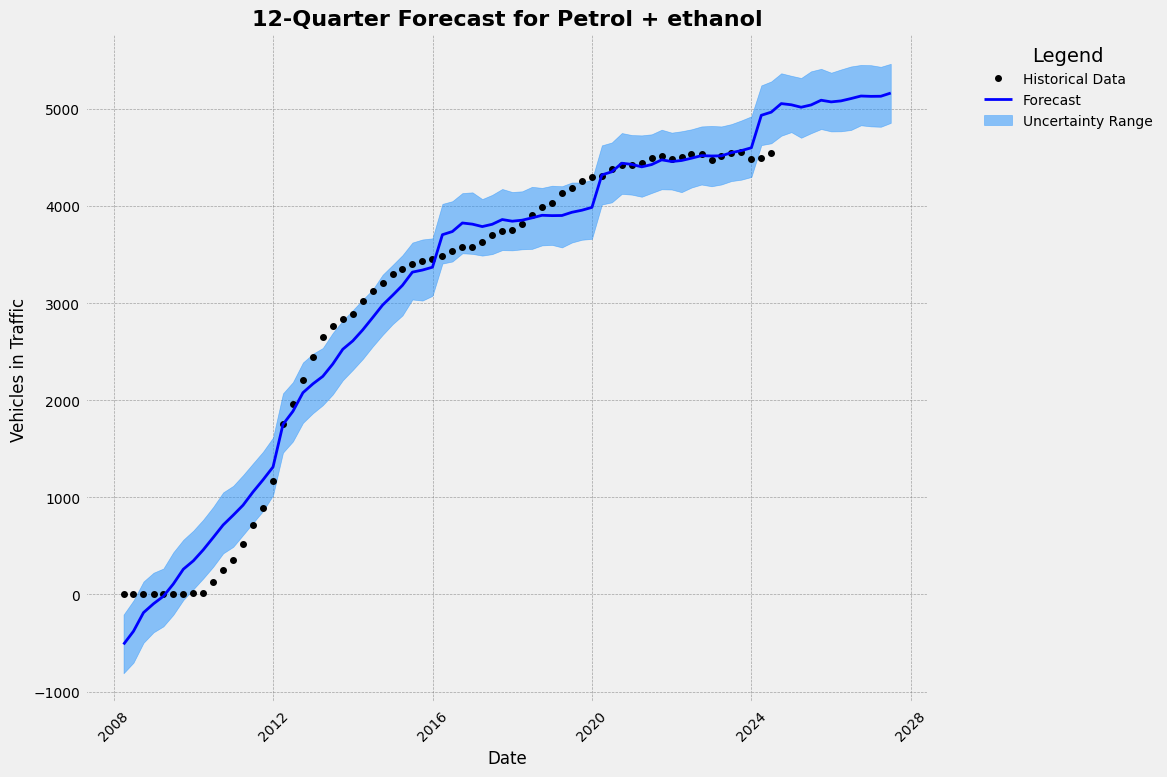

21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:40 - cmdstanpy - INFO - Chain [1] done processing


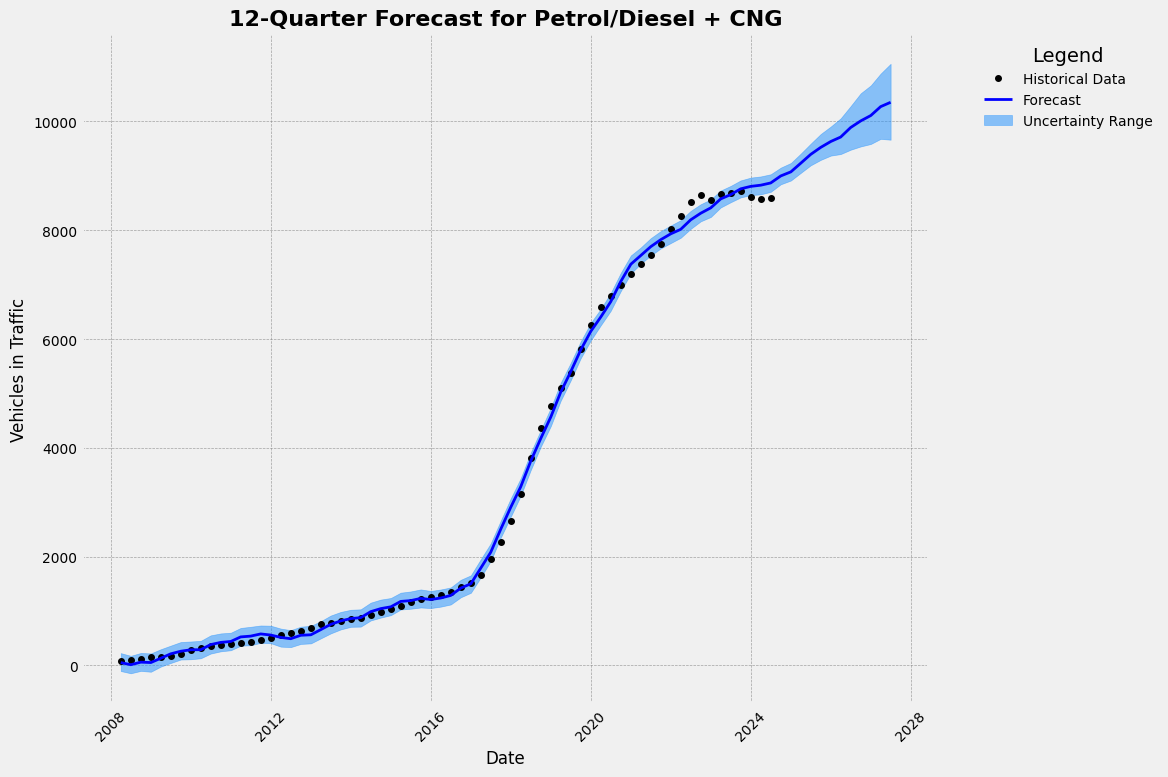

21:41:40 - cmdstanpy - INFO - Chain [1] start processing
21:41:40 - cmdstanpy - INFO - Chain [1] done processing


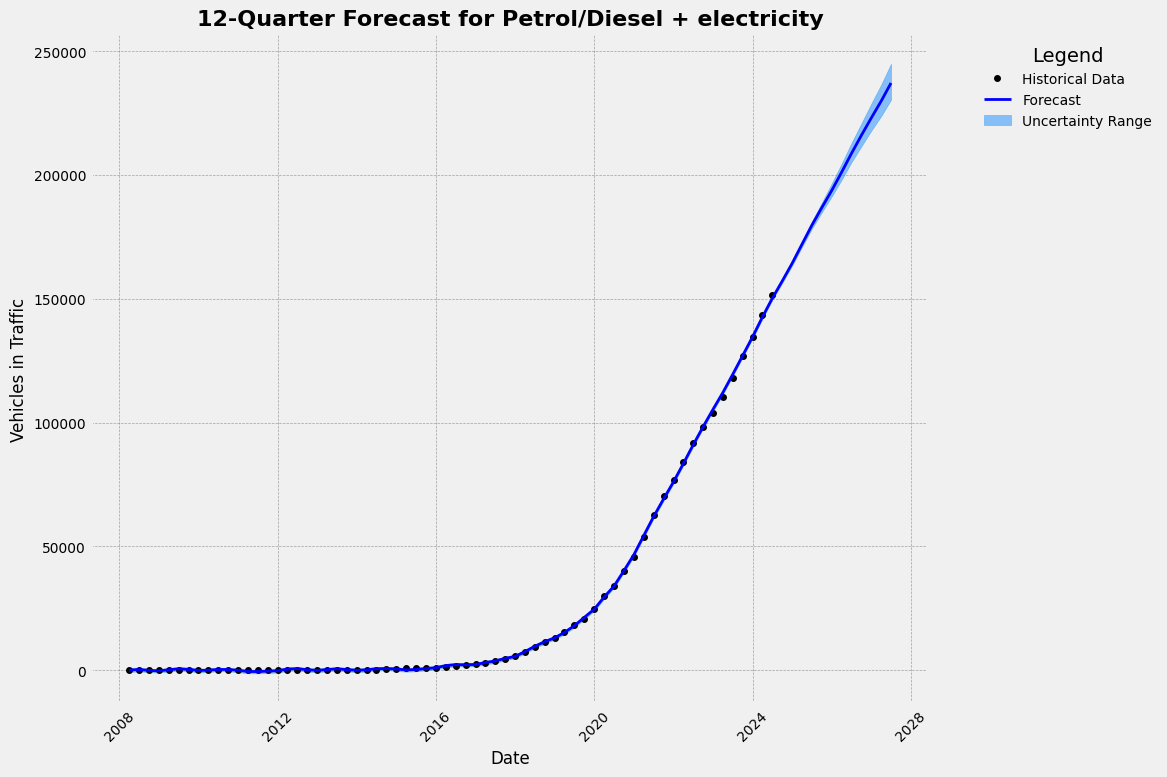

21:41:40 - cmdstanpy - INFO - Chain [1] start processing
21:41:41 - cmdstanpy - INFO - Chain [1] done processing


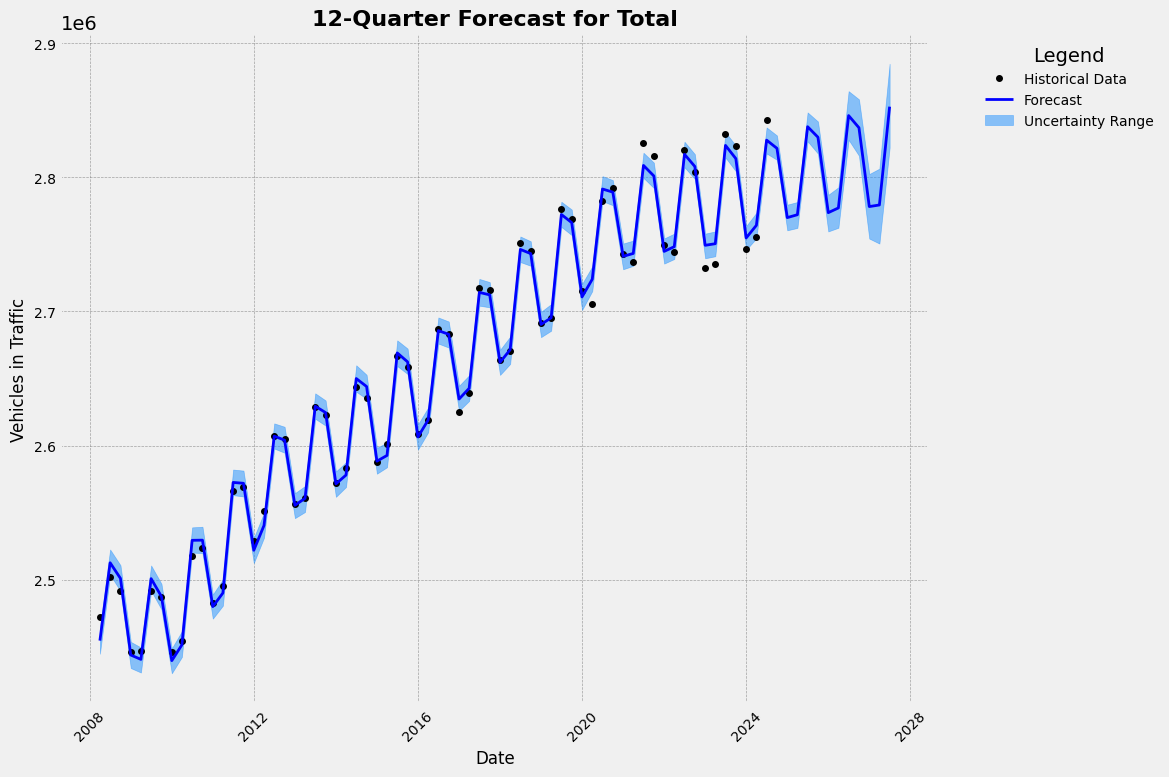

In [17]:
n = 12

vehicles = vehicle_classes.copy()

# Combine year and quarter into a datetime format
vehicles['Date'] = vehicles.apply(lambda row: helpers.get_last_day_of_quarter(row["year"], row["quarter"]), axis=1)

# Group by Date and Driving power, summing across all regions
grouped_data = vehicles.groupby(['Date', 'Driving power'])['Vehicles in traffic'].sum().reset_index()

# Function to forecast totals using Prophet
def forecast_vehicle_class(data, driving_power):
    # Prepare the dataframe for Prophet
    df_prophet = data[['Date', 'Vehicles in traffic']].rename(columns={'Date': 'ds', 'Vehicles in traffic': 'y'})
    
    # Create a Prophet model
    model = Prophet()
    model.fit(df_prophet)
    
    # Create future dates (forecast for next 12 quarters)
    future = model.make_future_dataframe(periods=n, freq='QE')
    
    # Forecast
    forecast = model.predict(future)
    
    with plt.style.context("fivethirtyeight"):
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot historical data as black points only
        ax.plot(df_prophet['ds'], df_prophet['y'], 'o', label='Historical Data', color='black', markersize=4)
        
        # Plot forecast mean as a line
        ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', linewidth=2, color='blue')
        
        # Plot the uncertainty range as a shaded area
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='dodgerblue', alpha=0.5, label='Uncertainty Range')

        # Set title, labels, and legend
        ax.set_title(f"{n}-Quarter Forecast for {driving_power}", fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Vehicles in Traffic', fontsize=12)
        
        # Position the legend to the right
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, frameon=False, title="Legend")
        
        # Adjust grid, tick sizes, and layout
        plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.xticks(fontsize=10, rotation=45)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

# Loop through each vehicle class and forecast
classes = grouped_data['Driving power'].unique()

for cl in classes:
    class_data = grouped_data[grouped_data['Driving power'] == cl]
    forecast_vehicle_class(class_data, cl)

The map file contains multiple layers. The relevant ones are:

- SuomenKuntajako_2024_10k = municipalities
- SuomenMaakuntajako_2024_10k = regions

`fiona.listlayers(maps)` for more information.

First, let's plot all public charging locations on the municipality layer.

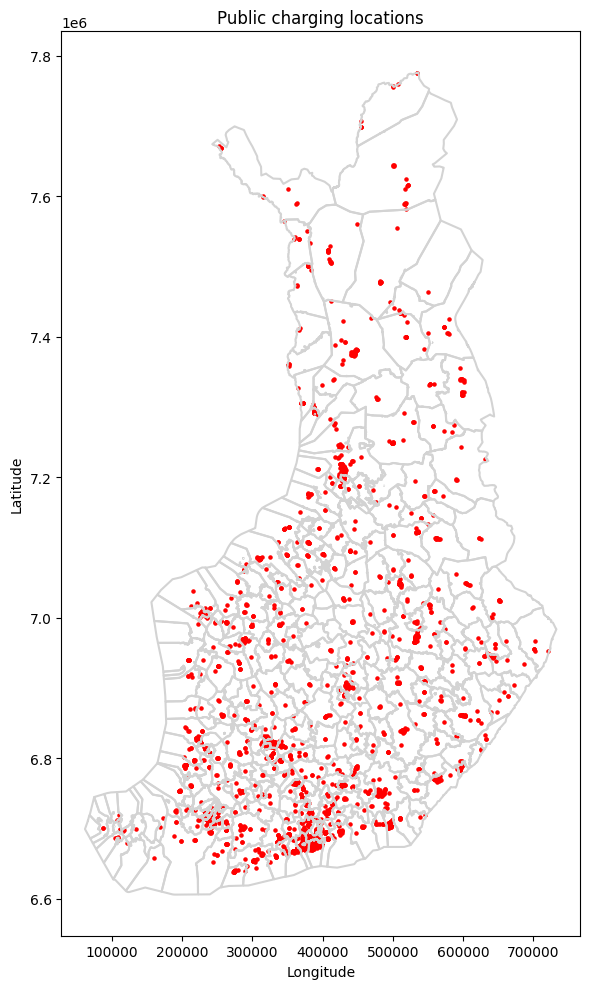

In [18]:
# Styling options
map_color = "lightgrey"
boundary_color = "black"
marker_color = "red"
marker_size = 5
legend_position = "upper left"

# Create geometry for locations
geometry = gpd.points_from_xy(locations["lon"], locations["lat"])
locations_gdf = gpd.GeoDataFrame(locations, geometry=geometry)
locations_gdf.set_crs("EPSG:4326", inplace=True)

# Read the map data
map_data = gpd.read_file(maps, layer="SuomenKuntajako_2024_10k")

# Ensure coordinate systems match
if map_data.crs != locations_gdf.crs:
    locations_gdf = locations_gdf.to_crs(map_data.crs)

# Plot the map with styled options
fig, ax = plt.subplots(figsize=(10, 10))
map_data.boundary.plot(ax=ax, color=map_color, edgecolor=boundary_color)
locations_gdf.plot(ax=ax, color=marker_color, markersize=marker_size, label="Charging locations")

# Additional styling
plt.title("Public charging locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.tight_layout()
plt.show()

Visually it seems like there are municipalities that have zero public charging locations. Let's find out which to study them closer:

Municipalities without charging locations:

- Alavieska (id: 009)
- Föglö (id: 062)
- Hammarland (id: 076)
- Hausjärvi (id: 086)
- Isojoki (id: 151)
- Kannonkoski (id: 216)
- Karstula (id: 226)
- Karvia (id: 230)
- Kaskinen (id: 231)
- Kinnula (id: 256)
- Kivijärvi (id: 265)
- Korsnäs (id: 280)
- Kumlinge (id: 295)
- Lemi (id: 416)
- Lumparland (id: 438)
- Merijärvi (id: 483)
- Miehikkälä (id: 489)
- Multia (id: 495)
- Myrskylä (id: 504)
- Nousiainen (id: 538)
- Oripää (id: 561)
- Pedersöre (id: 599)
- Pomarkku (id: 608)
- Ristijärvi (id: 697)
- Rääkkylä (id: 707)
- Saltvik (id: 736)
- Sottunga (id: 766)
- Vehmaa (id: 918)
- Ypäjä (id: 981)


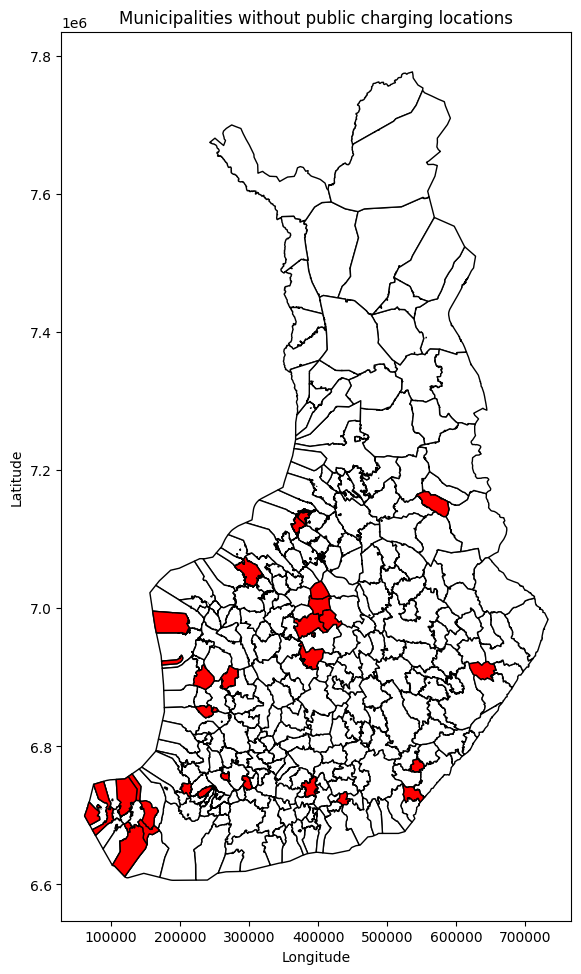

In [19]:
municipalities = mappings.copy()

municipalities_without_locations = mappings.merge(
    locations, on="municipality_id", how="left", indicator=True
).query('_merge == "left_only"')

municipalities_without_locations_ids = municipalities_without_locations["municipality_id"].astype(str).str.zfill(3)
municipalities_without_locations_names = municipalities_without_locations["municipality_en"]

print("Municipalities without charging locations:\n")
for name, muni_id in zip(municipalities_without_locations_names, municipalities_without_locations_ids):
    print(f"- {name} (id: {muni_id})")

filtered_map_data = map_data[map_data["NATCODE"].isin(municipalities_without_locations_ids)]

# Plot the map with highlighted municipalities
fig, ax = plt.subplots(figsize=(10, 10))
map_data.plot(ax=ax, color="white", edgecolor="black")
filtered_map_data.plot(ax=ax, color='red', edgecolor="black")

plt.title("Municipalities without public charging locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.tight_layout()
plt.show()

plt.show()

Åland (Ahvenanmaa) in the Southwest corner of the map is not included in all datasets so we leave it out of the analysis. Åland municipalities without charging stations are:

In [20]:
print("Municipalities without charging locations:\n")
for name, id in zip(municipalities_without_locations_names, municipalities_without_locations_ids):
    if helpers.get_rid_by_mid(int(id), mappings) == 21:
        print(f"- {name} (id: {id})")

Municipalities without charging locations:

- Föglö (id: 062)
- Hammarland (id: 076)
- Kumlinge (id: 295)
- Lumparland (id: 438)
- Saltvik (id: 736)
- Sottunga (id: 766)


How the municipalities with the least amount of charging stations are doing in terms of EV adoption?

In [21]:
evs[evs["municipality_id"].isin([int(i) for i in municipalities_without_locations_ids])]

Rank EV      Municipality                  Make  Total Total  \
50        51        Nousiainen  Passenger cars total         3077   
61        62         Hausjärvi  Passenger cars total         5004   
112      113          Myrskylä  Passenger cars total         1126   
122      123              Lemi  Passenger cars total         1876   
134      135  Pedersören kunta  Passenger cars total         6948   
145      146       Kannonkoski  Passenger cars total          787   
162      163           Korsnäs  Passenger cars total         1302   
165      166          Kaskinen  Passenger cars total          721   
170      171             Ypäjä  Passenger cars total         1484   
173      174         Alavieska  Passenger cars total         1493   
177      178          Rääkkylä  Passenger cars total         1274   
181      182          Pomarkku  Passenger cars total         1219   
187      188            Karvia  Passenger cars total         1514   
204      205         Merijärvi  Passenger cars total          557   
207      208            Vehmaa  Passenger cars total         1474   
217      218            Oripää  Passenger cars total          894   
241      242        Miehikkälä  Passenger cars total         1204   
242      243            Multia  Passenger cars total          872   
268      269          Karstula  Passenger cars total         2313   
277      278           Isojoki  Passenger cars total         1247   
287      288         Kivijärvi  Passenger cars total          600   
288      289           Kinnula  Passenger cars total          886   
289      290        Ristijärvi  Passenger cars total          762   

     Total Electricity  Total Petrol/Electricity (plug-in hybrid)  \
50                  94                                        143   
61                 141                                        169   
112                 24                                         27   
122                 38                                         55   
134                129                                        247   
145                 14                                         21   
162                 22                                         30   
165                 12                                         25   
170                 24                                         39   
173                 24                                         38   
177                 20                                         26   
181                 19                                         20   
187                 23                                         28   
204                  8                                          8   
207                 21                                         38   
217                 12                                         30   
241                 14                                         24   
242                 10                                         20   
268                 19                                         32   
277                  8                                         16   
287                  3                                          3   
288                  4                                          8   
289                  3                                          7   

     Total Diesel/Electricity (plug-in hybrid)  Hybrid Share (%)  \
50                                           8          4.907377   
61                                          15          3.677058   
112                                          0          2.397869   
122                                          0          2.931770   
134                                         20          3.842832   
145                                          0          2.668361   
162                                          1          2.380952   
165                                          1          3.606103   
170                                          3          2.830189   
173        

In [22]:
# For the blog article

helpers.df_to_markdown(evs[evs["municipality_id"].isin([int(i) for i in municipalities_without_locations_ids])].sort_values("Rank EV", ascending=True).head(20), ["Municipality", "Rank EV", "EV Share (%)", "Hybrid Share (%)"])

| Municipality     |   Rank EV |   EV Share (%) |   Hybrid Share (%) |
|:-----------------|----------:|---------------:|-------------------:|
| Nousiainen       |        51 |       3.05492  |            4.90738 |
| Hausjärvi        |        62 |       2.81775  |            3.67706 |
| Myrskylä         |       113 |       2.13144  |            2.39787 |
| Lemi             |       123 |       2.02559  |            2.93177 |
| Pedersören kunta |       135 |       1.85665  |            3.84283 |
| Kannonkoski      |       146 |       1.77891  |            2.66836 |
| Korsnäs          |       163 |       1.68971  |            2.38095 |
| Kaskinen         |       166 |       1.66436  |            3.6061  |
| Ypäjä            |       171 |       1.61725  |            2.83019 |
| Alavieska        |       174 |       1.6075   |            2.74615 |
| Rääkkylä         |       178 |       1.56986  |            2.04082 |
| Pomarkku         |       182 |       1.55865  |            1.80476 |
| Karv

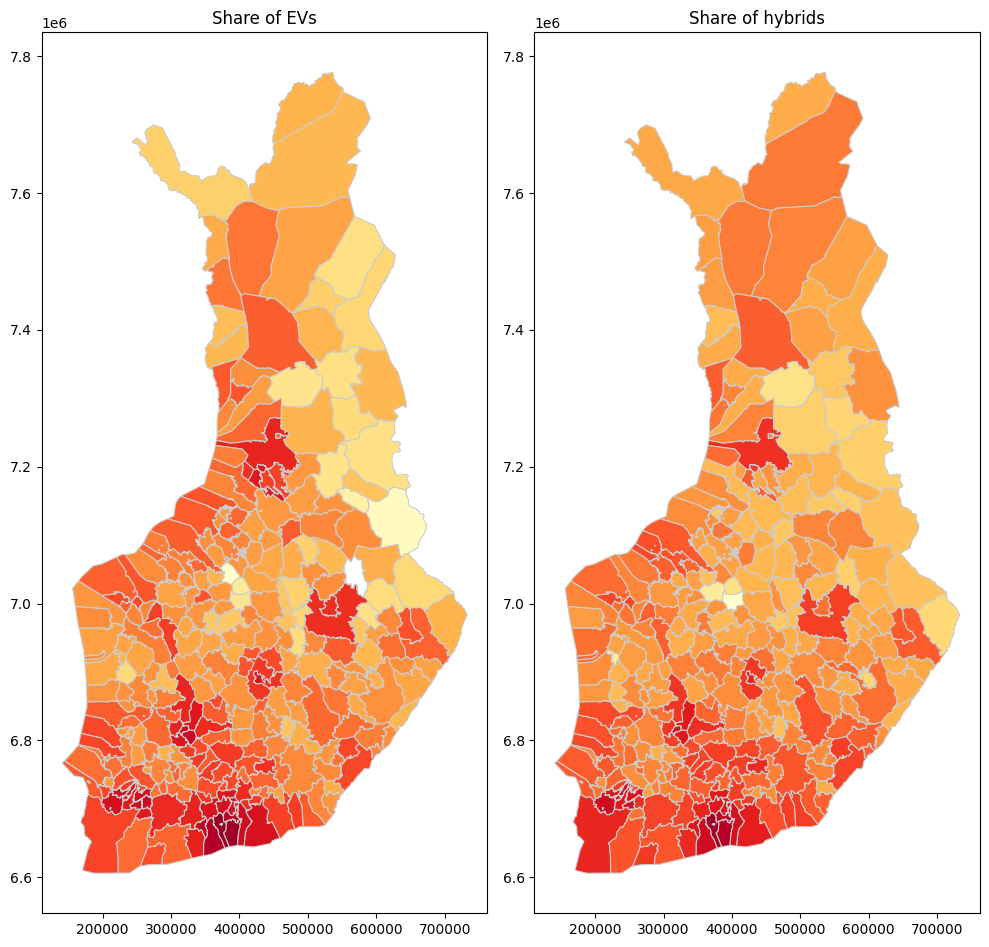

In [23]:
ev_data = ev_snapshot.copy()

ev_data["municipality_id"] = ev_data["municipality_id"].astype(str).str.zfill(3)

merged_map_data_evs = map_data.merge(ev_data[["municipality_id", "EV Share (%)"]], left_on="NATCODE", right_on="municipality_id", how="left")
merged_map_data_hybrids = map_data.merge(ev_data[["municipality_id", "Hybrid Share (%)"]], left_on="NATCODE", right_on="municipality_id", how="left")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

merged_map_data_evs.plot(column="EV Share (%)", cmap="YlOrRd", linewidth=0.8, ax=ax1, edgecolor='0.8', norm=LogNorm())
ax1.set_title("Share of EVs")

merged_map_data_hybrids.plot(column="Hybrid Share (%)", cmap="YlOrRd", linewidth=0.8, ax=ax2, edgecolor='0.8', norm=LogNorm())
ax2.set_title("Share of hybrids")

fig.tight_layout()

plt.show()

Here's an alternative way (a bivariate choropleth map) to visualize the correlation between the EV and hybrid distribution in one chart. Needs to adjusted to make it pretty. Also Åland should be ignored.

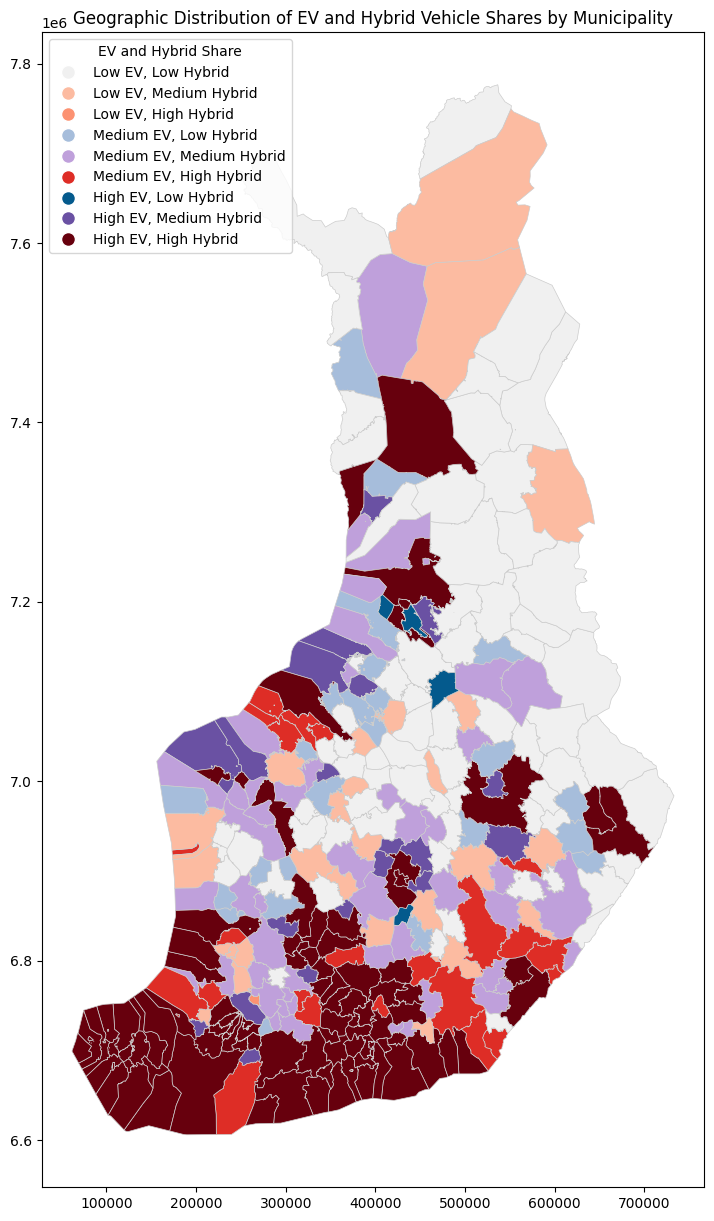

In [24]:
merged_map_data = map_data.merge(ev_data[["municipality_id", "EV Share (%)", "Hybrid Share (%)"]], 
                                 left_on="NATCODE", right_on="municipality_id", how="left")

ev_thresholds = [merged_map_data["EV Share (%)"].quantile(0.33), merged_map_data["EV Share (%)"].quantile(0.66)]
hybrid_thresholds = [merged_map_data["Hybrid Share (%)"].quantile(0.33), merged_map_data["Hybrid Share (%)"].quantile(0.66)]

def bivariate_color(ev_share, hybrid_share):
    if ev_share <= ev_thresholds[0]:
        if hybrid_share <= hybrid_thresholds[0]:
            return "#f0f0f0"  # Low EV, Low Hybrid
        elif hybrid_share <= hybrid_thresholds[1]:
            return "#fcbba1"  # Low EV, Medium Hybrid
        else:
            return "#fc9272"  # Low EV, High Hybrid
    elif ev_share <= ev_thresholds[1]:
        if hybrid_share <= hybrid_thresholds[0]:
            return "#a6bddb"  # Medium EV, Low Hybrid
        elif hybrid_share <= hybrid_thresholds[1]:
            return "#bfa0db"  # Medium EV, Medium Hybrid
        else:
            return "#de2d26"  # Medium EV, High Hybrid
    else:
        if hybrid_share <= hybrid_thresholds[0]:
            return "#045a8d"  # High EV, Low Hybrid
        elif hybrid_share <= hybrid_thresholds[1]:
            return "#6a51a3"  # High EV, Medium Hybrid
        else:
            return "#67000d"  # High EV, High Hybrid

merged_map_data["bivariate_color"] = merged_map_data.apply(
    lambda row: bivariate_color(row["EV Share (%)"], row["Hybrid Share (%)"]), axis=1
)

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
merged_map_data.plot(color=merged_map_data["bivariate_color"], linewidth=0.5, edgecolor="0.8", ax=ax)
ax.set_title("Geographic Distribution of EV and Hybrid Vehicle Shares by Municipality")

# Custom Legend for Bivariate Colors
legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", label="Low EV, Low Hybrid", markerfacecolor="#f0f0f0", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="Low EV, Medium Hybrid", markerfacecolor="#fcbba1", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="Low EV, High Hybrid", markerfacecolor="#fc9272", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="Medium EV, Low Hybrid", markerfacecolor="#a6bddb", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="Medium EV, Medium Hybrid", markerfacecolor="#bfa0db", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="Medium EV, High Hybrid", markerfacecolor="#de2d26", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="High EV, Low Hybrid", markerfacecolor="#045a8d", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="High EV, Medium Hybrid", markerfacecolor="#6a51a3", markersize=10),
    plt.Line2D([0], [0], marker="o", color="w", label="High EV, High Hybrid", markerfacecolor="#67000d", markersize=10)
]
ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(0, 1), title="EV and Hybrid Share")

plt.show()

In [25]:
socio_r = socio_whole_country_and_regions.copy()
socio_m = socio_all_municipalities.copy()

Validating the datasets have the same information categories.

In [26]:
if socio_r['Information'].unique().sort() == socio_m['Information'].unique().sort():
    print("Information categories match between regions and municipalities!")
else:
    print("Information categories do not match between regions and municipalities!")

Information categories match between regions and municipalities!


Plot the EV adoption growth per region. This we unfortunately can't do with the municipalities due to the lack of data.

Note: the code needs changes when new quarters are added to the dataset.

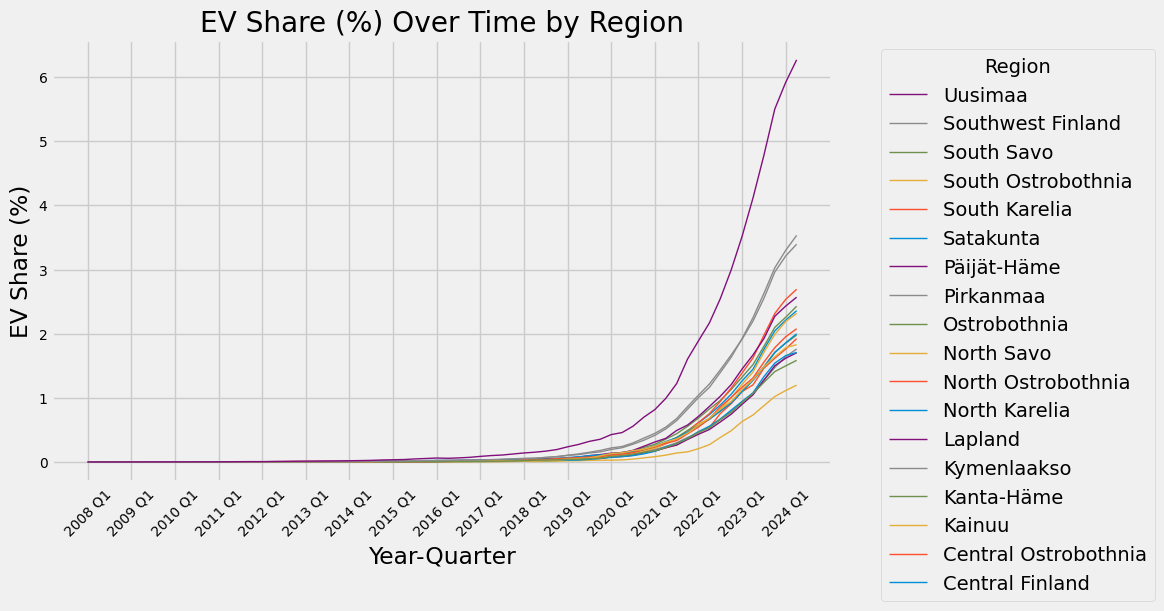

In [27]:
ev_quarterly = vehicle_classes.copy()

ev_quarterly = ev_quarterly[(ev_quarterly["year"] >= 2008) & 
                            ((ev_quarterly["year"] < 2024) | 
                            ((ev_quarterly["year"] == 2024) & (ev_quarterly["quarter"] <= 2)))]
ev_quarterly = ev_quarterly.groupby(["Region", "region_id", "Driving power", "year", "quarter"])["Vehicles in traffic"].sum().reset_index()

results = []

# Note: Including quarters only up to Q2 for 2024

for region in ev_quarterly["Region"].unique():
    for year in range(2008, 2025):
        quarters = range(1, 5) if year < 2024 else range(1, 3)
        for quarter in quarters:
            total_vehicles = ev_quarterly[(ev_quarterly["Region"] == region) & (ev_quarterly["year"] == year) & 
                                  (ev_quarterly["quarter"] == quarter) & 
                                  (ev_quarterly["Driving power"] == "Total")]["Vehicles in traffic"].sum()
            
            ev_vehicles = ev_quarterly[(ev_quarterly["Region"] == region) & (ev_quarterly["year"] == year) & 
                                       (ev_quarterly["quarter"] == quarter) & 
                                       (ev_quarterly["Driving power"] == "Electricity")]["Vehicles in traffic"].sum()

            if total_vehicles > 0:
                ev_share = (ev_vehicles / total_vehicles) * 100
            else:
                ev_share = 0

            region_id = ev_quarterly[ev_quarterly["Region"] == region]["region_id"].values[0]

            results.append({"Region": region, "region_id": region_id, "Year": year, "Quarter": quarter, "EV Share (%)": ev_share})

ev_quarterly = pd.DataFrame(results)

ev_quarterly["Year-Quarter"] = ev_quarterly["Year"].astype(str) + " Q" + ev_quarterly["Quarter"].astype(str)

helpers.draw_line_chart(
    ev_quarterly, 
    index="Year-Quarter", 
    columns="Region", 
    values="EV Share (%)", 
    title="EV Share (%) Over Time by Region", 
    xlabel="Year-Quarter",
    ylabel="EV Share (%)", 
    legend_title="Region",
    style="fivethirtyeight",
    tick_frequency=4
)

It is clear that the adoption has started at different times in different regions.

Let's analyze the growth trajectories by trying to plot them on the same graph starting from the quarter when the adoption rate exceeded a certain threshold. 

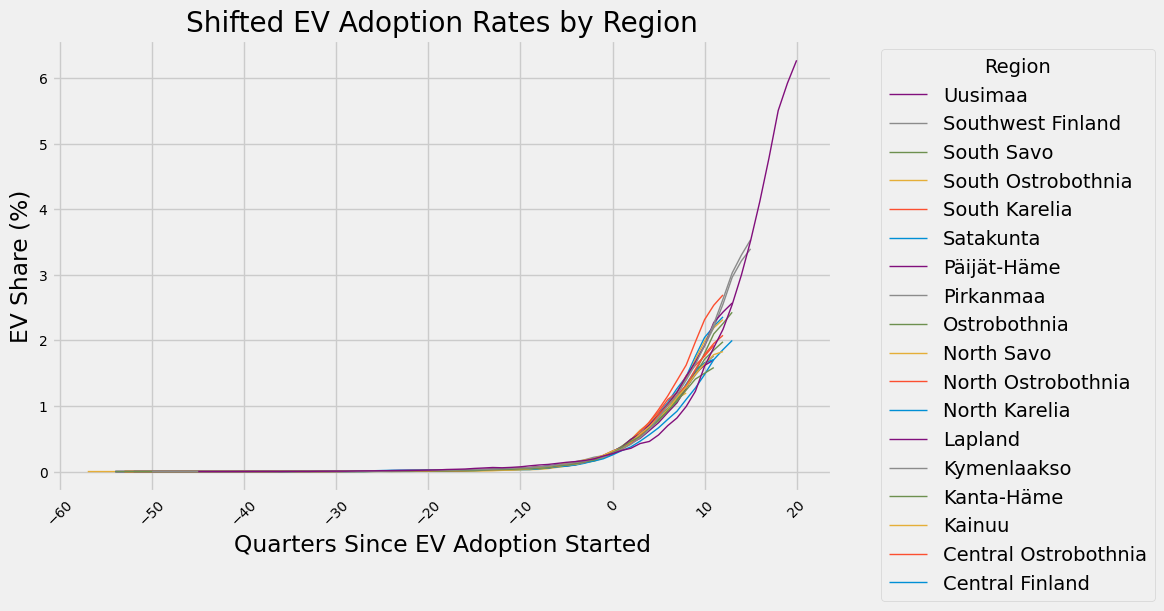

In [28]:
def shift_adoption_start_with_threshold_quarterly(df, region_col, year_col, quarter_col, value_col, threshold=0.01):
    shifted_data = pd.DataFrame()

    for region in df[region_col].unique():
        region_data = df[df[region_col] == region].copy()
        
        first_significant_entry = region_data[region_data[value_col] > threshold].iloc[0]
        first_year = first_significant_entry[year_col]
        first_quarter = first_significant_entry[quarter_col]
        
        region_data["Shifted Quarters"] = ((region_data[year_col] - first_year) * 4 + 
                                           (region_data[quarter_col] - first_quarter))

        # Append the shifted data
        shifted_data = pd.concat([shifted_data, region_data])

    return shifted_data

shifted_quarterly = shift_adoption_start_with_threshold_quarterly(ev_quarterly, 'Region', 'Year', 'Quarter', 'EV Share (%)', threshold=0.25)

helpers.draw_line_chart(
    shifted_quarterly, 
    index="Shifted Quarters", 
    columns="Region", 
    values="EV Share (%)", 
    title="Shifted EV Adoption Rates by Region", 
    xlabel="Quarters Since EV Adoption Started",
    ylabel="EV Share (%)", 
    legend_title="Region",
    style="fivethirtyeight")

And the same on an annual basis.

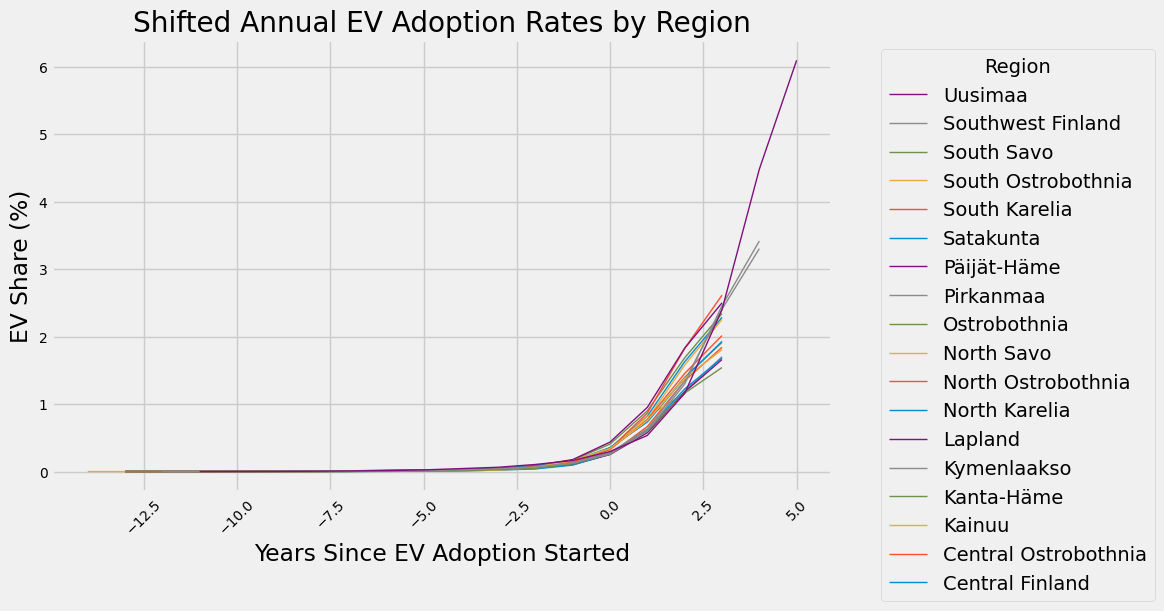

In [29]:
def shift_adoption_start_with_threshold_annual(df, region_col, year_col, value_col, threshold=0.01):
    shifted_data = pd.DataFrame()

    for region in df[region_col].unique():
        region_data = df[df[region_col] == region].copy()
        
        # Find the first year where EV share exceeds the threshold
        first_significant_entry = region_data[region_data[value_col] > threshold].iloc[0]
        first_year = first_significant_entry[year_col]
        
        # Calculate the shifted years based on the first significant year
        region_data["Shifted Years"] = region_data[year_col] - first_year

        # Append the shifted data
        shifted_data = pd.concat([shifted_data, region_data])

    return shifted_data

# Aggregate the quarterly data to annual data before shifting
ev_annual = ev_quarterly.groupby(['Region', 'Year'])['EV Share (%)'].mean().reset_index()

# Apply the annual shift function
shifted_annual = shift_adoption_start_with_threshold_annual(ev_annual, 'Region', 'Year', 'EV Share (%)', threshold=0.25)

# Plot the shifted annual data
helpers.draw_line_chart(
    shifted_annual, 
    index='Shifted Years', 
    columns='Region', 
    values='EV Share (%)', 
    title='Shifted Annual EV Adoption Rates by Region', 
    xlabel='Years Since EV Adoption Started', 
    ylabel='EV Share (%)', 
    legend_title='Region',
    style="fivethirtyeight"
)

The potential clusters are easier to see in the annual chart.

Let's see if we can group the regions into 3-5 clusters based on the growth trajectories, using both quarterly and annual data. First quarterly:

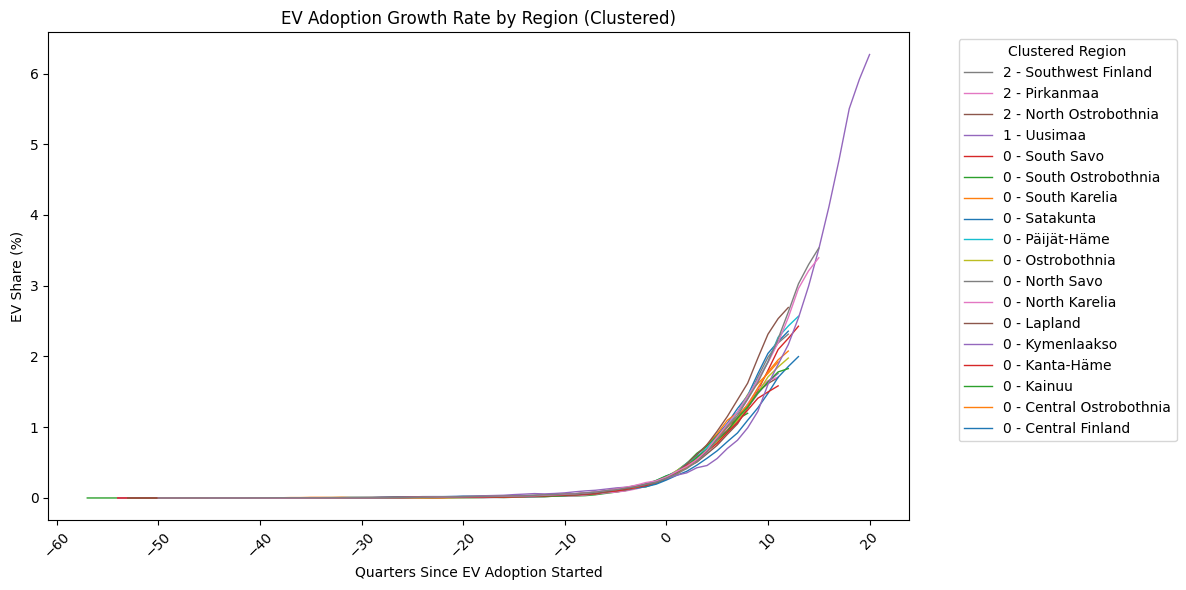

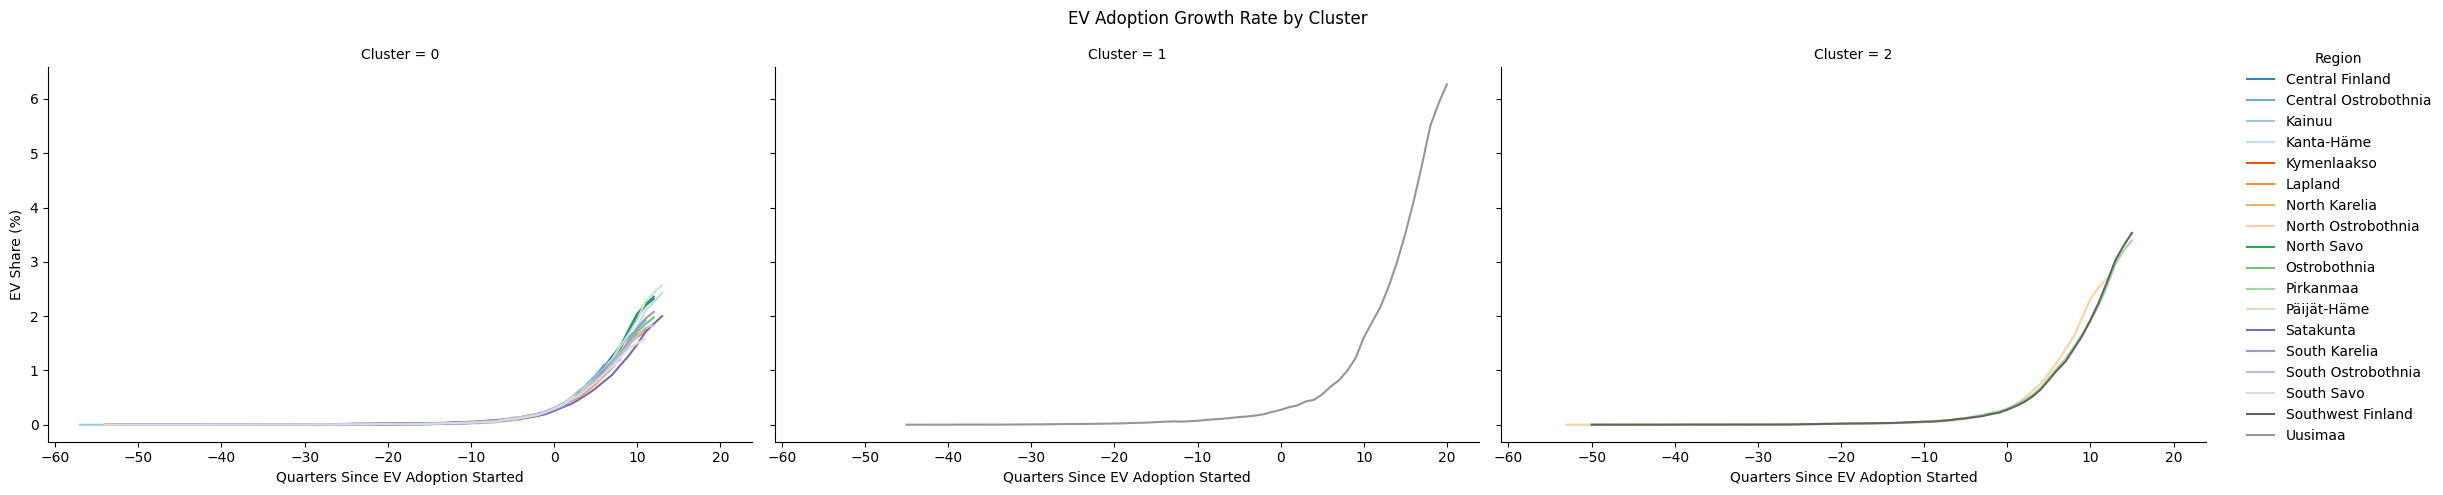

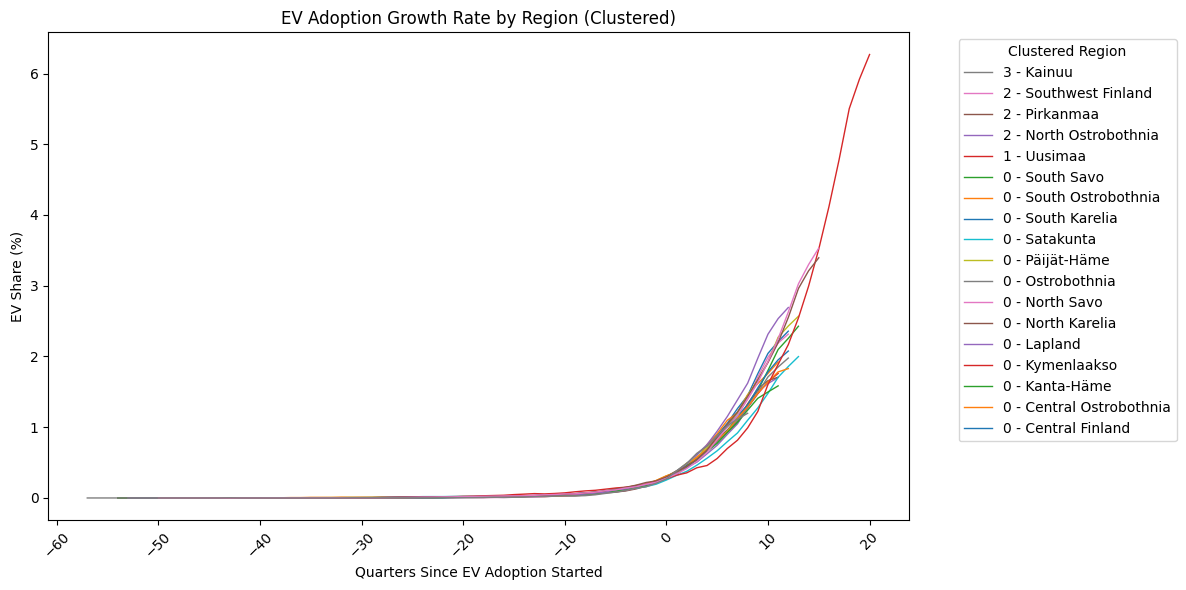

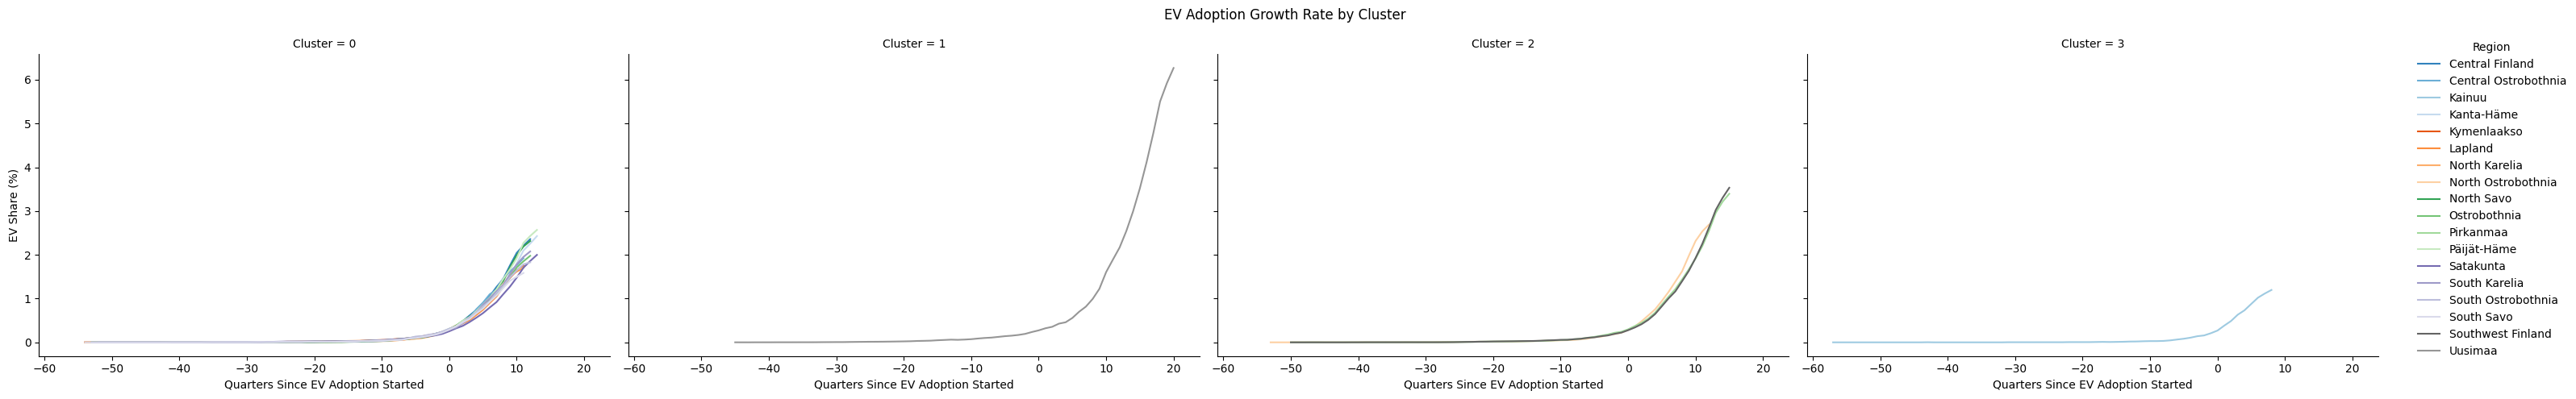

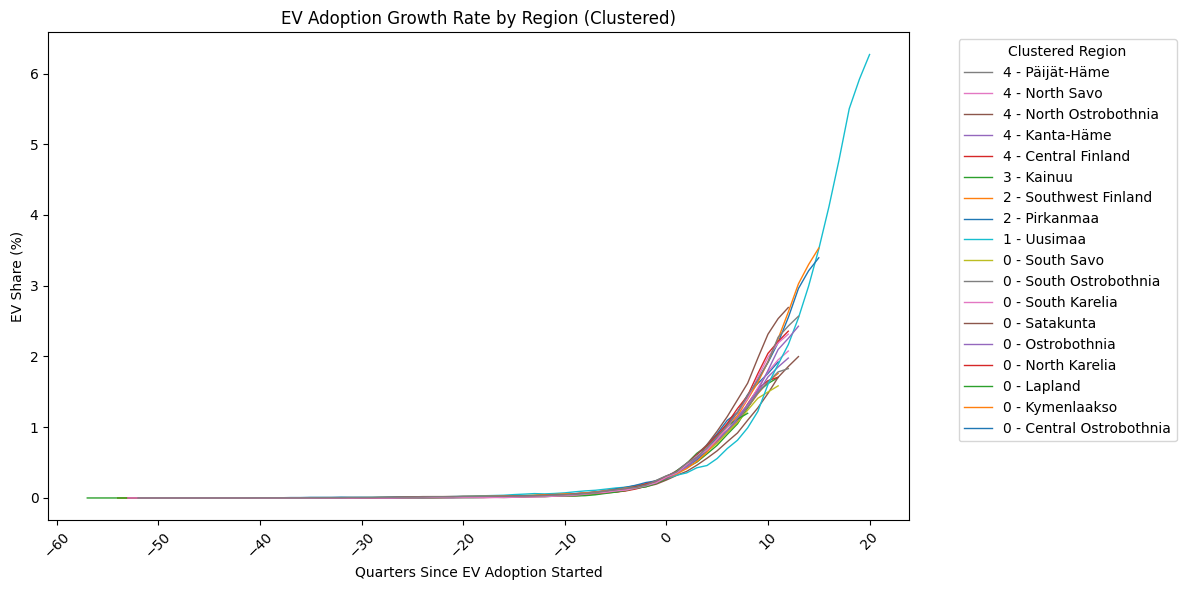

In [30]:
def cluster_quarterly(data, n_clusters):
    data = data.copy()

    growth_rate_data = data.pivot(index="Region", columns="Shifted Quarters", values="EV Share (%)").fillna(0).values

    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=0)
   
    clusters = model.fit_predict(growth_rate_data)
   
    region_clusters = dict(zip(data["Region"].unique(), clusters))

    data["Cluster"] = data["Region"].map(region_clusters)

    data["Clustered Region"] = data['Cluster'].astype(str) + " - " + data["Region"]

    return data

def plot_quarterly(data):
    helpers.draw_line_chart(
        data,
        index='Shifted Quarters',
        columns='Clustered Region',
        values='EV Share (%)',
        title='EV Adoption Growth Rate by Region (Clustered)',
        xlabel='Quarters Since EV Adoption Started',
        ylabel='EV Share (%)',
        legend_title='Clustered Region'
    )

    helpers.draw_facetgrid(
        data=data,
        col='Cluster',
        hue='Region',
        x='Shifted Quarters',
        y='EV Share (%)',
        title='EV Adoption Growth Rate by Cluster',
        xlabel='Quarters Since EV Adoption Started',
        ylabel='EV Share (%)',
        legend_title='Region'
    )

q3 = cluster_quarterly(shifted_quarterly, n_clusters=3)
plot_quarterly(q3)

q4 = cluster_quarterly(shifted_quarterly, n_clusters=4)
plot_quarterly(q4)

q5 = cluster_quarterly(shifted_quarterly, n_clusters=5)
plot_quarterly(q5)

The same based on the annual data:

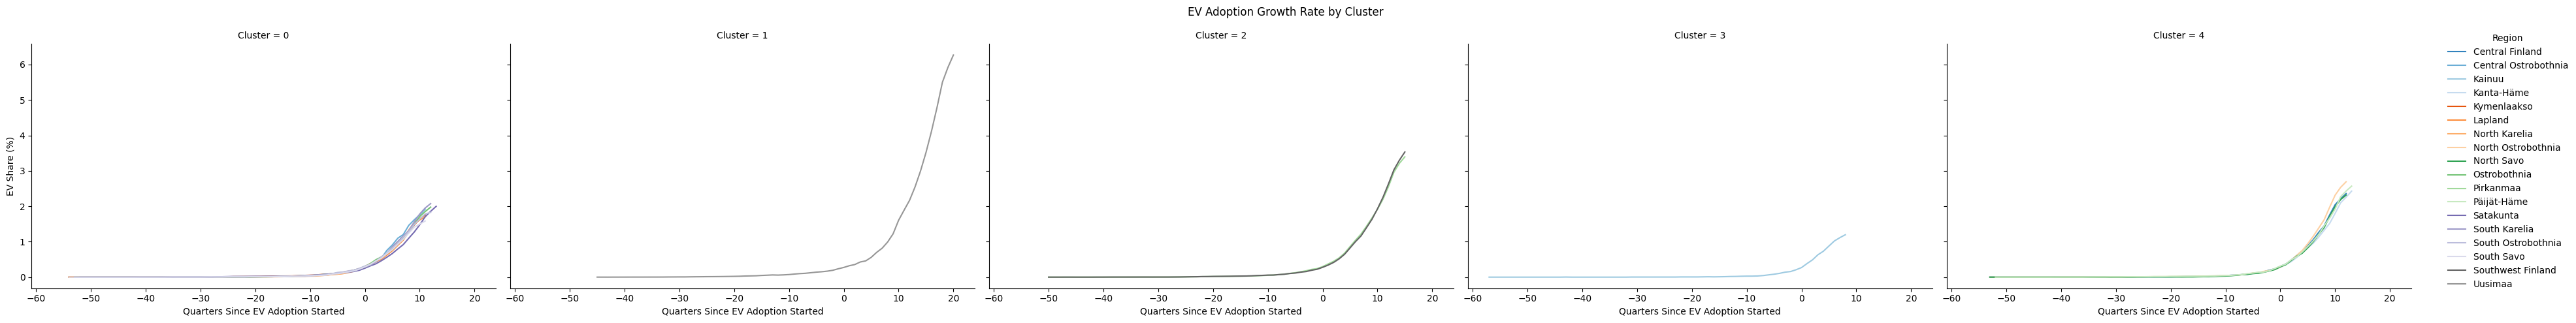

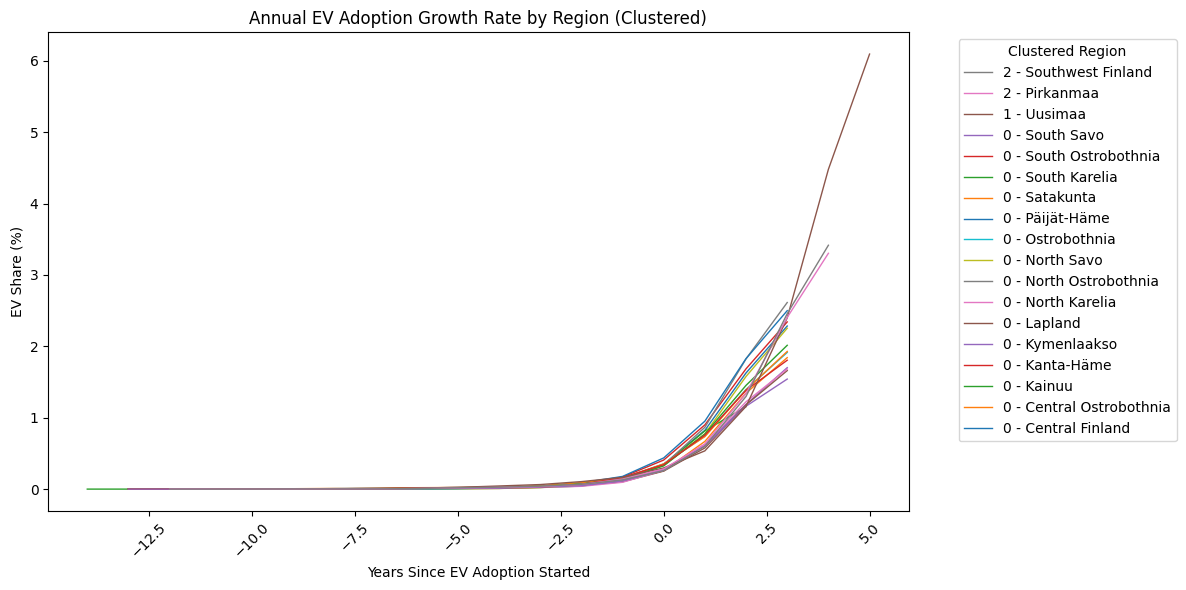

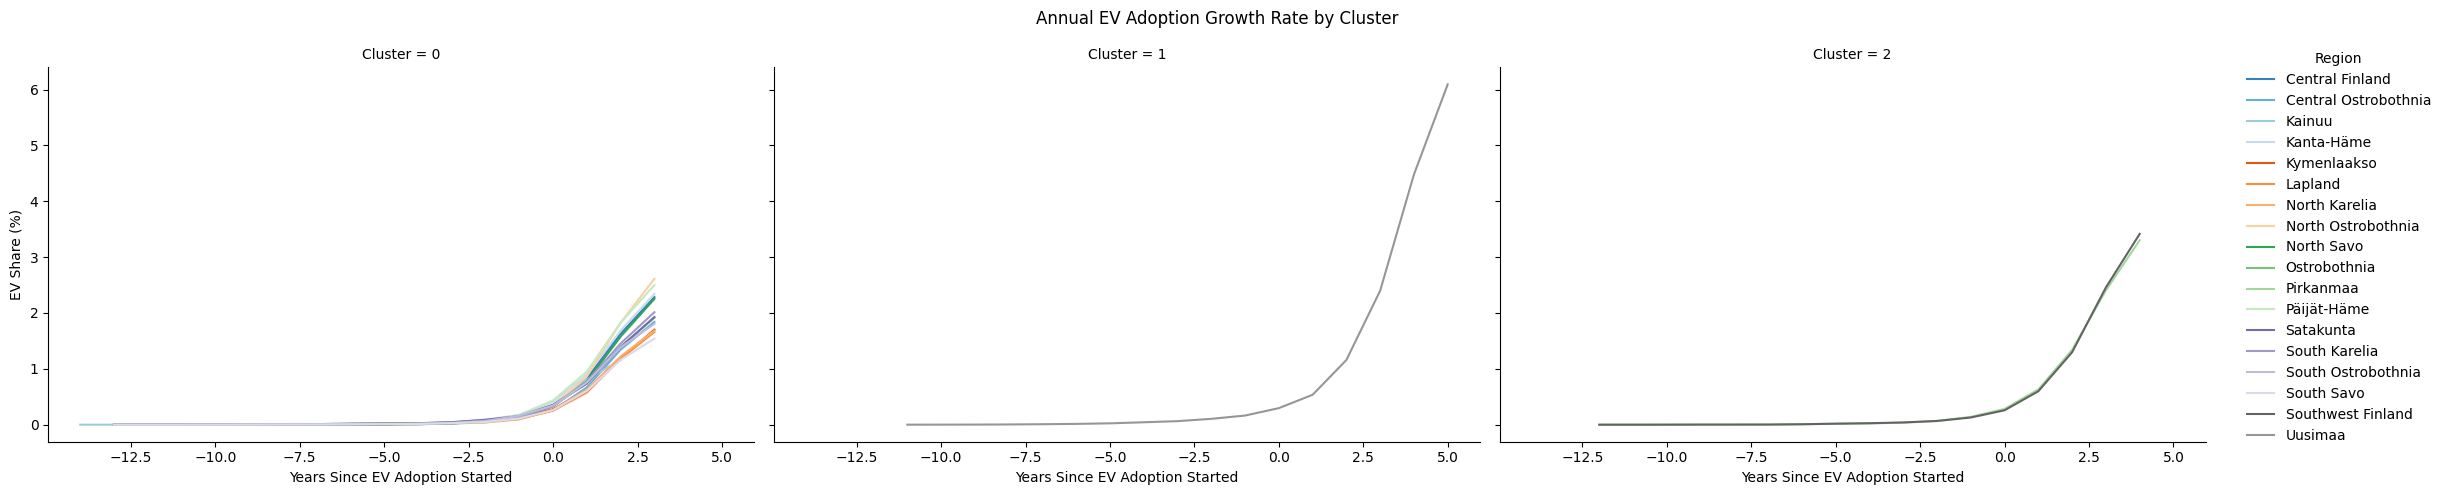

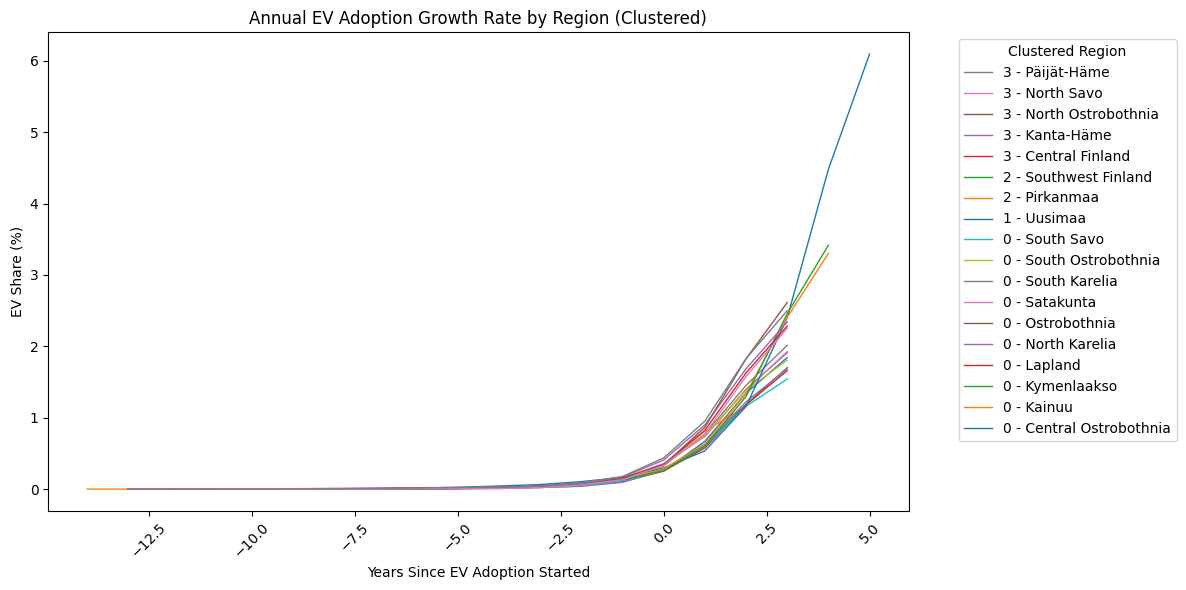

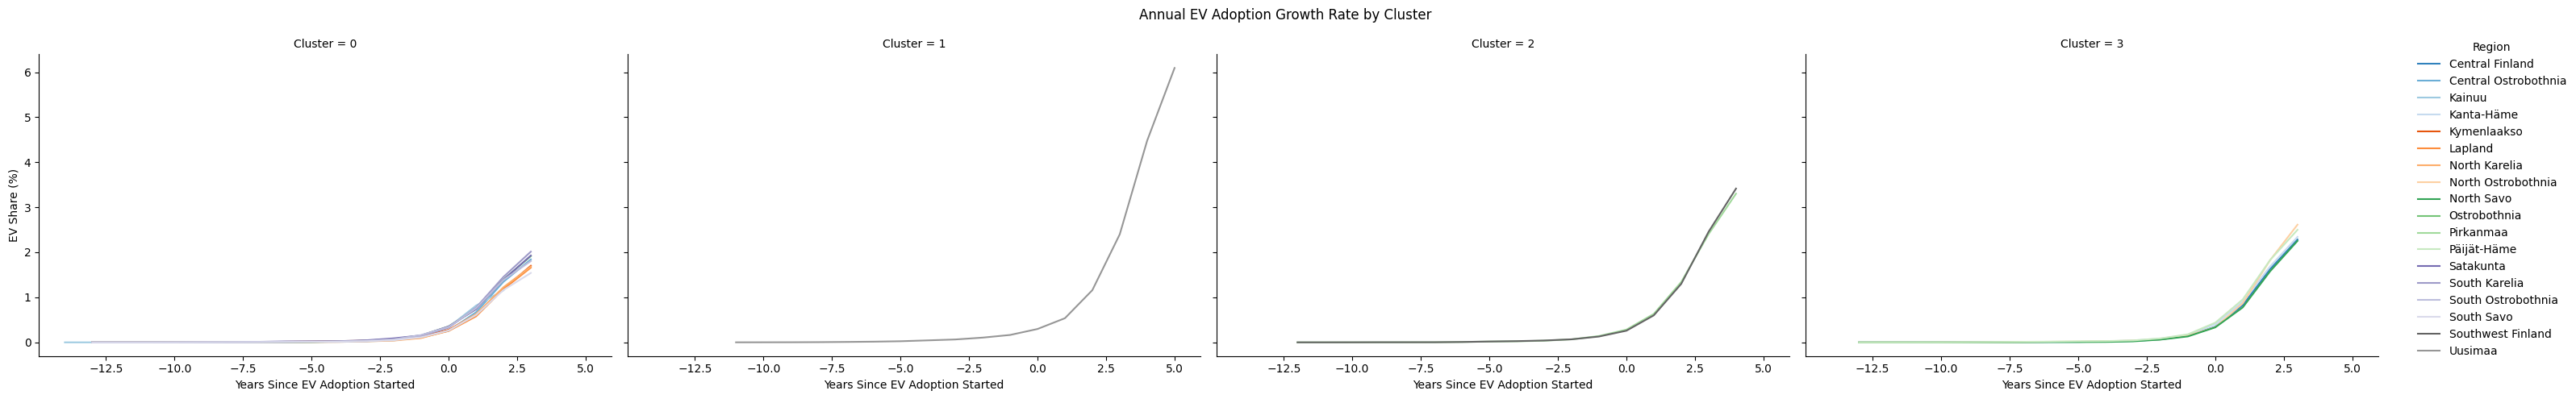

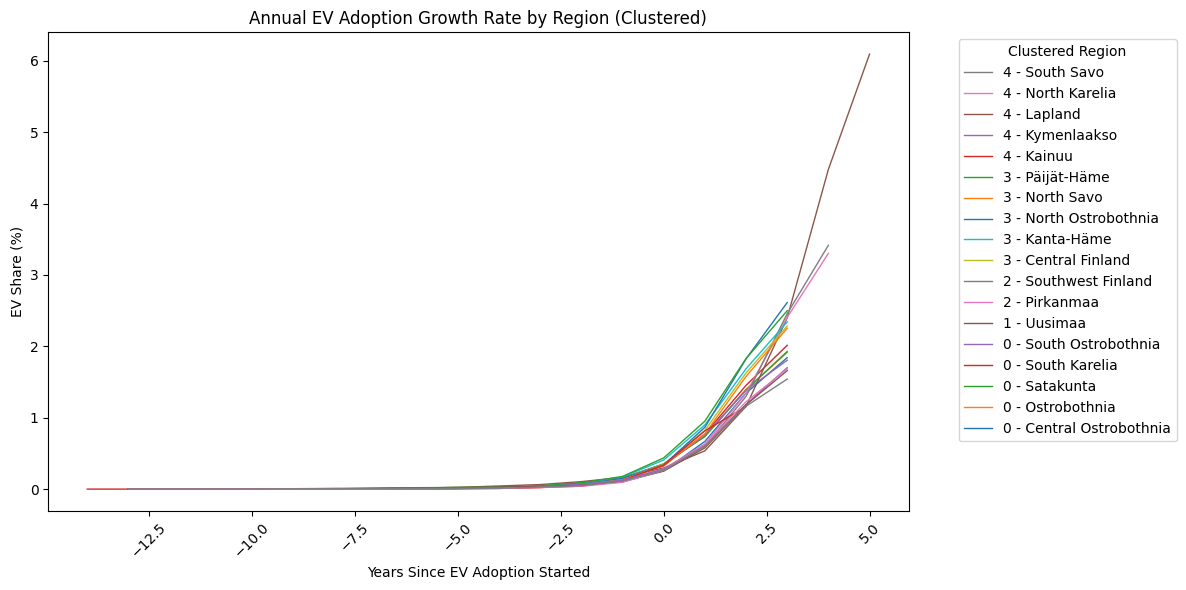

In [31]:
def cluster_annual(data, n_clusters):
    data = data.copy()

    # Pivot the DataFrame to get the growth rate data for each region
    growth_rate_data = data.pivot(index="Region", columns="Shifted Years", values="EV Share (%)").fillna(0).values

    # Perform clustering using DTW (or any other metric you prefer)
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=0)
    clusters = model.fit_predict(growth_rate_data)

    # Map clusters back to the original DataFrame using the Region as a key
    region_clusters = dict(zip(data["Region"].unique(), clusters))
    data["Cluster"] = data["Region"].map(region_clusters)

    # Create a 'Clustered Region' label for each region in its respective cluster
    data["Clustered Region"] = data['Cluster'].astype(str) + " - " + data["Region"]

    return data

def plot_annual(data):
    # Plot using helpers.draw_line_chart
    helpers.draw_line_chart(
        data,
        index='Shifted Years',  # x-axis column for annual data
        columns='Clustered Region',
        values='EV Share (%)',
        title='Annual EV Adoption Growth Rate by Region (Clustered)',
        xlabel='Years Since EV Adoption Started',
        ylabel='EV Share (%)',
        legend_title='Clustered Region'
    )

    # Plot using helpers.draw_facetgrid
    helpers.draw_facetgrid(
        data=data,
        col='Cluster',
        hue='Region',
        x='Shifted Years',
        y='EV Share (%)',
        title='Annual EV Adoption Growth Rate by Cluster',
        xlabel='Years Since EV Adoption Started',
        ylabel='EV Share (%)',
        legend_title='Region'
    )

a3 = cluster_annual(shifted_annual, n_clusters=3)
plot_annual(a3)

a4 = cluster_annual(shifted_annual, n_clusters=4)
plot_annual(a4)

a5 = cluster_annual(shifted_annual, n_clusters=5)
plot_annual(a5)

The quarterly clusters are not very balanced. The annual clustering (n=5) seems the best way to go.

In [32]:
region_clusters = a5.copy()

region_clusters.head(5)

Region  Year  EV Share (%)  Shifted Years  Cluster  \
0  Central Finland  2008      0.000000            -13        3   
1  Central Finland  2009      0.000000            -12        3   
2  Central Finland  2010      0.000000            -11        3   
3  Central Finland  2011      0.000580            -10        3   
4  Central Finland  2012      0.001148             -9        3   

      Clustered Region  
0  3 - Central Finland  
1  3 - Central Finland  
2  3 - Central Finland  
3  3 - Central Finland  
4  3 - Central Finland

Calculate means for each cluster.

In [33]:
unique_region_clusters = region_clusters[['Region', 'Cluster']].drop_duplicates()

socio_clustered_means = pd.merge(socio_r, region_clusters[["Region", "Cluster"]].drop_duplicates(), on="Region", how="left")
socio_clustered_means = socio_clustered_means.groupby(["Cluster", "Information"])[socio_clustered_means.loc[:, "2008":"2023"].columns].mean().reset_index()

ev_share = region_clusters.groupby(["Cluster", "Year"])["EV Share (%)"].mean().unstack().reset_index()
ev_share.columns = ["Cluster"] + [str(year) for year in ev_share.columns[1:]]
ev_share["Information"] = "EV Share (%)"
ev_share = ev_share[["Cluster", "Information"] + [str(year) for year in range(2008, 2024)]]

socio_clustered_means_with_ev = pd.concat([socio_clustered_means, ev_share], ignore_index=True)
socio_clustered_means_with_ev["Cluster"] = socio_clustered_means_with_ev["Cluster"].astype("Int64")

socio_clustered_means_with_ev

Cluster                                        Information       2008  \
0          0                      Average age of the population  42.280000   
1          0                 Average age of the population, men  40.680000   
2          0               Average age of the population, women  43.820000   
3          0                Average floor area of dwellings, m2  87.560000   
4          0  Average size of household-dwelling units, persons   2.140000   
..       ...                                                ...        ...   
595        0                                       EV Share (%)   0.000000   
596        1                                       EV Share (%)   0.000471   
597        2                                       EV Share (%)   0.000056   
598        3                                       EV Share (%)   0.000000   
599        4                                       EV Share (%)   0.000000   

          2009       2010       2011       2012       2013       2014  \
0    42.460000  42.620000  42.740000  42.940000  43.060000  43.220000   
1    40.860000  41.040000  41.220000  41.420000  41.580000  41.760000   
2    44.000000  44.180000  44.280000  44.420000  44.520000  44.700000   
3    87.680000  87.940000  88.200000  88.360000  88.480000  88.640000   
4     2.140000   2.140000   2.140000   2.120000   2.120000   2.060000   
..         ...        ...        ...        ...        ...        ...   
595   0.000000   0.000047   0.000555   0.002266   0.003693   0.006110   
596   0.001334   0.002054   0.004360   0.008856   0.014748   0.024461   
597   0.000056   0.000661   0.001463   0.002023   0.002595   0.007978   
598   0.000171   0.000221   0.000717   0.001401   0.002576   0.005341   
599   0.000000   0.000000   0.000443   0.000697   0.001251   0.002363   

          2015       2016       2017       2018       2019       2020  \
0    43.440000  43.640000  43.880000  44.180000  44.460000  44.700000   
1    41.960000  42.220000  42.440000  42.720000  43.060000  43.300000   
2    44.880000  45.060000  45.300000  45.560000  45.840000  46.080000   
3    89.020000  89.180000  89.280000  89.400000  89.440000  89.380000   
4     2.080000   2.060000   2.060000   2.040000   2.040000   2.000000   
..         ...        ...        ...        ...        ...        ...   
595   0.009583   0.012818   0.020287   0.034747   0.071728   0.146328   
596   0.043714   0.063721   0.104916   0.163908   0.296458   0.535762   
597   0.017726   0.024877   0.038314   0.066636   0.134618   0.270409   
598   0.010265   0.013557   0.020297   0.034912   0.072060   0.154862   
599   0.006084   0.009948   0.014313   0.026724   0.045681   0.096064   

          2021       2022       2023  
0    44.920000  45.100000  45.180000  
1    43.540000  43.720000  43.840000  
2    46.300000  46.500000  46.580000  
3    89.420000  89.500000  89.460000  
4     1.980000   1.980000   1.980000  
..         ...        ...        ...  
595   0.326054   0.734228   1.393679  
596   1.158592   2.399140   4.479579  
597   0.615865   1.319268   2.431674  
598   0.372501   0.863085   1.708914  
599   0.236160   0.551953   1.113588  

[600 rows x 18 columns]

Calculate how each Information correlates to the EV Share (%):

In [34]:
results = []

for cluster in socio_clustered_means_with_ev["Cluster"].unique():
    cluster_data = socio_clustered_means_with_ev[socio_clustered_means_with_ev["Cluster"] == cluster]
    ev_share_series = pd.to_numeric(cluster_data.loc[cluster_data["Information"] == "EV Share (%)"].iloc[0, 7:18], errors="coerce")
    
    if ev_share_series.nunique() > 1:
        for info in cluster_data["Information"].unique():
            if info != "EV Share (%)":
                info_series = pd.to_numeric(cluster_data.loc[cluster_data["Information"] == info].iloc[0, 7:18], errors="coerce")
                
                if info_series.nunique() > 1 and not ev_share_series.isnull().all() and not info_series.isnull().all():
                    correlation, p_value = pearsonr(ev_share_series, info_series)
                    results.append({"Cluster": cluster, "Information": info, "Correlation": correlation, "P-value": p_value})

correlation_df = pd.DataFrame(results)

correlation_df

Cluster                                        Information  Correlation  \
0          0                      Average age of the population     0.723657   
1          0                 Average age of the population, men     0.731470   
2          0               Average age of the population, women     0.737587   
3          0                Average floor area of dwellings, m2     0.458263   
4          0  Average size of household-dwelling units, persons    -0.696903   
..       ...                                                ...          ...   
588        4                        Unemployment risk, women, %    -0.501280   
589        4  Women with at least upper secondary qualificat...     0.649107   
590        4  Women with bachelor's degrees, share of women ...     0.680709   
591        4  Women with lowest level tertiary qualification...    -0.677762   
592        4  Women with upper secondary and specialist voca...     0.519194   

      P-value  
0    0.011821  
1    0.010520  
2    0.009576  
3    0.156324  
4    0.017164  
..        ...  
588  0.116221  
589  0.030691  
590  0.021134  
591  0.021921  
592  0.101705  

[593 rows x 4 columns]

Print out the top and bottom negative meaningful (p value < 0.05) correlations per cluster:

In [35]:
significant_results = correlation_df[correlation_df["P-value"] < 0.05]
cluster_regions = unique_region_clusters.groupby("Cluster")["Region"].apply(list).to_dict()

def get_top_correlations(cluster_data):
    return cluster_data.nlargest(10, "Correlation"), cluster_data.nsmallest(10, "Correlation")

for cluster, regions in cluster_regions.items():
    cluster_data = significant_results[significant_results["Cluster"] == cluster]
    top_positive, top_negative = get_top_correlations(cluster_data)
    
    print(f"\nCluster: {cluster} ({', '.join(regions)})")
    print("=" * 80)
    print("Top 10 Positive Correlations:")
    for info in top_positive.itertuples():
        print(f"  • {info.Information}: {info.Correlation:.2f}")
    
    print("\nTop 10 Negative Correlations:")
    for info in top_negative.itertuples():
        print(f"  • {info.Information}: {info.Correlation:.2f}")


Cluster: 0 (Central Ostrobothnia, Ostrobothnia, Satakunta, South Karelia, South Ostrobothnia)
Top 10 Positive Correlations:
  • Change in the number of persons aged 15 to 64 from the previous year, %: 0.97
  • Foreign citizens, %: 0.96
  • Deaths/1,000 population: 0.93
  • Share of persons aged 15 or over with doctoral or equivalent level degrees, %: 0.84
  • Share of jobs in education of women's all jobs, %: 0.83
  • Share of jobs in construction of women's all jobs, %: 0.81
  • Employment rate of persons aged 60 to 64, %: 0.79
  • Household-dwelling units living in blocks of flats, %: 0.77
  • Household-dwelling units living in terraced houses and attached houses, %: 0.75
  • Share of those in military and non-military service in the population, %: 0.74

Top 10 Negative Correlations:
  • Persons aged under 15, %: -0.88
  • Swedish-speaking, %: -0.88
  • Two-person household-dwelling units, %: -0.84
  • Household-dwelling units living in detached houses, %: -0.81
  • Household-dwelli

Visualize the data above:

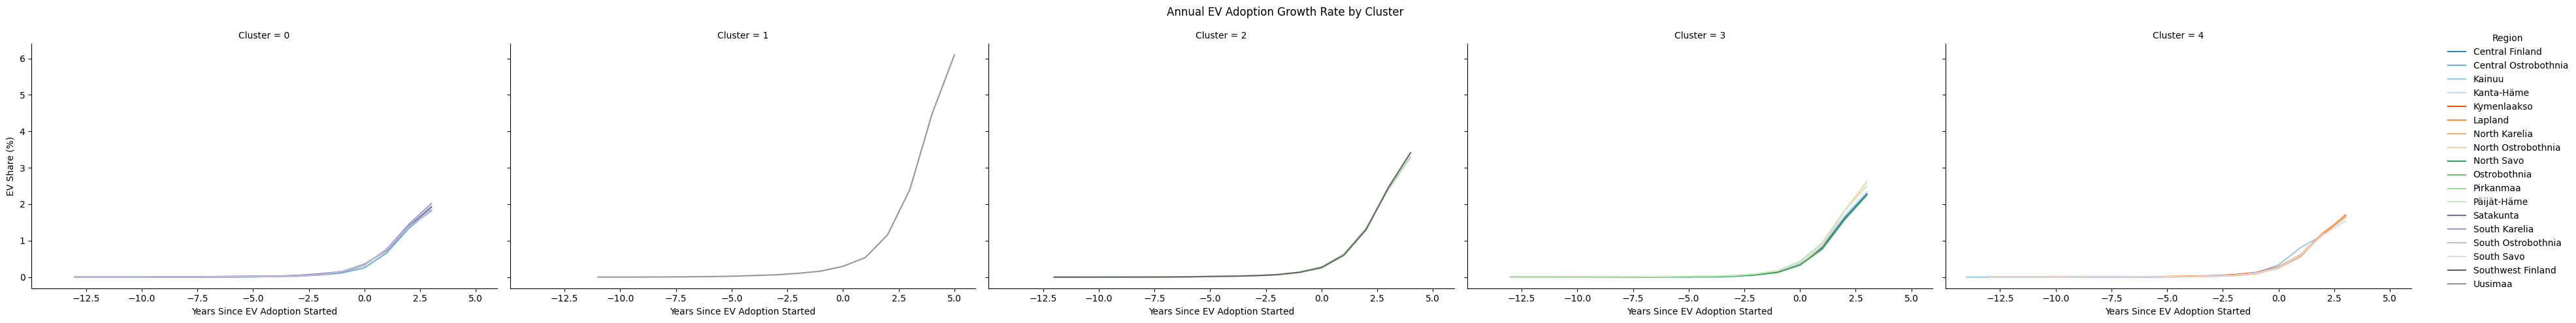

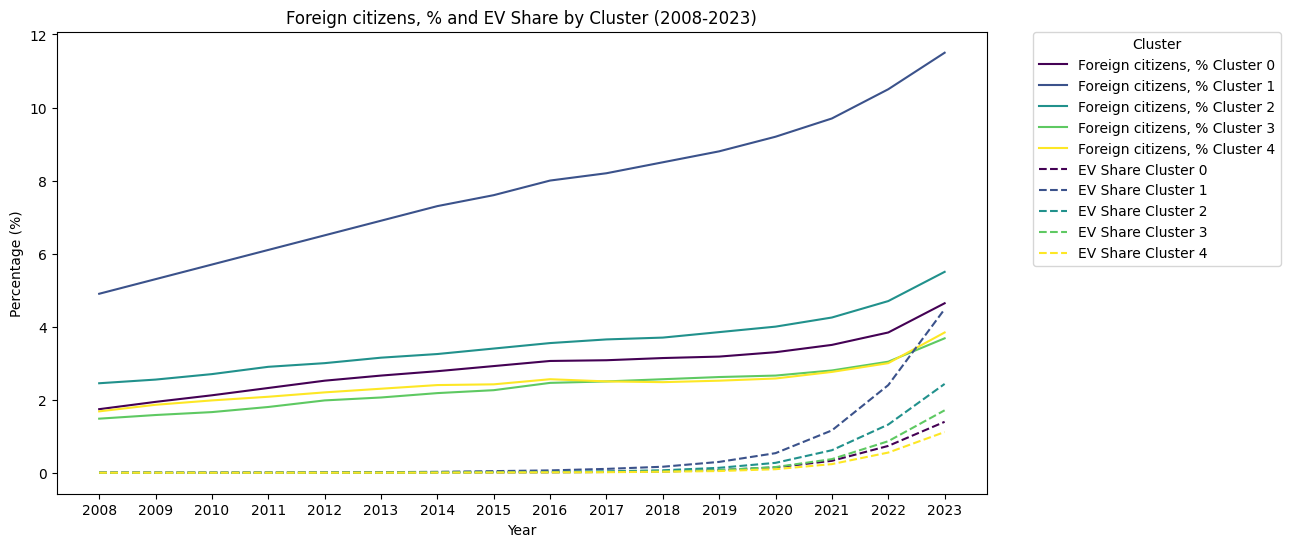

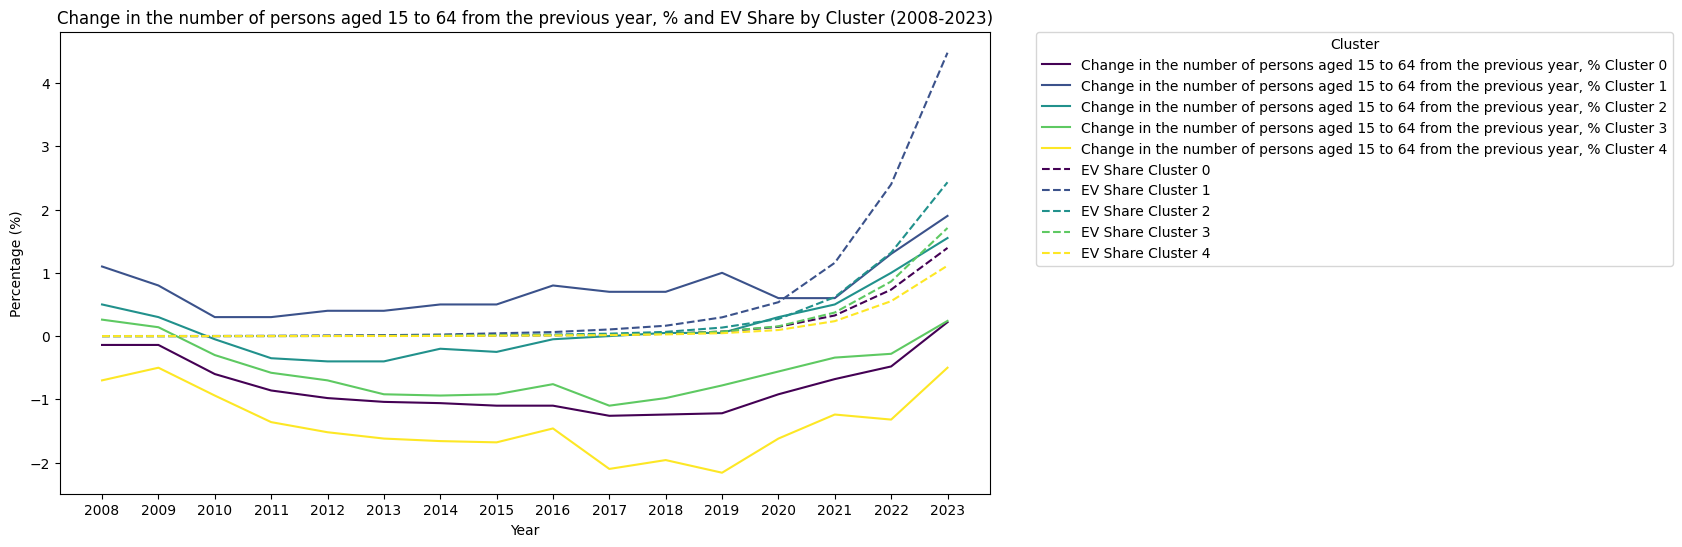

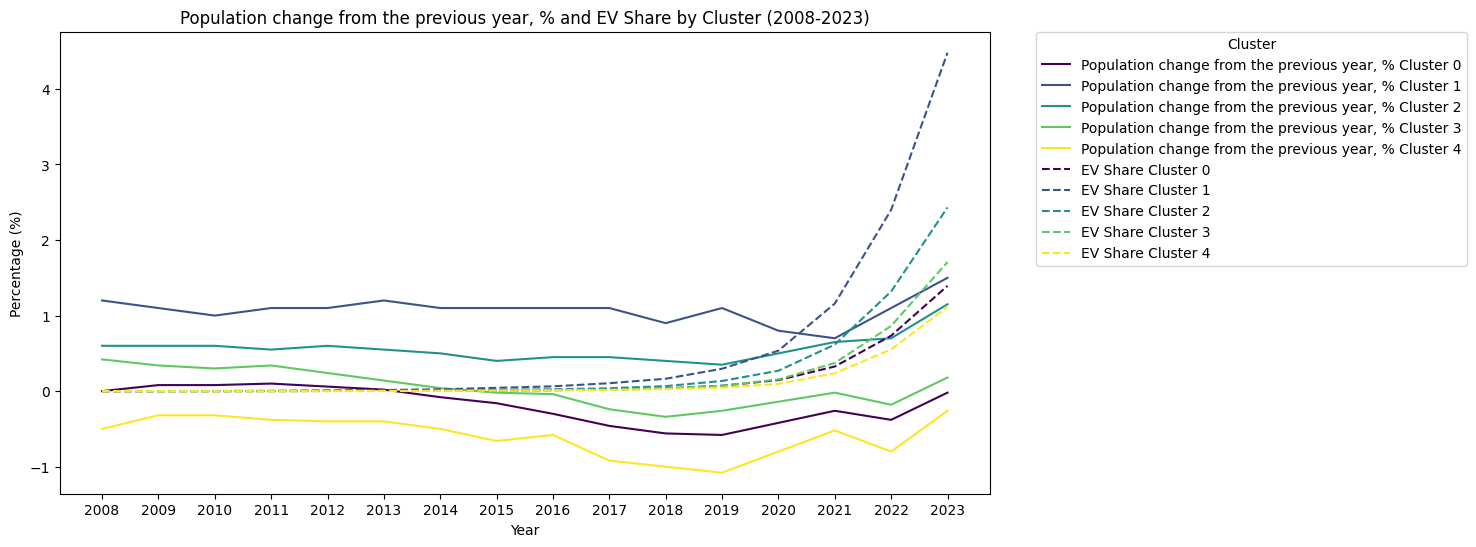

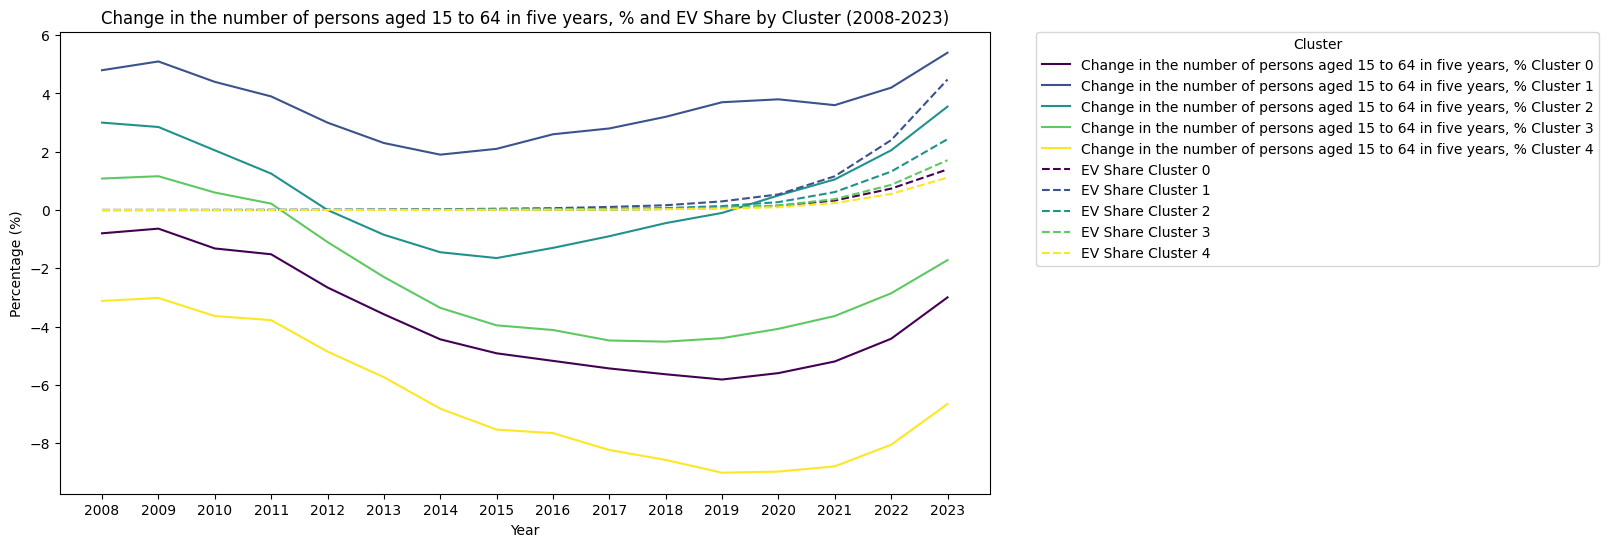

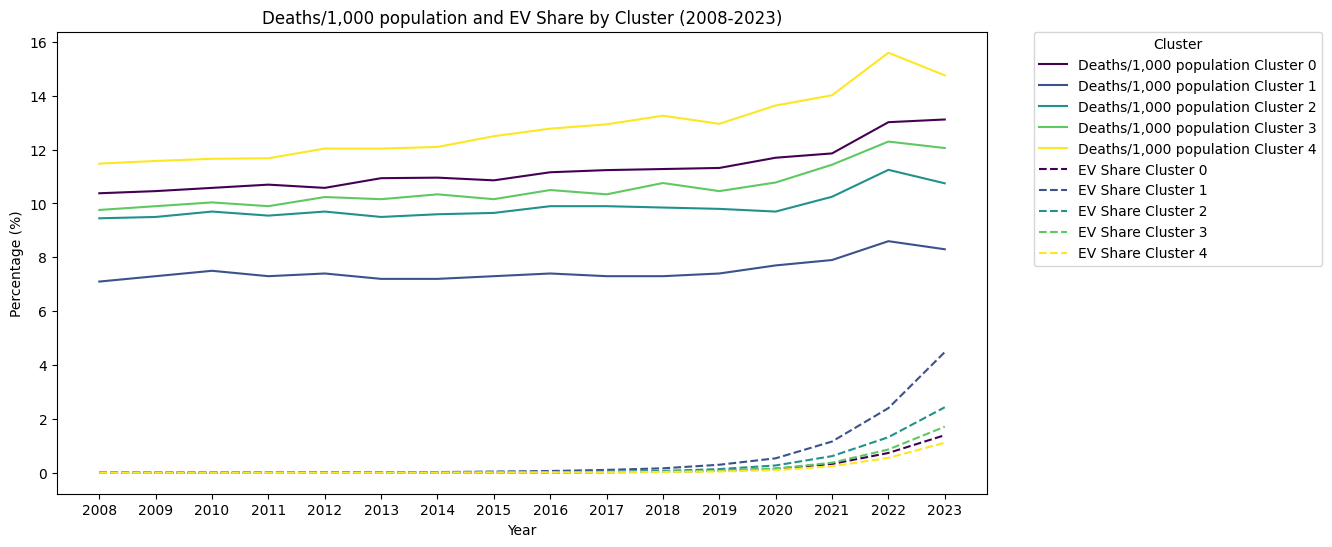

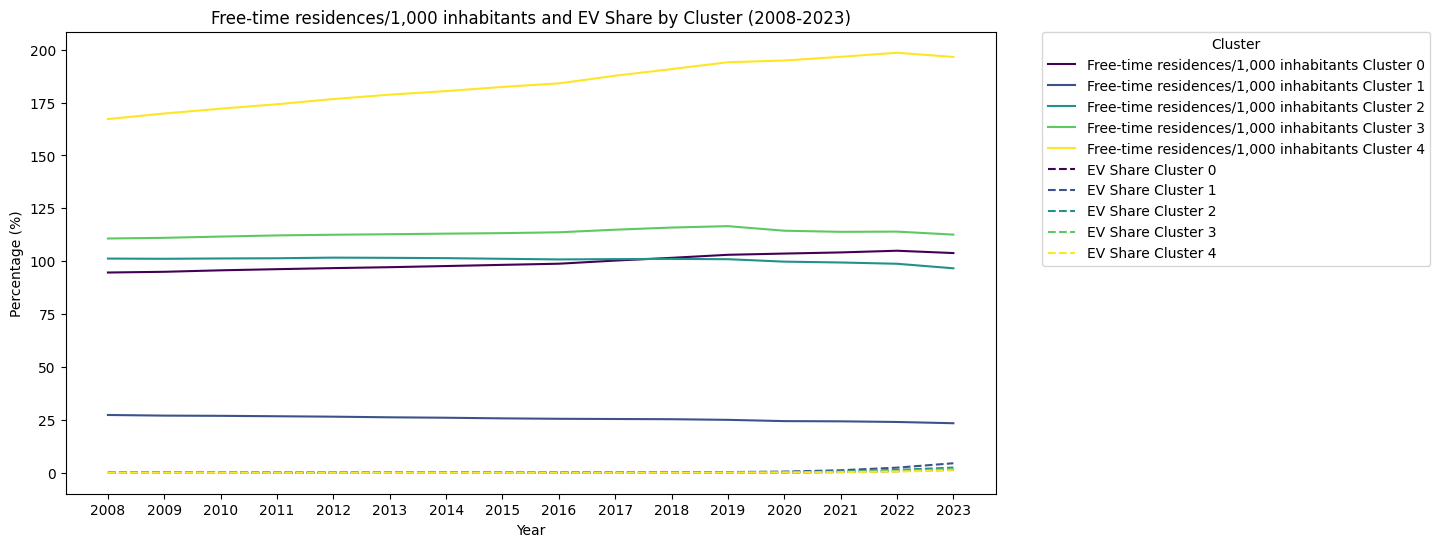

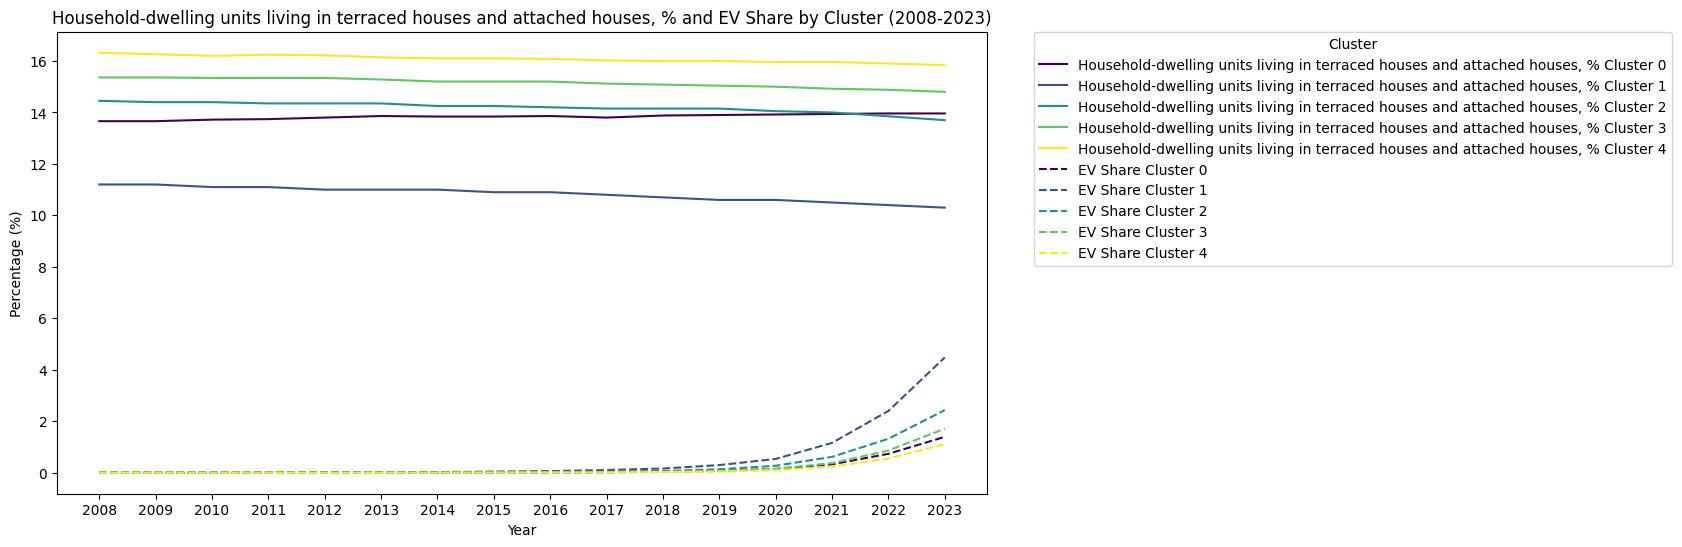

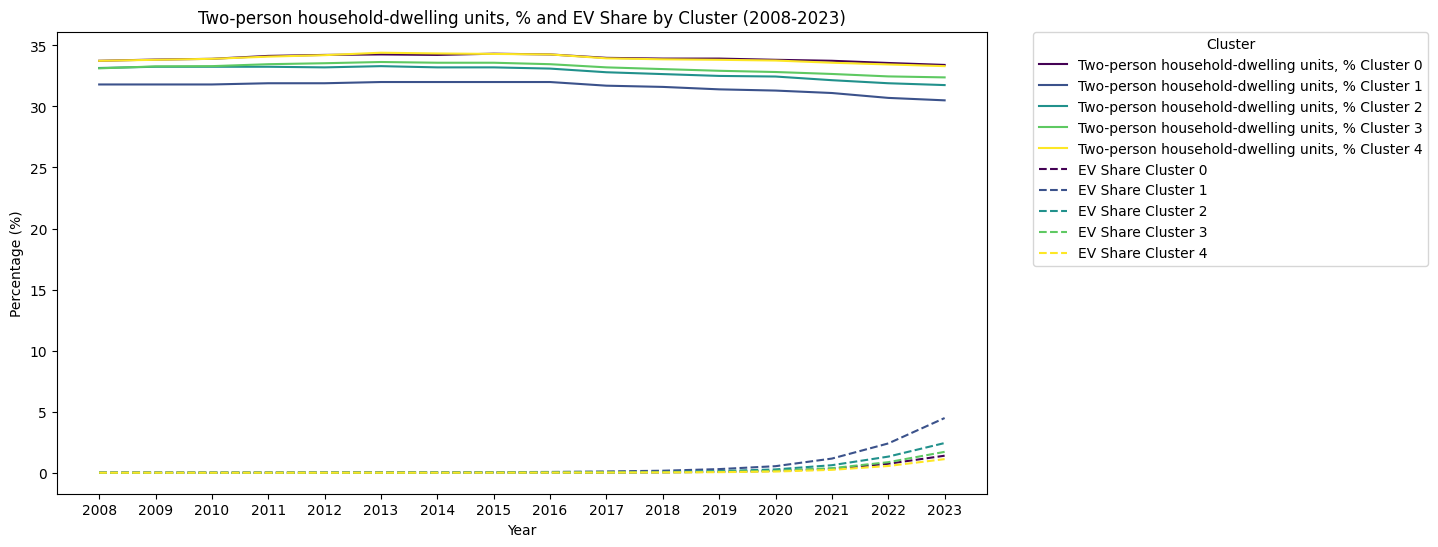

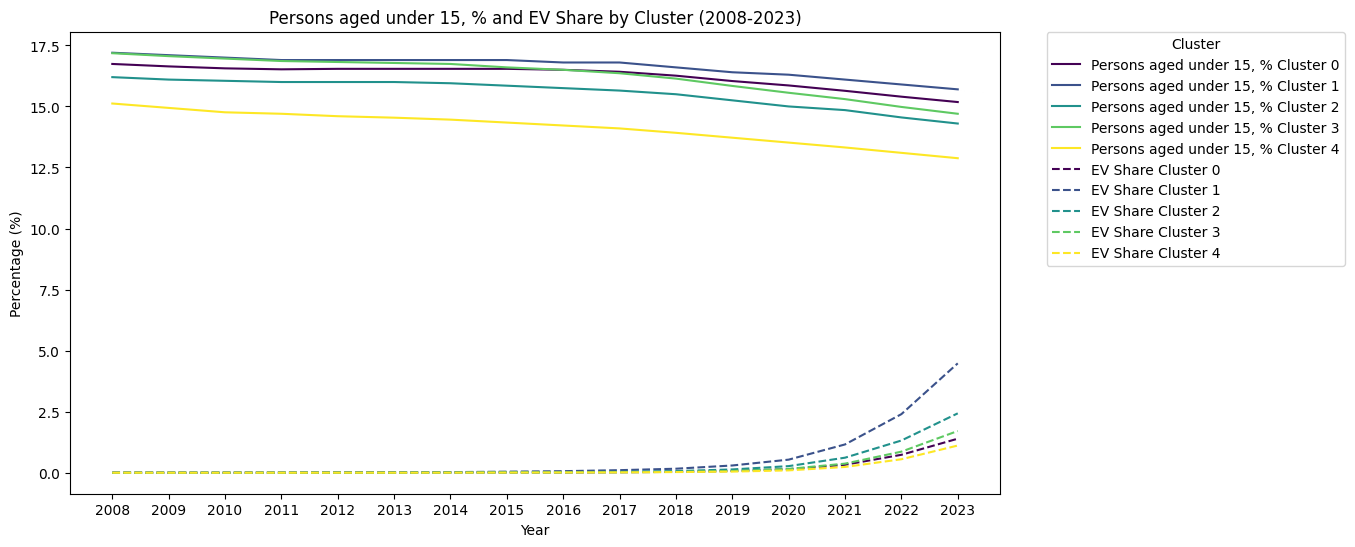

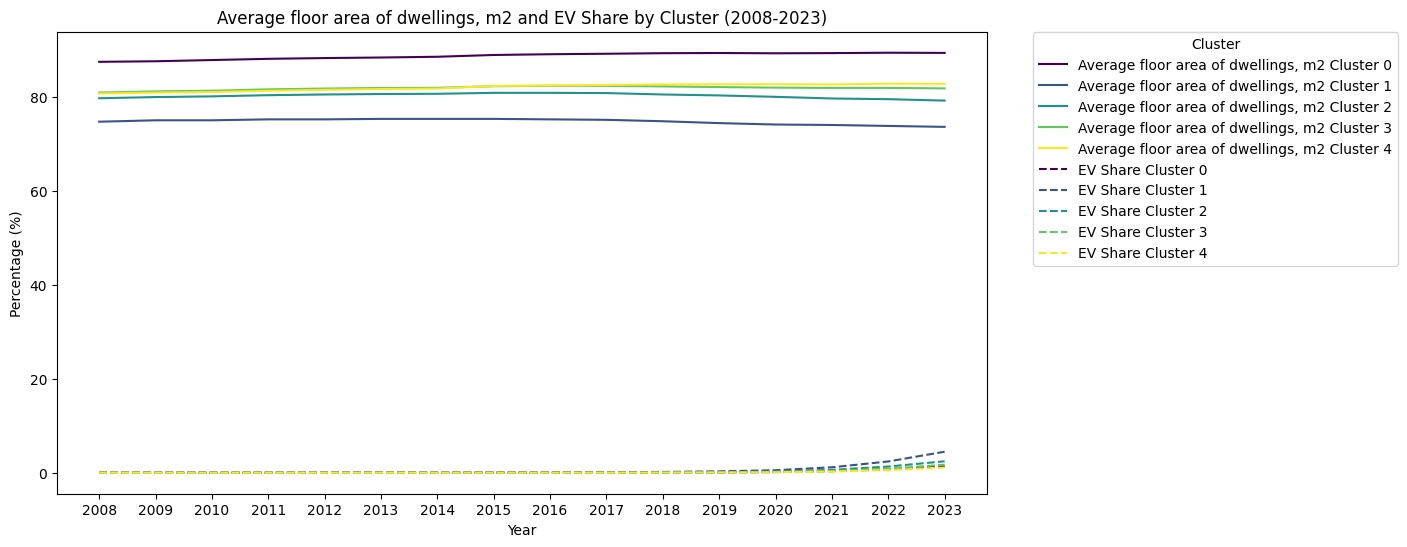

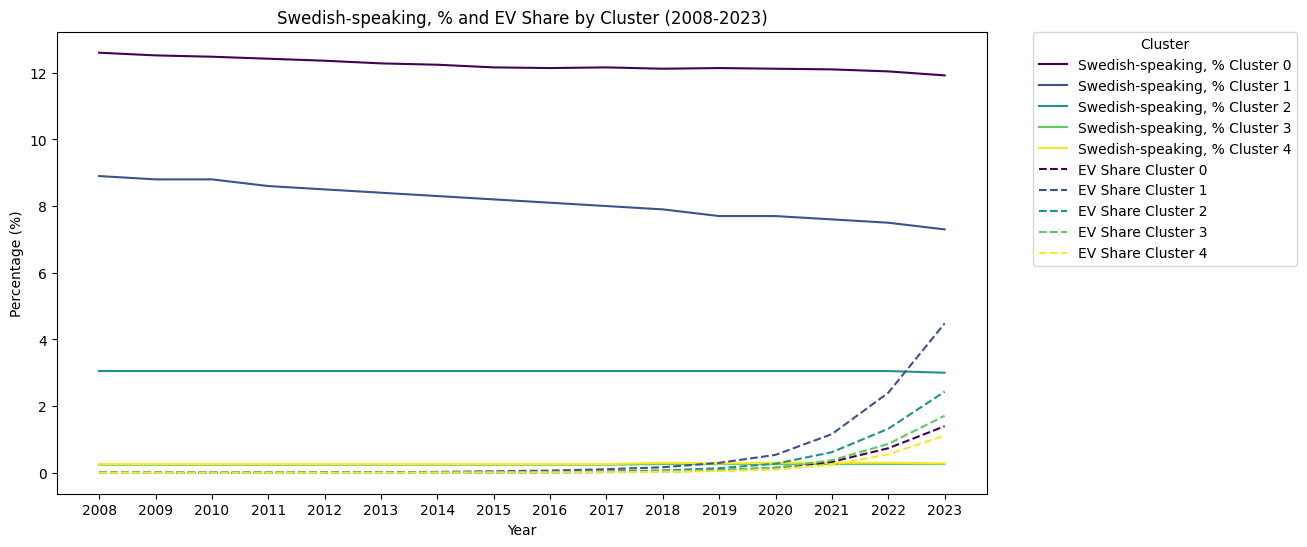

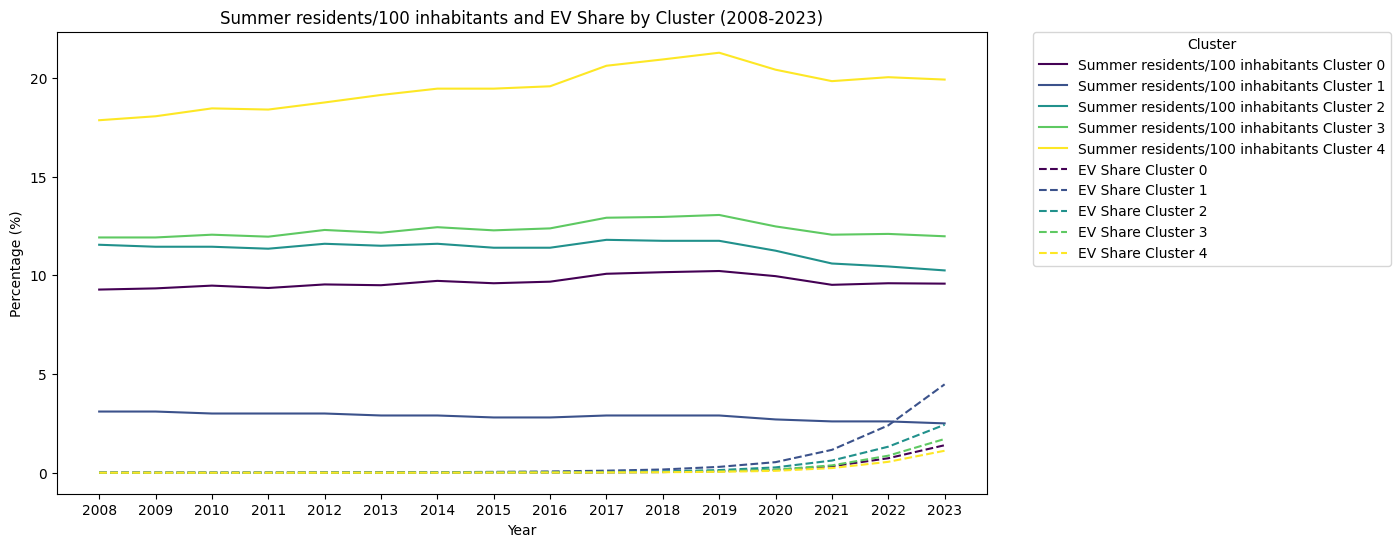

In [36]:
def plot_information_and_ev_share(data, information_label):
    ev_share_data = data[data["Information"] == "EV Share (%)"].copy()
    for year in range(2008, 2024):
        ev_share_data[str(year)] = pd.to_numeric(ev_share_data[str(year)], errors="coerce")
    mean_ev_share = ev_share_data.groupby("Cluster")[[str(year) for year in range(2008, 2024)]].mean().reset_index()

    info_data = data[data["Information"] == information_label].copy()
    for year in range(2008, 2024):
        info_data[str(year)] = pd.to_numeric(info_data[str(year)], errors="coerce")
    mean_info_sector = info_data.groupby("Cluster")[[str(year) for year in range(2008, 2024)]].mean().reset_index()

    colors = plt.cm.viridis(np.linspace(0, 1, mean_info_sector["Cluster"].nunique()))
    cluster_colors = dict(zip(mean_info_sector["Cluster"].unique(), colors))

    plt.figure(figsize=(12, 6))
    for cluster in mean_info_sector["Cluster"]:
        plt.plot(range(2008, 2024), mean_info_sector.loc[mean_info_sector["Cluster"] == cluster].iloc[0, 1:],
                 label=f"{information_label} Cluster {cluster}", color=cluster_colors[cluster])

    for cluster in mean_ev_share["Cluster"]:
        plt.plot(range(2008, 2024), mean_ev_share.loc[mean_ev_share["Cluster"] == cluster].iloc[0, 1:],
                 linestyle="--", label=f"EV Share Cluster {cluster}", color=cluster_colors[cluster])

    plt.title(f"{information_label} and EV Share by Cluster (2008-2023)")
    plt.xlabel("Year")
    plt.ylabel("Percentage (%)")
    plt.xticks(range(2008, 2024))
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.show()

significant_results = correlation_df[correlation_df["P-value"] < 0.05]
top_10_information = pd.concat([
    significant_results.nlargest(10, "Correlation")["Information"],
    significant_results.nsmallest(10, "Correlation")["Information"]
]).unique()

for info in top_10_information:
    plot_information_and_ev_share(socio_clustered_means_with_ev, info)

Differences between the clusters:

In [37]:
comparison_df = socio_clustered_means_with_ev.merge(
    socio_r.groupby("Information")["2023"].mean().rename("Overall Average").reset_index(),
    on="Information",
    how="left"
)

comparison_df["Relative Difference (%)"] = ((comparison_df["2023"] - comparison_df["Overall Average"]) / 
                                            comparison_df["Overall Average"]) * 100

for cluster in comparison_df["Cluster"].unique():
    top_differences = comparison_df[comparison_df["Cluster"] == cluster].nlargest(10, "Relative Difference (%)")
    print(f"\nTop 10 Relative Differences for Cluster {cluster}:")
    for _, row in top_differences.iterrows():
        print(f"{row['Information']:125} Overall Avg: {row['Overall Average']:>8.2f}   "
              f"Cluster Avg: {row['2023']:>8.2f}   Rel Diff: {row['Relative Difference (%)']:>8.2f}%")


Top 10 Relative Differences for Cluster 0:
Swedish-speaking, %                                                                                                           Overall Avg:     4.25   Cluster Avg:    11.92   Rel Diff:   180.64%
Population change in five years, %                                                                                            Overall Avg:    -0.69   Cluster Avg:    -1.60   Rel Diff:   132.06%
Change in the number of persons aged 15 to 64 in five years, %                                                                Overall Avg:    -2.29   Cluster Avg:    -3.00   Rel Diff:    31.03%
Share of employed persons in primary production of all employed persons, %                                                    Overall Avg:     3.71   Cluster Avg:     4.74   Rel Diff:    27.93%
Share of jobs in manufacturing, %                                                                                             Overall Avg:    14.68   Cluster Avg:    18.70   Rel Di

Time to switch to analyzing the same data for municipalities:

In [38]:
socio_m_copy = socio_m.drop(columns=map(str, range(2008, 2023))).rename(columns={"2023": "latest"})
socio_m_copy["municipality_id"] = socio_m_copy["municipality_id"].astype(int)
ev_snapshot["municipality_id"] = ev_snapshot["municipality_id"].astype(int)

socio_m_with_ev = socio_m_copy.merge(
    ev_snapshot[["municipality_id", "EV Share (%)"]], on="municipality_id", how="left"
).rename(columns={"EV Share (%)": "EV Share (%) 2024"})

# Create EV Share row, add Municipality names, and concatenate with main DataFrame
ev_share_row = socio_m_with_ev[["municipality_id", "region_id"]].assign(
    Information="EV Share (%)",
    latest=socio_m_with_ev["EV Share (%) 2024"],
    Municipality=socio_m_with_ev["municipality_id"].apply(lambda mid: helpers.get_name_by_mid(mid, mappings))
).drop_duplicates("municipality_id")

socio_m_with_ev_final = pd.concat([socio_m_with_ev.drop(columns=["EV Share (%) 2024"]), ev_share_row], ignore_index=True)

# Display the updated DataFrame
socio_m_with_ev_final.head(5)

Municipality                                        Information  latest  \
0         Akaa        Population change from the previous year, %    -0.4   
1         Akaa                 Population change in five years, %    -1.2   
2         Akaa                            Persons aged under 7, %     5.6   
3         Akaa                           Persons aged under 15, %    15.3   
4         Akaa  Change in the number of persons aged under 15 ...    -2.9   

   municipality_id  region_id  
0               20          6  
1               20          6  
2               20          6  
3               20          6  
4               20          6

The highest and lowest EV shares per municipality. Just to check the results are the same as earlier.

In [39]:
evs_sorted = ev_snapshot.sort_values(by="EV Share (%)", ascending=False)
top_performers, bottom_performers = evs_sorted.head(10), evs_sorted.tail(10)

print("Top 10 Municipalities by EV Share (%):")
print(top_performers[["Municipality", "EV Share (%)", "municipality_id"]])

print("\nBottom 10 Municipalities by EV Share (%):")
print(bottom_performers[["Municipality", "EV Share (%)", "municipality_id"]])

Top 10 Municipalities by EV Share (%):
    Municipality  EV Share (%)  municipality_id
75    Kauniainen     10.766898              235
9          Espoo      9.224635               49
27      Helsinki      8.338370               91
87   Kirkkonummi      7.198249              257
274       Vantaa      6.857932               92
237      Siuntio      6.510417              755
185     Pirkkala      5.989191              604
123     Lempäälä      5.694920              418
170       Paimio      5.600454              577
59       Kaarina      5.525322              202

Bottom 10 Municipalities by EV Share (%):
    Municipality  EV Share (%)  municipality_id
244  Suomussalmi      0.560486              777
60         Kaavi      0.554871              204
195     Puolanka      0.520059              620
208        Ranua      0.515464              683
91     Kivijärvi      0.500000              265
86       Kinnula      0.451467              256
215   Ristijärvi      0.393701              697
103   

The key differences between the top and bottom (in terms of the EV share of all vehicles) municipalities:

In [40]:
top_municipalities_ids = top_performers['municipality_id'].values
bottom_municipalities_ids = bottom_performers['municipality_id'].values

top_characteristics = socio_m_with_ev_final[socio_m_with_ev_final['municipality_id'].isin(top_municipalities_ids)]
bottom_characteristics = socio_m_with_ev_final[socio_m_with_ev_final['municipality_id'].isin(bottom_municipalities_ids)]

top_avg_characteristics = top_characteristics.groupby('Information')['latest'].mean().reset_index()
bottom_avg_characteristics = bottom_characteristics.groupby('Information')['latest'].mean().reset_index()
overall_avg_characteristics = socio_m_with_ev_final.groupby('Information')['latest'].mean().reset_index()

print("Overall Average Characteristics:")
print(overall_avg_characteristics)

# Step 4: Print the Results for Comparison
print("Top Performers Average Characteristics:")
print(top_avg_characteristics)

print("\nBottom Performers Average Characteristics:")
print(bottom_avg_characteristics)

Overall Average Characteristics:
                                           Information     latest
0                        Average age of the population  48.050171
1                   Average age of the population, men  46.911604
2                 Average age of the population, women  49.223549
3                  Average floor area of dwellings, m2  93.522184
4    Average size of household-dwelling units, persons   1.989761
..                                                 ...        ...
115                        Unemployment risk, women, %   2.688396
116  Women with at least upper secondary qualificat...  73.213311
117  Women with bachelor's degrees, share of women ...  11.199317
118  Women with lowest level tertiary qualification...  11.053925
119  Women with upper secondary and specialist voca...  42.956314

[120 rows x 2 columns]
Top Performers Average Characteristics:
                                           Information  latest
0                        Average age of the popu

There seems to be major differences, but because there are so many charecteristics and they vary in scale, we'll calculate the difference (to the national mean):

In [41]:
comparison_df = (
    pd.merge(top_avg_characteristics, bottom_avg_characteristics, on="Information", how="outer", suffixes=("_Top", "_Bottom"))
    .merge(overall_avg_characteristics, on="Information", how="outer")
)

comparison_df["Top Relative Difference (%)"] = (comparison_df["latest_Top"] - comparison_df["latest"]) / comparison_df["latest"].abs() * 100
comparison_df["Bottom Relative Difference (%)"] = (comparison_df["latest_Bottom"] - comparison_df["latest"]) / comparison_df["latest"].abs() * 100

comparison_df.sort_values("Top Relative Difference (%)", ascending=False, inplace=True)
comparison_df

Information  latest_Top  \
6    Change in the number of employed persons from ...    2.470000   
12   Change in the number of staff years from previ...    2.440000   
7        Change in the number of jobs in five years, %    9.140000   
54   Persons aged 20+ with doctoral or equivalent l...    1.990000   
101  Share of persons aged 15 or over with doctoral...    1.830000   
..                                                 ...         ...   
35   Household-dwelling units living in dwellings w...    3.540000   
28              Free-time residences/1,000 inhabitants   61.524805   
109                   Summer residents/100 inhabitants    6.683734   
89              Share of jobs in primary production, %    1.600000   
72   Share of employed persons in primary productio...    0.870000   

     latest_Bottom      latest  Top Relative Difference (%)  \
6            -1.88   -0.101706                  2528.557047   
12           -2.25   -0.553242                   541.036397   
7            -7.86   -2.685324                   440.368582   
54            0.15    0.484931                   310.367271   
101           0.13    0.448974                   307.595595   
..             ...         ...                          ...   
35           16.02   12.464505                   -71.599354   
28          469.18  287.927126                   -78.631814   
109          60.17   33.699445                   -80.166635   
89           16.38   10.037543                   -84.059844   
72           15.29    8.306826                   -89.526686   

     Bottom Relative Difference (%)  
6                      -1748.456376  
12                      -306.693399  
7                       -192.702084  
54                       -69.067794  
101                      -71.045122  
..                              ...  
35                        28.524958  
28                        62.950954  
109                       78.548935  
89                        63.187351  
72                        84.065492  

[120 rows x 6 columns]

In [42]:
comparison_results = []
for _, row in comparison_df.iterrows():
    info = row["Information"]
    overall_avg = overall_avg_characteristics.loc[
        overall_avg_characteristics["Information"] == info, "latest"
    ].values[0]
    top_avg = row["latest_Top"]
    bottom_avg = row["latest_Bottom"]

    top_distance = top_avg - overall_avg
    bottom_distance = bottom_avg - overall_avg
    top_relative_distance = (top_distance / overall_avg) * 100 if overall_avg != 0 else 0
    bottom_relative_distance = (bottom_distance / overall_avg) * 100 if overall_avg != 0 else 0

    comparison_results.append({
        "Information": info,
        "Overall Average (2023)": overall_avg,
        "Top Performer Average (2023)": top_avg,
        "Top Distance from Overall Average": top_distance,
        "Top Relative Distance (%)": top_relative_distance,
        "Bottom Performer Average (2023)": bottom_avg,
        "Bottom Distance from Overall Average": bottom_distance,
        "Bottom Relative Distance (%)": bottom_relative_distance
    })

comparison_df_final = pd.DataFrame(comparison_results)
comparison_df_final

Information  \
0    Change in the number of employed persons from ...   
1    Change in the number of staff years from previ...   
2        Change in the number of jobs in five years, %   
3    Persons aged 20+ with doctoral or equivalent l...   
4    Share of persons aged 15 or over with doctoral...   
..                                                 ...   
115  Household-dwelling units living in dwellings w...   
116             Free-time residences/1,000 inhabitants   
117                   Summer residents/100 inhabitants   
118             Share of jobs in primary production, %   
119  Share of employed persons in primary productio...   

     Overall Average (2023)  Top Performer Average (2023)  \
0                 -0.101706                      2.470000   
1                 -0.553242                      2.440000   
2                 -2.685324                      9.140000   
3                  0.484931                      1.990000   
4                  0.448974                      1.830000   
..                      ...                           ...   
115               12.464505                      3.540000   
116              287.927126                     61.524805   
117               33.699445                      6.683734   
118               10.037543                      1.600000   
119                8.306826                      0.870000   

     Top Distance from Overall Average  Top Relative Distance (%)  \
0                             2.571706               -2528.557047   
1                             2.993242                -541.036397   
2                            11.825324                -440.368582   
3                             1.505069                 310.367271   
4                             1.381026                 307.595595   
..                                 ...                        ...   
115                          -8.924505                 -71.599354   
116                        -226.402321                 -78.631814   
117                         -27.015711                 -80.166635   
118                          -8.437543                 -84.059844   
119                          -7.436826                 -89.526686   

     Bottom Performer Average (2023)  Bottom Distance from Overall Average  \
0                              -1.88                             -1.778294   
1                              -2.25                             -1.696758   
2                              -7.86                             -5.174676   
3                               0.15                             -0.334931   
4                               0.13                             -0.318974   
..                               ...                                   ...   
115                            16.02                              3.555495   
116                           469.18                            181.252874   
117                            60.17                             26.470555   
118                            16.38                              6.342457   
119                            15.29                              6.983174   

     Bottom Relative Distance (%)  
0                     1748.456376  
1                      306.693399  
2                      192.702084  
3                      -69.067794  
4                      -71.045122  
..                            ...  
115                     28.524958  
116                     62.950954  
117                     78.548935  
118                     63.187351  
119                     84.065492  

[120 rows x 8 columns]

In [43]:
top_10_comparison = comparison_df_final.loc[comparison_df_final['Top Relative Distance (%)'].abs().nlargest(10).index]
bottom_10_comparison = comparison_df_final.loc[comparison_df_final['Bottom Relative Distance (%)'].abs().nlargest(10).index]

print("Top 10 Characteristics with Largest Relative Differences (Top Performers):")
top_10_comparison

Top 10 Characteristics with Largest Relative Differences (Top Performers):


Information  Overall Average (2023)  \
0  Change in the number of employed persons from ...               -0.101706   
1  Change in the number of staff years from previ...               -0.553242   
2      Change in the number of jobs in five years, %               -2.685324   
3  Persons aged 20+ with doctoral or equivalent l...                0.484931   
4  Share of persons aged 15 or over with doctoral...                0.448974   
5        Population change from the previous year, %               -0.628669   
6                 Population change in five years, %               -3.748123   
7  Change in the number of persons aged 15 to 64 ...               -1.031741   
8                                       EV Share (%)                2.189412   
9         Share of jobs in the information sector, %                2.161092   

   Top Performer Average (2023)  Top Distance from Overall Average  \
0                      2.470000                           2.571706   
1                      2.440000                           2.993242   
2                      9.140000                          11.825324   
3                      1.990000                           1.505069   
4                      1.830000                           1.381026   
5                      1.110000                           1.738669   
6                      6.120000                           9.868123   
7                      1.380000                           2.411741   
8                      7.170639                           4.981226   
9                      6.590000                           4.428908   

   Top Relative Distance (%)  Bottom Performer Average (2023)  \
0               -2528.557047                        -1.880000   
1                -541.036397                        -2.250000   
2                -440.368582                        -7.860000   
3                 310.367271                         0.150000   
4                 307.595595                         0.130000   
5                -276.563518                        -1.960000   
6                -263.281734                        -8.940000   
7                -233.754548                        -3.600000   
8                 227.514310                         0.406089   
9                 204.938408                         2.230000   

   Bottom Distance from Overall Average  Bottom Relative Distance (%)  
0                             -1.778294                   1748.456376  
1                             -1.696758                    306.693399  
2                             -5.174676                    192.702084  
3                             -0.334931                    -69.067794  
4                             -0.318974                    -71.045122  
5                             -1.331331                    211.769815  
6                             -5.191877                    138.519395  
7                             -2.568259                    248.924909  
8                             -1.783323                    -81.452143  
9                              0.068908                      3.188566

In [44]:
print("Top 10 Characteristics with Largest Relative Differences (Bottom Performers):")
bottom_10_comparison

Top 10 Characteristics with Largest Relative Differences (Bottom Performers):


Information  \
0    Change in the number of employed persons from ...   
1    Change in the number of staff years from previ...   
7    Change in the number of persons aged 15 to 64 ...   
5          Population change from the previous year, %   
2        Change in the number of jobs in five years, %   
6                   Population change in five years, %   
10   Change in the number of persons aged 15 to 64 ...   
114  Share of persons on unemployment pension in th...   
119  Share of employed persons in primary productio...   
8                                         EV Share (%)   

     Overall Average (2023)  Top Performer Average (2023)  \
0                 -0.101706                      2.470000   
1                 -0.553242                      2.440000   
7                 -1.031741                      1.380000   
5                 -0.628669                      1.110000   
2                 -2.685324                      9.140000   
6                 -3.748123                      6.120000   
10                -7.000000                      6.540000   
114                0.068942                      0.020000   
119                8.306826                      0.870000   
8                  2.189412                      7.170639   

     Top Distance from Overall Average  Top Relative Distance (%)  \
0                             2.571706               -2528.557047   
1                             2.993242                -541.036397   
7                             2.411741                -233.754548   
5                             1.738669                -276.563518   
2                            11.825324                -440.368582   
6                             9.868123                -263.281734   
10                           13.540000                -193.428571   
114                          -0.048942                 -70.990099   
119                          -7.436826                 -89.526686   
8                             4.981226                 227.514310   

     Bottom Performer Average (2023)  Bottom Distance from Overall Average  \
0                          -1.880000                             -1.778294   
1                          -2.250000                             -1.696758   
7                          -3.600000                             -2.568259   
5                          -1.960000                             -1.331331   
2                          -7.860000                             -5.174676   
6                          -8.940000                             -5.191877   
10                        -15.660000                             -8.660000   
114                         0.130000                              0.061058   
119                        15.290000                              6.983174   
8                           0.406089                             -1.783323   

     Bottom Relative Distance (%)  
0                     1748.456376  
1                      306.693399  
7                      248.924909  
5                      211.769815  
2                      192.702084  
6                      138.519395  
10                     123.714286  
114                     88.564356  
119                     84.065492  
8                      -81.452143

And this might be a more meaningful way to calculate things: compare the top and bottom performers to each other, not the national mean:

In [45]:
comparison_results = []
for _, row in comparison_df.iterrows():
    info = row["Information"]
    top_avg = row["latest_Top"]
    bottom_avg = row["latest_Bottom"]

    direct_distance = top_avg - bottom_avg
    relative_distance = (direct_distance / bottom_avg) * 100 if bottom_avg != 0 else 0

    comparison_results.append({
        "Information": info,
        "Top Performer Average (2023)": top_avg,
        "Bottom Performer Average (2023)": bottom_avg,
        "Direct Distance (Top - Bottom)": direct_distance,
        "Relative Distance (%)": relative_distance
    })

comparison_final = pd.DataFrame(comparison_results)

comparison_df_top_differences = comparison_final.reindex(
    comparison_final["Relative Distance (%)"].abs().sort_values(ascending=False).index
).head(10)

comparison_df_top_similarities = comparison_final.reindex(
    comparison_final["Relative Distance (%)"].abs().sort_values().index
).head(10)

comparison_df_top_differences

Information  \
8                                        EV Share (%)   
4   Share of persons aged 15 or over with doctoral...   
3   Persons aged 20+ with doctoral or equivalent l...   
17                                Swedish-speaking, %   
13  Household-dwelling units living in blocks of f...   
14                                Foreign citizens, %   
11  Persons aged 20+ with master's degrees, share ...   
12  Persons with master's degrees, share of person...   
0   Change in the number of employed persons from ...   
2       Change in the number of jobs in five years, %   

    Top Performer Average (2023)  Bottom Performer Average (2023)  \
8                       7.170639                         0.406089   
4                       1.830000                         0.130000   
3                       1.990000                         0.150000   
17                      9.200000                         1.064608   
13                     44.540000                         6.830000   
14                      7.830000                         1.620000   
11                     17.830000                         3.880000   
12                     16.450000                         3.690000   
0                       2.470000                        -1.880000   
2                       9.140000                        -7.860000   

    Direct Distance (Top - Bottom)  Relative Distance (%)  
8                         6.764550            1665.779828  
4                         1.700000            1307.692308  
3                         1.840000            1226.666667  
17                        8.135392             764.167971  
13                       37.710000             552.122987  
14                        6.210000             383.333333  
11                       13.950000             359.536082  
12                       12.760000             345.799458  
0                         4.350000            -231.382979  
2                        17.000000            -216.284987

Top 10 Characteristics with the Smallest Relative Differences (Most Similar):

In [46]:
comparison_df_top_similarities

Information  \
59        Gross floor area of residential buildings, %   
69                 Average floor area of dwellings, m2   
30   Share of jobs in human health and social work ...   
64         Employment rate of persons aged 25 to 34, %   
67         Employment rate of persons aged 18 to 24, %   
97   Share of employed persons in secondary product...   
109  Share of jobs in manufacturing of men's all jo...   
80   Share of jobs in accommodation and food servic...   
63         Employment rate of persons aged 35 to 44, %   
65   Share of persons aged 15 or over with lowest l...   

     Top Performer Average (2023)  Bottom Performer Average (2023)  \
59                          68.45                            67.78   
69                          90.15                            91.51   
30                           5.41                             5.27   
64                          78.27                            75.62   
67                          53.53                            51.57   
97                          18.84                            19.74   
109                         13.51                            12.77   
80                           2.96                             3.25   
63                          84.59                            77.49   
65                           6.91                             6.26   

     Direct Distance (Top - Bottom)  Relative Distance (%)  
59                             0.67               0.988492  
69                            -1.36              -1.486176  
30                             0.14               2.656546  
64                             2.65               3.504364  
67                             1.96               3.800659  
97                            -0.90              -4.559271  
109                            0.74               5.794832  
80                            -0.29              -8.923077  
63                             7.10               9.162473  
65                             0.65              10.383387

In [47]:
# For the blog article

helpers.df_to_markdown(comparison_df_top_differences, ["Information", "Top Performer Average (2023)", "Bottom Performer Average (2023)", "Direct Distance (Top - Bottom)", "Relative Distance (%)"])
print("\n")
helpers.df_to_markdown(comparison_df_top_similarities, ["Information", "Top Performer Average (2023)", "Bottom Performer Average (2023)", "Direct Distance (Top - Bottom)", "Relative Distance (%)"])

| Information                                                                       |   Top Performer Average (2023) |   Bottom Performer Average (2023) |   Direct Distance (Top - Bottom) |   Relative Distance (%) |
|:----------------------------------------------------------------------------------|-------------------------------:|----------------------------------:|---------------------------------:|------------------------:|
| EV Share (%)                                                                      |                        7.17064 |                          0.406089 |                          6.76455 |                1665.78  |
| Share of persons aged 15 or over with doctoral or equivalent level degrees, %     |                        1.83    |                          0.13     |                          1.7     |                1307.69  |
| Persons aged 20+ with doctoral or equivalent level degrees, share of age group, % |                        1.99    |                  

Let's test if we can predict the EV Share (%) of a municipality.

We'll do this in two ways:
- choose features based on the largest relative distances (> 100% relative distance to the national mean values)
- choose features based on highest variations

In [48]:
characteristics_list = comparison_df_final[
    (comparison_df_final[['Top Relative Distance (%)', 'Bottom Relative Distance (%)']].abs() >= 100).any(axis=1) &
    (comparison_df_final['Information'] != 'EV Share (%)')
]['Information'].tolist()

characteristics_list

['Change in the number of employed persons from previous year, %',
 'Change in the number of staff years from previous year, %',
 'Change in the number of jobs in five years, %',
 'Persons aged 20+ with doctoral or equivalent level degrees, share of age group, %',
 'Share of persons aged 15 or over with doctoral or equivalent level degrees, %',
 'Population change from the previous year, %',
 'Population change in five years, %',
 'Change in the number of persons aged 15 to 64 from the previous year, %',
 'Share of jobs in the information sector, %',
 'Change in the number of persons aged 15 to 64 in five years, %',
 "Persons aged 20+ with master's degrees, share of age group, %",
 "Persons with master's degrees, share of persons aged 15 or over, %",
 'Household-dwelling units living in blocks of flats, %',
 'Foreign citizens, %']

In [49]:
high_variance_characteristics = (socio_m[['Information', '2023']]
                                 .assign(**{'2023': pd.to_numeric(socio_m['2023'], errors='coerce')})
                                 .dropna()
                                 .groupby('Information')['2023']
                                 .var()
                                 .nlargest(20)
                                 .index
                                 .tolist())

high_variance_characteristics

['Free-time residences/1,000 inhabitants',
 'Summer residents/100 inhabitants',
 'Degree of urbanisation, %',
 'Persons working outside their municipality of residence, % of employed labour force in the area',
 'Employees working in their municipality of residence, share of employed persons, %',
 'Household-dwelling units living in blocks of flats, %',
 'Household-dwelling units living in terraced houses and detached houses, %',
 'Swedish-speaking, %',
 'Household-dwelling units living in detached houses, %',
 'Private free-time residences owned by those living in other municipalities, %',
 "Share of jobs in manufacturing of men's all jobs, %",
 'Persons commuting to the municipality where the workplace is located, % of persons working in the area',
 'Share of jobs in services, %',
 'Share of jobs in secondary production, %',
 'Share of jobs in manufacturing, %',
 'Average floor area of dwellings, m2',
 'Share of pensioners in the population, %',
 'Change in the number of jobs in five 

This code trains the model using both ways defined above (largest relative distances and largest variations). Consequtive tests are ran including a growing number of features to identify what's the minimal number of features needed to get a good prediction.

In [50]:
def prepare_ml_dataset(characteristics_list, ev_snapshot, socio_m, num_characteristics):
    selected_characteristics = characteristics_list[:num_characteristics]
    ml_dataset = ev_snapshot[['municipality_id', 'EV Share (%)']].copy()

    socio_2022_wide = (socio_m[socio_m['Information'].isin(selected_characteristics)]
                       .pivot(index='municipality_id', columns='Information', values='2022')
                       .reset_index())
    ml_dataset = ml_dataset.merge(socio_2022_wide, on='municipality_id', how='left').drop(columns='municipality_id')

    return ml_dataset

def evaluate_model_for_different_characteristics(characteristics_list, ev_snapshot, socio_m):
    results = []

    for num_characteristics in range(3, len(characteristics_list) + 1):
        print(f"\nEvaluating model with top {num_characteristics} characteristics...")

        ml_dataset = prepare_ml_dataset(characteristics_list, ev_snapshot, socio_m, num_characteristics)

        X = ml_dataset.drop(columns=['EV Share (%)'])
        y = ml_dataset['EV Share (%)']

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        results.append({
            "num_characteristics": num_characteristics,
            "MAE": mae,
            "MSE": mse,
            "r2": r2
        })

        print(f"Top {num_characteristics} Characteristics - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

    return results

print("Evaluating the top/bottom characteristics")
results = evaluate_model_for_different_characteristics(characteristics_list, ev_snapshot, socio_m)

print("\n\n")

print("Evaluating the high variance characteristics")
results = evaluate_model_for_different_characteristics(high_variance_characteristics, ev_snapshot, socio_m)


Evaluating the top/bottom characteristics

Evaluating model with top 3 characteristics...
Top 3 Characteristics - MAE: 1.0441, MSE: 2.9610, R²: 0.2068

Evaluating model with top 4 characteristics...
Top 4 Characteristics - MAE: 0.7155, MSE: 1.2535, R²: 0.6642

Evaluating model with top 5 characteristics...
Top 5 Characteristics - MAE: 0.7223, MSE: 1.2678, R²: 0.6604

Evaluating model with top 6 characteristics...
Top 6 Characteristics - MAE: 0.6742, MSE: 1.2722, R²: 0.6592

Evaluating model with top 7 characteristics...
Top 7 Characteristics - MAE: 0.6021, MSE: 0.8873, R²: 0.7623

Evaluating model with top 8 characteristics...
Top 8 Characteristics - MAE: 0.6001, MSE: 0.9361, R²: 0.7493

Evaluating model with top 9 characteristics...
Top 9 Characteristics - MAE: 0.6241, MSE: 1.0444, R²: 0.7202

Evaluating model with top 10 characteristics...
Top 10 Characteristics - MAE: 0.6101, MSE: 1.0603, R²: 0.7160

Evaluating model with top 11 characteristics...
Top 11 Characteristics - MAE: 0.620

In case of biggest relative distances, the model seems to peak at 7 features:

"Evaluating model with top 7 characteristics...
Top 7 Characteristics - MAE: 0.6021, MSE: 0.8873, R²: 0.7623"

These 7 characteristics are:

In [51]:
characteristics_list[:7]

['Change in the number of employed persons from previous year, %',
 'Change in the number of staff years from previous year, %',
 'Change in the number of jobs in five years, %',
 'Persons aged 20+ with doctoral or equivalent level degrees, share of age group, %',
 'Share of persons aged 15 or over with doctoral or equivalent level degrees, %',
 'Population change from the previous year, %',
 'Population change in five years, %']

ChatGPT 4o kindly suggested to try RandomForestRegressor with both feature sets so let's see how it performs:

In [52]:
def prepare_ml_dataset(characteristics_list, ev_snapshot, socio_m, num_characteristics):
    selected_characteristics = characteristics_list[:num_characteristics]
    ml_dataset = ev_snapshot[["municipality_id", "EV Share (%)"]].copy()

    socio_2022_wide = (socio_m[socio_m["Information"].isin(selected_characteristics)]
                       .pivot(index="municipality_id", columns="Information", values="2022")
                       .reset_index())
    ml_dataset = ml_dataset.merge(socio_2022_wide, on="municipality_id", how="left").drop(columns="municipality_id")

    return ml_dataset

def train_and_evaluate_model(characteristics, ev_snapshot, socio_m, label):
    ml_dataset = prepare_ml_dataset(characteristics, ev_snapshot, socio_m, len(characteristics))
    X = ml_dataset.drop(columns="EV Share (%)")
    y = ml_dataset["EV Share (%)"]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)
    print(f"{label} Model - Validation Set:")
    print(f"MAE: {mae_val:.4f}, MSE: {mse_val:.4f}, R²: {r2_val:.4f}")

    cv_mae = -np.mean(cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error'))
    cv_mse = -np.mean(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error'))
    cv_r2 = np.mean(cross_val_score(model, X, y, cv=5, scoring='r2'))
    print(f"{label} Model - Cross-Validated on Whole Dataset:")
    print(f"MAE: {cv_mae:.4f}, MSE: {cv_mse:.4f}, R²: {cv_r2:.4f}")

print("Evaluating Relative Distance Model")
train_and_evaluate_model(characteristics_list, ev_snapshot, socio_m, "Relative Distance")

print("\nEvaluating Variance Model")
train_and_evaluate_model(high_variance_characteristics, ev_snapshot, socio_m, "Variance")

Evaluating Relative Distance Model
Relative Distance Model - Validation Set:
MAE: 0.6129, MSE: 0.9940, R²: 0.7337
Relative Distance Model - Cross-Validated on Whole Dataset:
MAE: 0.5378, MSE: 0.6622, R²: 0.6856

Evaluating Variance Model
Variance Model - Validation Set:
MAE: 0.5479, MSE: 1.1022, R²: 0.7048
Variance Model - Cross-Validated on Whole Dataset:
MAE: 0.5119, MSE: 0.5822, R²: 0.7176


The results are average (?).

Let's see what TPOT can come up with:

In [53]:
ml_dataset = pd.merge(
    ev_snapshot[['municipality_id', 'EV Share (%)']],
    socio_m[['municipality_id', 'Information', '2023']].dropna(subset=['2023']).pivot(
        index='municipality_id', columns='Information', values='2023').reset_index(),
    on='municipality_id', how='inner'
)

X, y = ml_dataset.drop(columns=['municipality_id', 'EV Share (%)']), ml_dataset['EV Share (%)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=42, scoring="r2")
tpot.fit(X_train, y_train)

tpot.export('best_pipeline.py')
print("Test Score:", tpot.score(X_test, y_test))

                                                                              
Generation 1 - Current best internal CV score: 0.7830108324886469
                                                                              
Generation 2 - Current best internal CV score: 0.786307373420539
                                                                              
Generation 3 - Current best internal CV score: 0.7917281788538891
                                                                              
Generation 4 - Current best internal CV score: 0.7917281788538891
                                                                              
Generation 5 - Current best internal CV score: 0.7917281788538891
                                                                              
Generation 6 - Current best internal CV score: 0.7917281788538891
                                                                              
Generation 7 - Current best internal CV score: 0.791

Some test results from various TPOT test runs. The one with 300 generations and 300 population ran for 40+ hours on Mac Studio.

tpot = TPOTRegressor(generations=300, population_size=300, verbosity=2, random_state=42, scoring="r2", config_dict='TPOT sparse')
Generation 300 - Current best internal CV score: 0.8315938495428989
Best pipeline: RandomForestRegressor(LinearSVR(LinearSVR(LinearSVR(input_matrix, C=0.0001, dual=True, epsilon=0.01, loss=squared_epsilon_insensitive, tol=1e-05), C=0.001, dual=True, epsilon=1.0, loss=epsilon_insensitive, tol=0.001), C=0.001, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=1e-05), bootstrap=False, max_features=0.30000000000000004, min_samples_leaf=3, min_samples_split=3, n_estimators=100)
Test Score: 0.8645338138947336
Mean Absolute Error (MAE): 0.1294455149805889
Mean Absolute Percentage Error (MAPE): 0.0716740464005875
Root Mean Squared Error (RMSE): 0.3389291156143296
R-squared (R²): 0.9447611294270853
Median Absolute Error (MedAE): 0.04152511589629038
Symmetric Mean Absolute Percentage Error (SMAPE): 6.974479550944899

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=42, scoring="r2", config_dict='TPOT sparse'):
Generation 10 - Current best internal CV score: 0.789279467220005
Best pipeline: ElasticNetCV(RidgeCV(KNeighborsRegressor(input_matrix, n_neighbors=32, p=1, weights=uniform)), l1_ratio=0.65, tol=1e-05)
Imputing missing values in feature set
Test Score: 0.9290638869016034
Mean Absolute Error (MAE): 0.33343279525698233
Mean Absolute Percentage Error (MAPE): 0.19824381995779108
Root Mean Squared Error (RMSE): 0.45892119767425976
R-squared (R²): 0.8987247625356185
Median Absolute Error (MedAE): 0.22654894774952972
Symmetric Mean Absolute Percentage Error (SMAPE): 18.678107448930206

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=42, scoring="r2")
Generation 10 - Current best internal CV score: 0.8038584473967163                                                
Best pipeline: ExtraTreesRegressor(RidgeCV(ZeroCount(input_matrix)), bootstrap=False, max_features=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
Test Score: 0.8534072691972484
Mean Absolute Error (MAE): 0.1233856163605864
Mean Absolute Percentage Error (MAPE): 0.07356613783057354
Root Mean Squared Error (RMSE): 0.33866601709544014
R-squared (R²): 0.9448468560497763
Median Absolute Error (MedAE): 0.03282050046443885
Symmetric Mean Absolute Percentage Error (SMAPE): 6.8731397509915695

tpot = TPOTRegressor(generations=25, population_size=100, verbosity=2, random_state=42, scoring="r2")
Generation 25 - Current best internal CV score: 0.8337640471197492             
Best pipeline: AdaBoostRegressor(ZeroCount(ElasticNetCV(input_matrix, l1_ratio=0.4, tol=0.001)), learning_rate=0.5, loss=square, n_estimators=100)
Test Score: 0.8674772596683704
Mean Absolute Error (MAE): 0.30343815663917384
Mean Absolute Percentage Error (MAPE): 0.1991962917415886
Root Mean Squared Error (RMSE): 0.4289945901553712
R-squared (R²): 0.9115025688161535
Median Absolute Error (MedAE): 0.2617507084334816
Symmetric Mean Absolute Percentage Error (SMAPE): 17.868163718487832

tpot = TPOTRegressor(generations=50, population_size=50, verbosity=2, random_state=42, scoring="r2")
Generation 50 - Current best internal CV score: 0.831033037616778                                                  
Best pipeline: AdaBoostRegressor(ElasticNetCV(input_matrix, l1_ratio=0.5, tol=0.01), learning_rate=1.0, loss=square, n_estimators=100)
Test Score: 0.8702448863603693
Mean Absolute Error (MAE): 0.3030701657096319
Mean Absolute Percentage Error (MAPE): 0.19709078749633663
Root Mean Squared Error (RMSE): 0.42787648512260085
R-squared (R²): 0.9119632761426594
Median Absolute Error (MedAE): 0.2607646497212619
Symmetric Mean Absolute Percentage Error (SMAPE): 18.01309146731624

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=42, scoring="r2", config_dict='TPOT MDR'):
Generation 10 - Current best internal CV score: 0.7765845752944001                                                                              
Best pipeline: ElasticNetCV(ElasticNetCV(CombineDFs(CombineDFs(input_matrix, input_matrix), input_matrix), l1_ratio=0.05, tol=0.0001), l1_ratio=0.65, tol=0.01)
Test Score: 0.9166664854557913
Mean Absolute Error (MAE): 0.3741804806441279
Mean Absolute Percentage Error (MAPE): 0.22641990121708458
Root Mean Squared Error (RMSE): 0.5152200033351804
R-squared (R²): 0.8723524552565736
Median Absolute Error (MedAE): 0.2614833678714207
Symmetric Mean Absolute Percentage Error (SMAPE): 20.863655548201034

tpot = TPOTRegressor(generations=100, population_size=100, verbosity=2, random_state=42, scoring="r2")
Generation 100 - Current best internal CV score: 0.8371397846225023                                 
Best pipeline: AdaBoostRegressor(ZeroCount(RobustScaler(ElasticNetCV(input_matrix, l1_ratio=0.5, tol=0.001))), learning_rate=1.0, loss=square, n_estimators=100)
Test Score: 0.8619762710567058
Mean Absolute Error (MAE): 0.3064138614187806
Mean Absolute Percentage Error (MAPE): 0.19952611705371157
Root Mean Squared Error (RMSE): 0.4342525918051185
R-squared (R²): 0.9093199247410988
Median Absolute Error (MedAE): 0.2773466217147864
Symmetric Mean Absolute Percentage Error (SMAPE): 18.07996043176913

Apply the model TPOT identified to the whole dataset:

In [54]:
y_pred_full = tpot.predict(X)

error_percentage = [
    0 if actual == 0 else abs((actual - predicted) / actual) * 100
    for actual, predicted in zip(y.values, y_pred_full)
]

full_results_df = pd.DataFrame({
    'municipality_id': ml_dataset['municipality_id'],
    'Actual EV Share (%)': y.values,
    'Predicted EV Share (%)': y_pred_full,
    'Error (%)': error_percentage
})

full_results_with_names = pd.merge(full_results_df, socio_m[['municipality_id', 'Municipality']].drop_duplicates(), on='municipality_id', how='left')

full_results_with_names = full_results_with_names[['Municipality', 'municipality_id', 'Actual EV Share (%)', 'Predicted EV Share (%)', 'Error (%)']]

full_results_with_names

Municipality  municipality_id  Actual EV Share (%)  \
0           Akaa               20             3.151011   
1       Alajärvi                5             1.503490   
2      Alavieska                9             1.607502   
3         Alavus               10             1.255658   
4       Asikkala               16             2.324159   
..           ...              ...                  ...   
288    Ylivieska              977             2.275831   
289     Ylöjärvi              980             3.744756   
290        Ypäjä              981             1.617251   
291       Ähtäri              989             1.230123   
292    Äänekoski              992             1.545744   

     Predicted EV Share (%)  Error (%)  
0                  3.182165   0.988708  
1                  1.519196   1.044624  
2                  1.636703   1.816586  
3                  1.311851   4.475201  
4                  2.317451   0.288608  
..                      ...        ...  
288                2.289358   0.594377  
289                3.883109   3.694591  
290                1.660039   2.645775  
291                1.253139   1.871023  
292                1.592793   3.043780  

[293 rows x 5 columns]

Additional metrics to evaluate the model:

In [55]:
mae = mean_absolute_error(full_results_with_names['Actual EV Share (%)'], full_results_with_names['Predicted EV Share (%)'])

non_zero_actuals = full_results_with_names['Actual EV Share (%)'] != 0
mape = mean_absolute_percentage_error(
    full_results_with_names.loc[non_zero_actuals, 'Actual EV Share (%)'],
    full_results_with_names.loc[non_zero_actuals, 'Predicted EV Share (%)']
)

rmse = mean_squared_error(full_results_with_names['Actual EV Share (%)'], full_results_with_names['Predicted EV Share (%)'], squared=False)
r2 = r2_score(full_results_with_names['Actual EV Share (%)'], full_results_with_names['Predicted EV Share (%)'])
medae = median_absolute_error(full_results_with_names['Actual EV Share (%)'], full_results_with_names['Predicted EV Share (%)'])

smape = 100 * np.mean(2 * abs(full_results_with_names['Actual EV Share (%)'] - full_results_with_names['Predicted EV Share (%)']) / 
                      (abs(full_results_with_names['Actual EV Share (%)']) + abs(full_results_with_names['Predicted EV Share (%)'])))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)
print("Median Absolute Error (MedAE):", medae)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)

Mean Absolute Error (MAE): 0.1552652833848268
Mean Absolute Percentage Error (MAPE): 0.09197777115147406
Root Mean Squared Error (RMSE): 0.3628768749773105
R-squared (R²): 0.936679312840832
Median Absolute Error (MedAE): 0.07468978530975923
Symmetric Mean Absolute Percentage Error (SMAPE): 8.630164885561891


/Users/markus/Documents/macademia/evfi/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
